# 本次栈变量净生分析结论: 栈变量净生仅剩2.5%

- 上回结论：到程序结束时，栈变量 生24万、死22万、  净生2万，   即约10%的不平衡性

- 本回结论：到程序结束时，栈变量 生24万、死23.5万、净生0.5万，即**约2.5%的不平衡性, 较上次有实质性提升**。

# 产生滴答日志过程介绍



###### 1. 用 已正常工作的 clang加花括号插件libBrcPlugin.so 对目标物品llvm-project 加花括号
> [clang-plugin-add-brace/a5e9c786ec81de511c6a134684509b8d09a36091](http://localhost:10880/analyze_code/clang-plugin-add-brace/commit/a5e9c786ec81de511c6a134684509b8d09a36091)


```bash
# 用libBrcPlugin.so在编译过程中对源码加花括号
bash -x /pubx/llvm-project/doc_clang15_build/brc_build1_plugin.sh

#加花括号后源码为: https://gitcode.net/pubz/llvm-project/-/commit/161888dca45b61a745605d632a6e90d8ea9cb5ec

# 再次编译已经加花括号的源码，
#   编译成功、且编译产物clang-15能正常使用, 即验证了 加花括号 是 成功的，因为其没有影响clang正常功能。
bash -x /pubx/llvm-project/doc_clang15_build/brc_build2_directly.sh
```




###### 2. 获得已加花括号的目标物品llvm-project
> [llvm-project/161888dca45b61a745605d632a6e90d8ea9cb5ec](https://gitcode.net/pubz/llvm-project/-/commit/161888dca45b61a745605d632a6e90d8ea9cb5ec)
>
> 注意这个提交信息写错了，写成 'tick:...'了，应该写为'braced:...', 不过提交内容是没问题的



###### 3. 用 已经正常工作的 clang滴答插件libCTk.so 对已加花括号的目标物品llvm-project 加滴答语句
>[clang-ctk/9c913ca6348531db8191b4819967f9e68cc1030e](http://localhost:10880/analyze_code/clang-ctk/commit/9c913ca6348531db8191b4819967f9e68cc1030e)

```bash
# 用libCTk.so在编译过程中对源码加滴答语句
bash -x /pubx/llvm-project/doc_clang15_build/tick_build1_plugin.sh

#加滴答语句后源码为: llvm-project/-/commit/c8806b68ae44a5eb93ddd6e32e07fbfe0bc603b3  ，为了保密， 此源码不推送

# 再次编译已经加滴答语句的源码，
#  编译成功、且编译产物clang-15能正常使用, 即验证了 加滴答语句 是 成功的，因为其没有影响clang正常功能。
bash -x /pubx/llvm-project/doc_clang15_build/tick_build2_directly.sh
```

> 罗嗦一下， **编译 已加滴答语句后源码 获得 产物clang-15，运行该产物clang-15, 产生滴答日志，供本文分析**
>
>  此滴答文件如下:
```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
ls -lhrt /tick_data_home/
#-rw-rw-r-- 1 zz zz 138M  8月  8 22:23 clang-15_960162_1691504630415_1  #下面就是对此滴答日志进行简单作图


```

###### 4. 获得已加滴答语句的目标物品llvm-project
> 由于保密原因，此提交不能推送: llvm-project/-/commit/c8806b68ae44a5eb93ddd6e32e07fbfe0bc603b3  

#  0. 用matplotlib找系统中字体文件大于1MB的
> 中文字体通常很大，这样过滤出的 通常有中文字体

> 结果中 看名字  'AR PL UMing CN' 果然是中文字体

In [1]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    print(font)

Peddana
TenaliRamakrishna
Noto Serif CJK JP
Noto Sans CJK JP
Noto Serif Tangut
Noto Serif CJK JP
Chandas
AR PL UMing CN
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Droid Sans Fallback
Noto Sans CJK JP
Noto Sans SignWriting
FreeSerif
AR PL UKai CN
Noto Serif CJK JP
Timmana
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Tibetan Machine Uni


#  1. 产生tick日志

#####  编译最小main : 文件 mini_main.c
```cpp
//文件 mini_main.c
int main(int argc, char** argv){
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
#生成tick日志文件:
#-rw-rw-r--  138M  8月  8 22:23 clang-15_960162_1691504630415_1
```

# 2. 加载tick日志

In [2]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc={'figure.figsize': (30,20)}

> 

In [3]:
import numpy 
import math

In [4]:
import seaborn

In [5]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d




> 解决 matplotlib 中文不正常显示问题，
>
> 中文显示为方块，原因是没有中文字体，
>
> 这里 将字体设置为 上面找到的中文字体 'AR PL UMing CN'

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams['font.family'] = 'AR PL UMing CN'
matplotlib.pyplot.rcParams['font.sans-serif'] = [ 'AR PL UMing CN']

In [7]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

In [8]:
%%bash
ls -lhrt /tick_data_home/ | tail -n 1

-rw-rw-r-- 1 zz zz 138M  8月  8 22:23 clang-15_960162_1691504630415_1


In [9]:
#编译正常: mini_main.c
df_mini_main=pandas.read_csv(filepath_or_buffer="/tick_data_home/clang-15_960162_1691504630415_1",sep=',' , quotechar="'")


In [10]:
df_mini_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014494 entries, 0 to 1014493
Data columns (total 18 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   滴答           1014494 non-null  int64 
 1   tickKind     1014494 non-null  int64 
 2   funcEnterId  1014494 non-null  int64 
 3   rTSVarC      1014494 non-null  int64 
 4   d栈生          1014494 non-null  int64 
 5   d栈死          1014494 non-null  int64 
 6   d堆生          1014494 non-null  int64 
 7   d堆死          1014494 non-null  int64 
 8   栈生           1014494 non-null  int64 
 9   栈死           1014494 non-null  int64 
 10  栈净           1014494 non-null  int64 
 11  堆生           1014494 non-null  int64 
 12  堆死           1014494 non-null  int64 
 13  堆净           1014494 non-null  int64 
 14  srcFile      1014494 non-null  object
 15  funcLine     1014494 non-null  int64 
 16  funcCol      1014494 non-null  int64 
 17  funcName     1003994 non-null  object
dtypes: int64(16), object(2

In [11]:
df_mini_main.tail(5)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
1014489,1012462,0,122004,1,1,0,0,0,239876,235690,4186,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,195,39,printForSigInfoIfNeeded
1014490,1012463,0,122004,1,0,0,0,0,239876,235690,4186,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,195,39,printForSigInfoIfNeeded
1014491,1012464,2,122004,1,0,1,0,0,239876,235690,4186,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,195,39,printForSigInfoIfNeeded
1014492,1012465,2,122003,0,0,0,0,0,239876,235691,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/PrettyStac...,227,49,llvm::PrettyStackTraceEntry::~PrettyStackTrace...
1014493,1011967,1,121841,0,0,0,0,0,239875,235690,4185,0,0,0,/pubx/llvm-project/llvm/lib/Support/MemAlloc.cpp,24,72,llvm::deallocate_buffer


In [12]:
#备份
dfmm=df_mini_main

In [13]:

#tick日志特别的密集，这里间隔200个tick采样一次，方便输出观看，否则容易浏览器卡死 图出不来。
df_mini_main=df_mini_main[::200]  #pandas.Dataframe间隔200行采样1行


In [14]:
dfmm.shape,  df_mini_main.shape

((1014494, 18), (5073, 18))

# 3. funcId 构造

In [15]:
dfmm.head(1)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2603,42,llvm::cl::getGeneralCategory


####  3.1 新增列 funcLoc  相当于字符串样式的funId

In [16]:
#新增列 funcLoc 
dfmm['funcLoc']=dfmm .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
dfmm['funcLoc'].values[:4]

array(['/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_2603_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_2603_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_480_41',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_480_41'],
      dtype=object)

####  3.2  以 区间[0, funcLoc不重复个数-1] 作为 funcId表

In [17]:

funcLoc_values=dfmm['funcLoc'].values
type(funcLoc_values)#numpy.ndarray
len(funcLoc_values)#1014494

funcLoc_list=list(funcLoc_values)
len(funcLoc_list)#1014494

#funcLoc转为集合
funcLoc_set=set(funcLoc_values)
len(funcLoc_set)#2838

#funcLoc集合作为列表: 即 不重复的funcLoc 列表
uqFuncLoc_Ls=list(funcLoc_set)
len(uqFuncLoc_Ls)#2838
#uq:unique

#不重复的funcLoc 列表 转为 funcId表
funcId_Tab=dict( [(fL,j) for j,fL in enumerate(uqFuncLoc_Ls)] )
list(funcId_Tab.items())[:5]

[('/pubx/llvm-project/llvm/lib/Support/Path.cpp_173_39', 0),
 ('/pubx/llvm-project/llvm/lib/MC/TargetRegistry.cpp_70_41', 1),
 ('/pubx/llvm-project/llvm/lib/Support/StringMap.cpp_41_59', 2),
 ('/pubx/llvm-project/clang/lib/Driver/ToolChain.cpp_538_57', 3),
 ('/pubx/llvm-project/clang/lib/CodeGen/CGCleanup.cpp_434_59', 4)]

In [18]:
print("funcId个数:",len(funcId_Tab))

funcId个数: 2838


####  3.3  参照 funLoc列、funcId表 新增列funcId

In [19]:
#新增列 funcId 
dfmm['funcId']=dfmm['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
dfmm['funcId'].values[:10]
dfmm.head(2)

,滴答,tickKind,funcEnterId,rTSVarC,d栈生,d栈死,d堆生,d堆死,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2603,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1964
1,2,0,0,1,1,0,0,0,1,0,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2603,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1964


####  3.x  开发用代码

In [20]:
#开发用代码

dfmm_10=dfmm[:10]

dfmm_10['funcLoc']=dfmm_10 .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
# dfmm_10['funcLoc'].values[:2]

values_10=dfmm_10['funcLoc'].values
type(values_10),list(values_10),set(values_10)


#####

#新增列 funcId 
dfmm_10['funcId']=dfmm_10['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
dfmm_10['funcId'].values

array([1964, 1964,  833,  833,  726,  726,  285,  285,  726, 1513])

# 4. 按funcId分组、组内元素降序

### 4.1 按funcId分组、组内元素降序

In [21]:
# 按 funcId 分组
g_fi_dfmm = dfmm.groupby('funcId').size().reset_index(name='count')

# funcId 分组 ，按组内行数降序排列
srt_g_fi_dfmm = g_fi_dfmm.sort_values(by='count', ascending=False)
srt_g_fi_dfmm.head(5)

,funcId,count
101,101,145850
2164,2164,62308
76,76,49912
2331,2331,49343
207,207,48915


In [22]:
# 按 funcId,funcName 分组.   
#   一个funcId 对应 多个funcName，因此funcName是冗余列，只是为了组内能看到funcName的值
g_fiFn_dfmm = dfmm.groupby(['funcId','funcName']).size().reset_index(name='count')

# 按分组内的行数降序排列
srt_g_fiFn_dfmm = g_fiFn_dfmm.sort_values(by='count', ascending=False)
srt_g_fiFn_dfmm.head(5)

,funcId,funcName,count
99,101,llvm::StringMapImpl::LookupBucketFor,145850
2121,2164,llvm::X86TargetLowering::X86TargetLowering,62308
74,76,llvm::StringMapImpl::RehashTable,49912
2286,2331,clang::Lexer::LexIdentifierContinue,49343
205,207,builtinIsSupported,48915


In [23]:
srt_g_fiFn_dfmm.funcId.values[:5]

srt_g_fiFn_dfmm[:20]

,funcId,funcName,count
99,101,llvm::StringMapImpl::LookupBucketFor,145850
2121,2164,llvm::X86TargetLowering::X86TargetLowering,62308
74,76,llvm::StringMapImpl::RehashTable,49912
2286,2331,clang::Lexer::LexIdentifierContinue,49343
205,207,builtinIsSupported,48915
413,420,clang::Lexer::LexTokenInternal,35025
143,145,optionMatches,33273
2364,2410,llvm::TargetLoweringBase::computeRegisterPrope...,30363
130,132,clang::Preprocessor::Lex,23459
1688,1722,clang::Lexer::Lex,22417


### 4.2 seaborn作图

(1014494, 20) 5 (356328, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

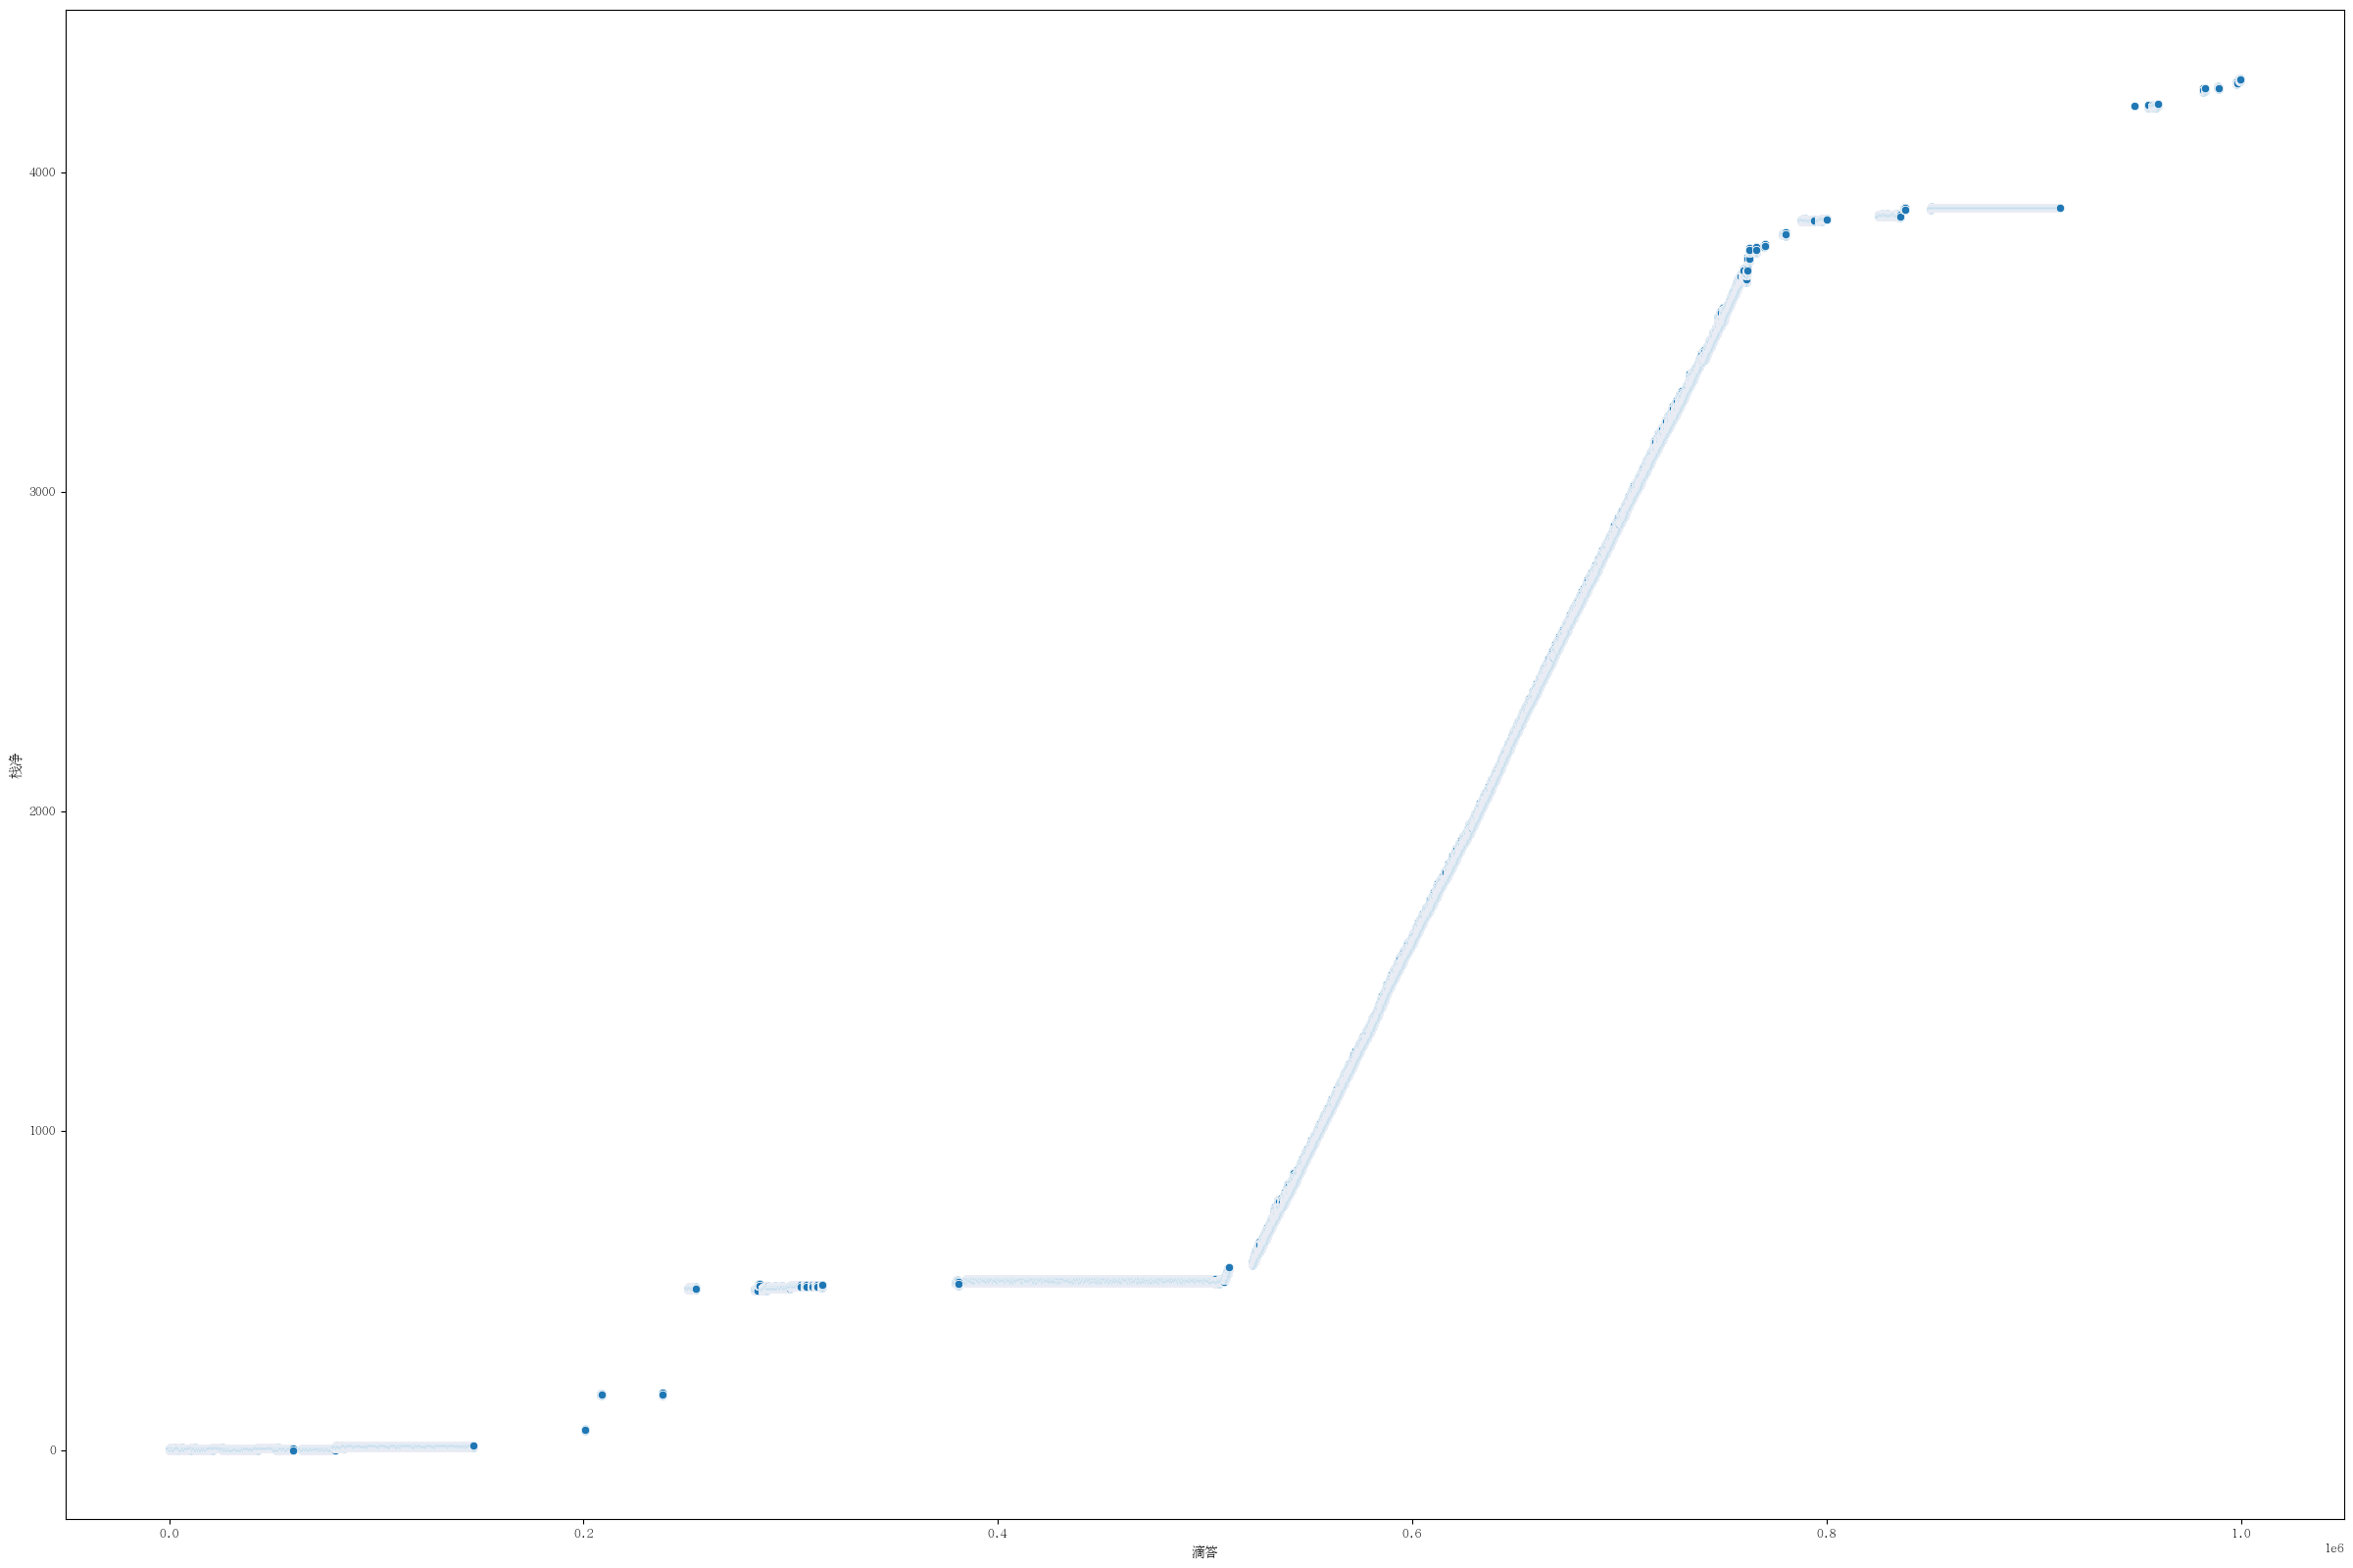

In [24]:
#调用次数前5的函数们
funcIdTop5=srt_g_fiFn_dfmm.funcId.values[:5]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcIdTop5 )  ]
print(dfmm.shape, len(funcIdTop5), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 50 (100, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

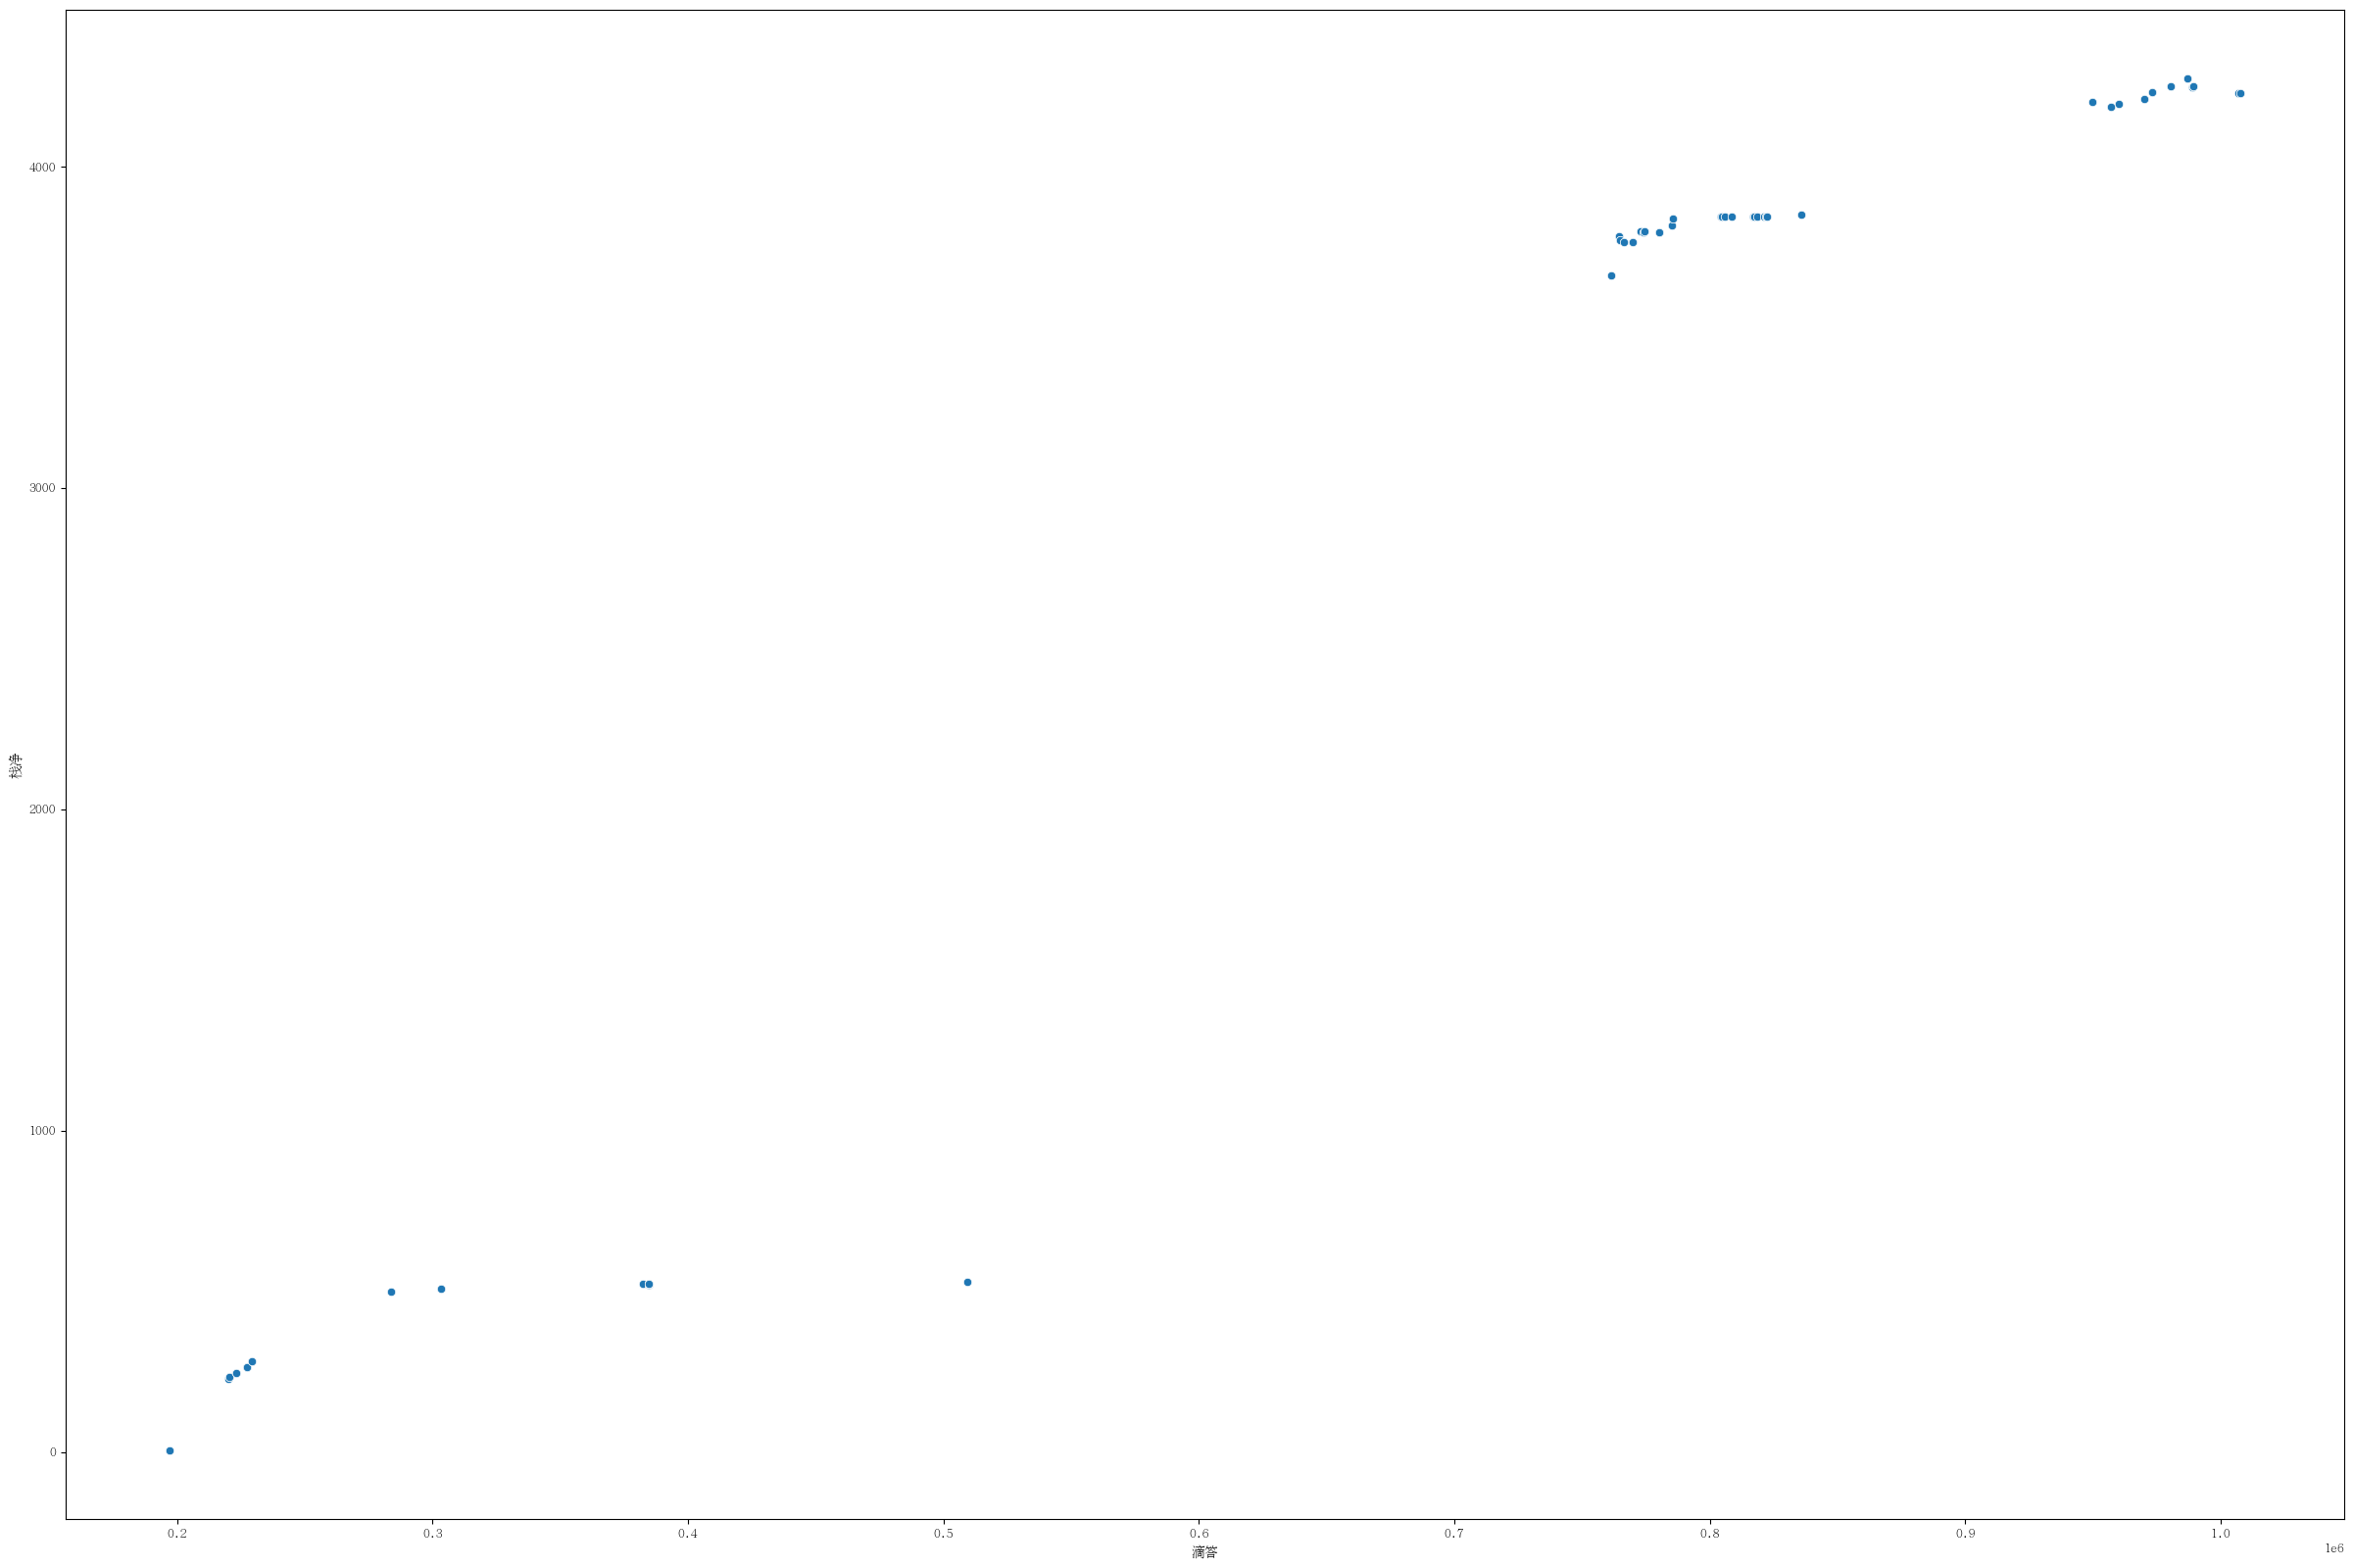

In [25]:
#调用次数倒数50的函数们
funcIdTail50=srt_g_fiFn_dfmm.funcId.values[-50:]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcIdTail50 )  ]
print(dfmm.shape, len(funcIdTail50), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

In [26]:

funcIdCnt=len(srt_g_fiFn_dfmm.funcId)
funcIdCnt

2784

(1014494, 20) 2784 1392 50 (504, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

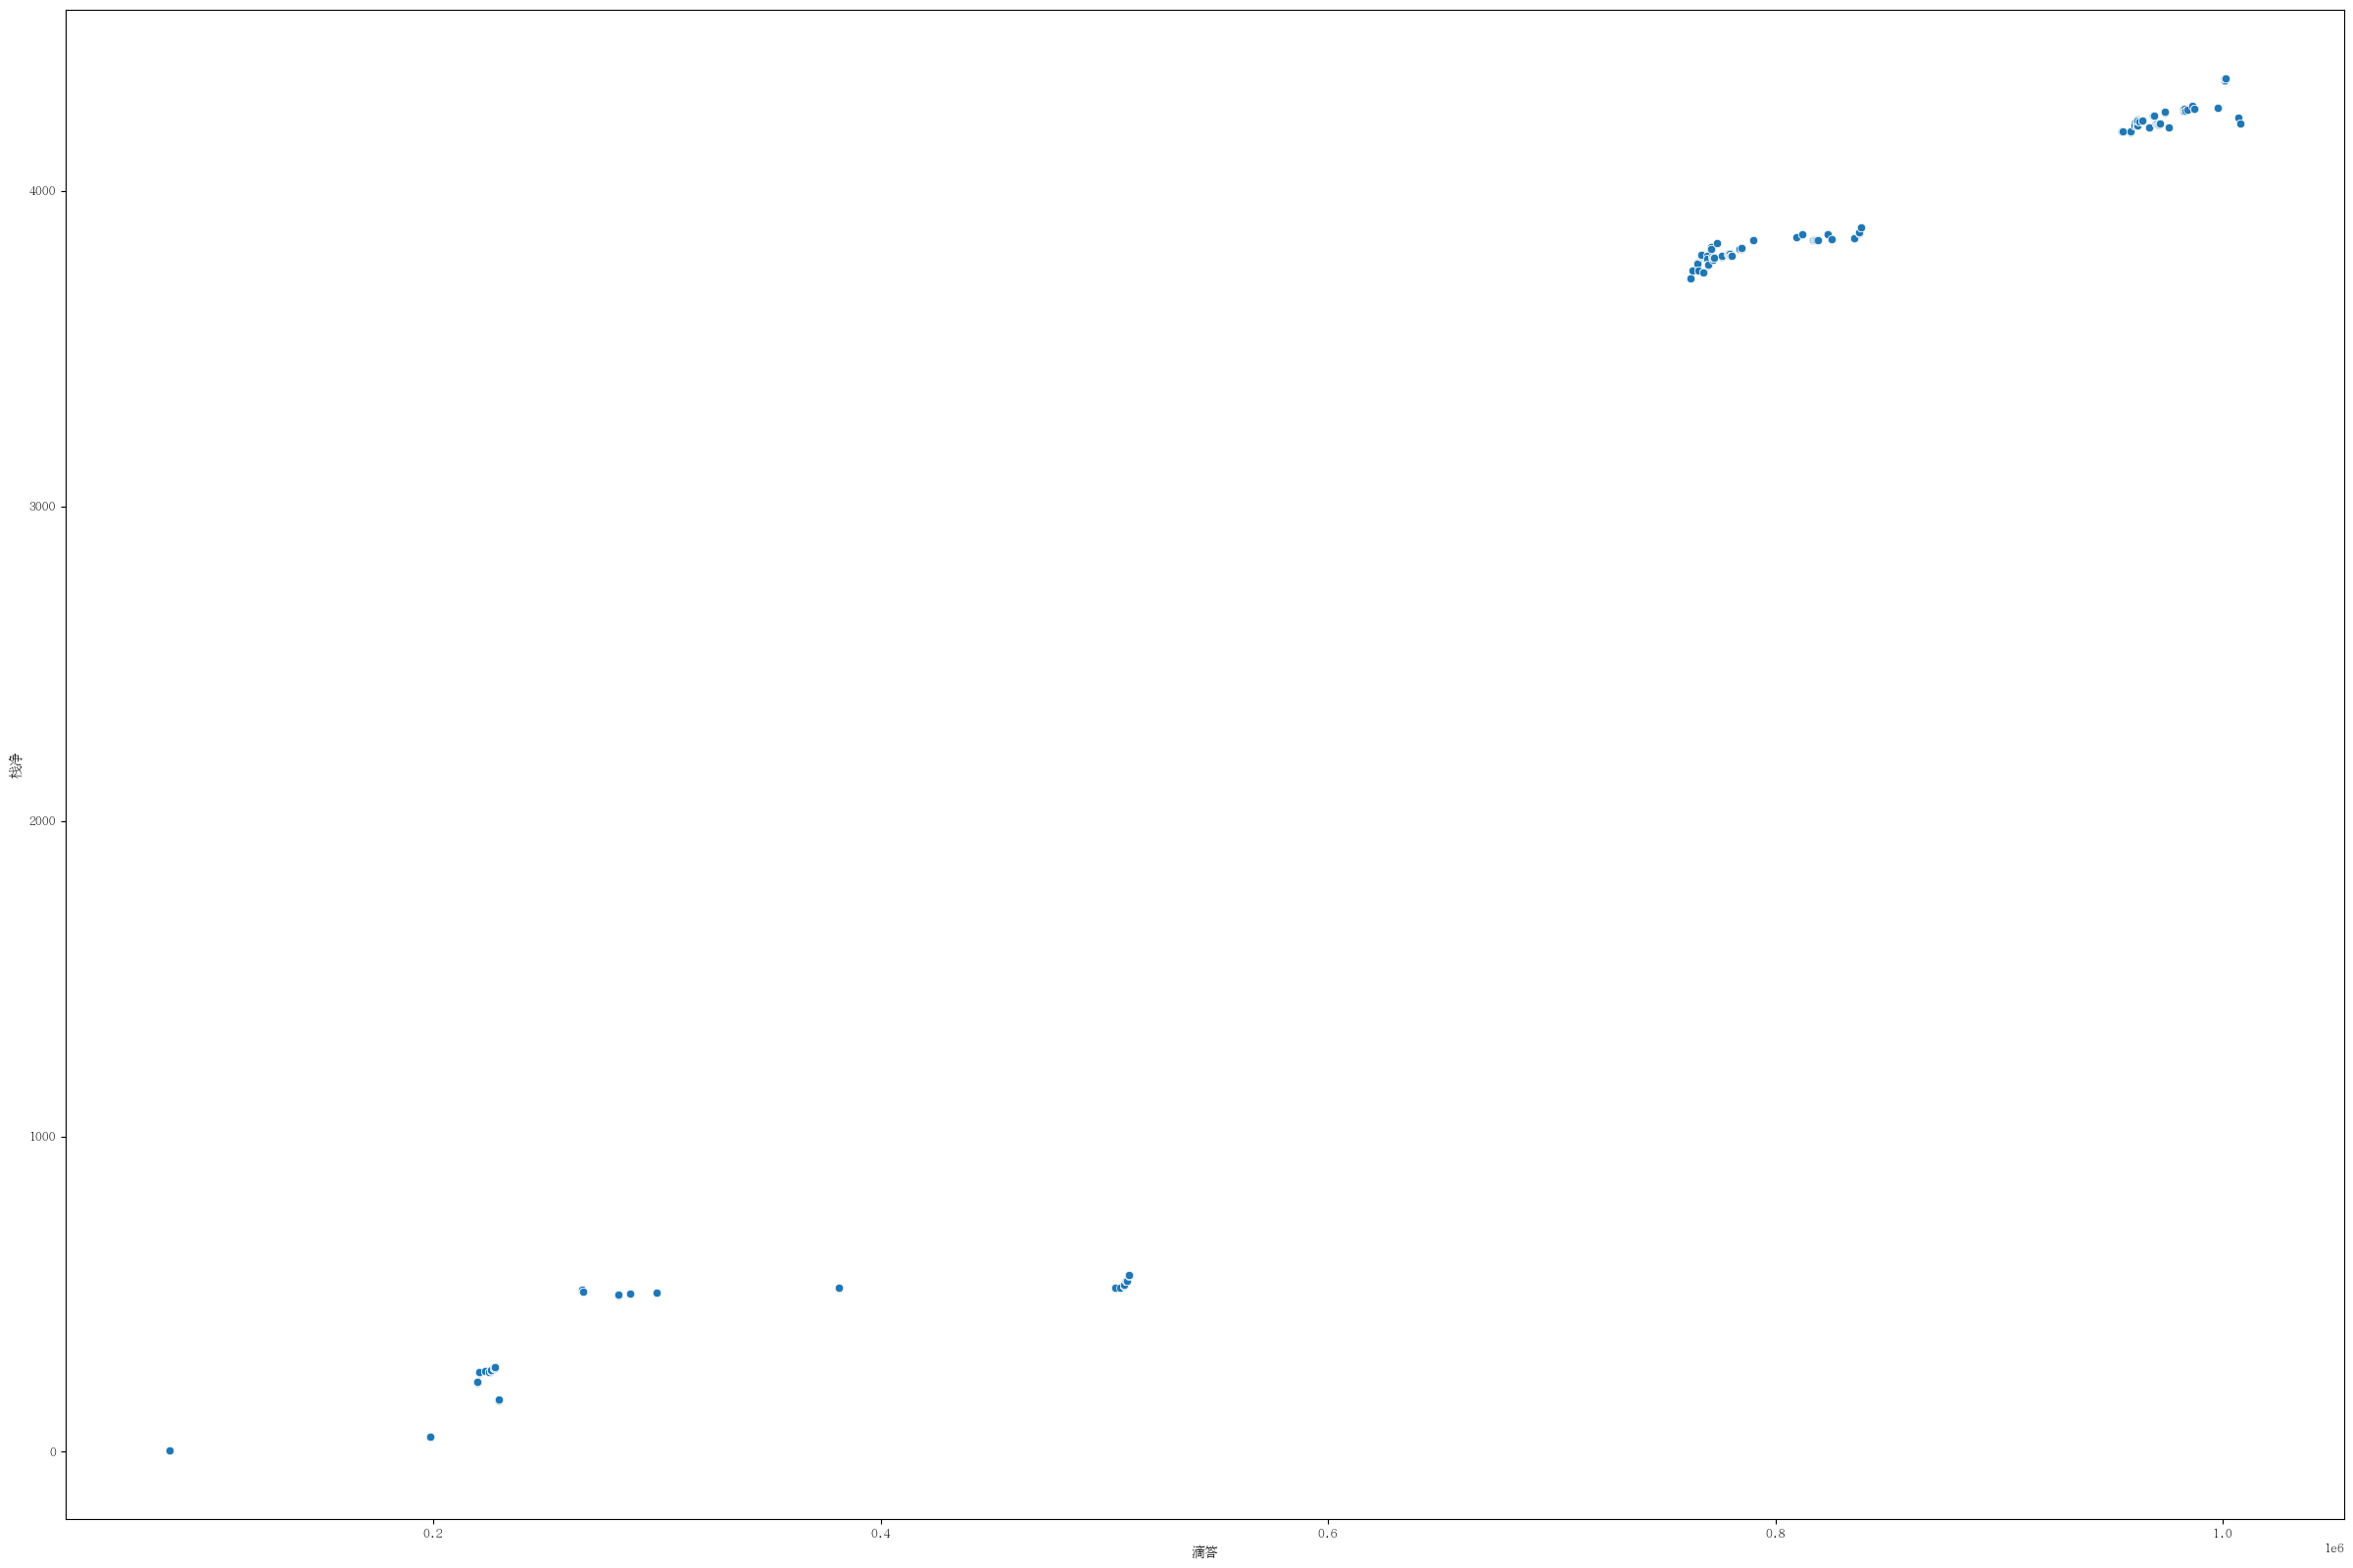

In [27]:
#调用次数中间50的函数们
boundary=funcIdCnt//2
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 928 50 (1242, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

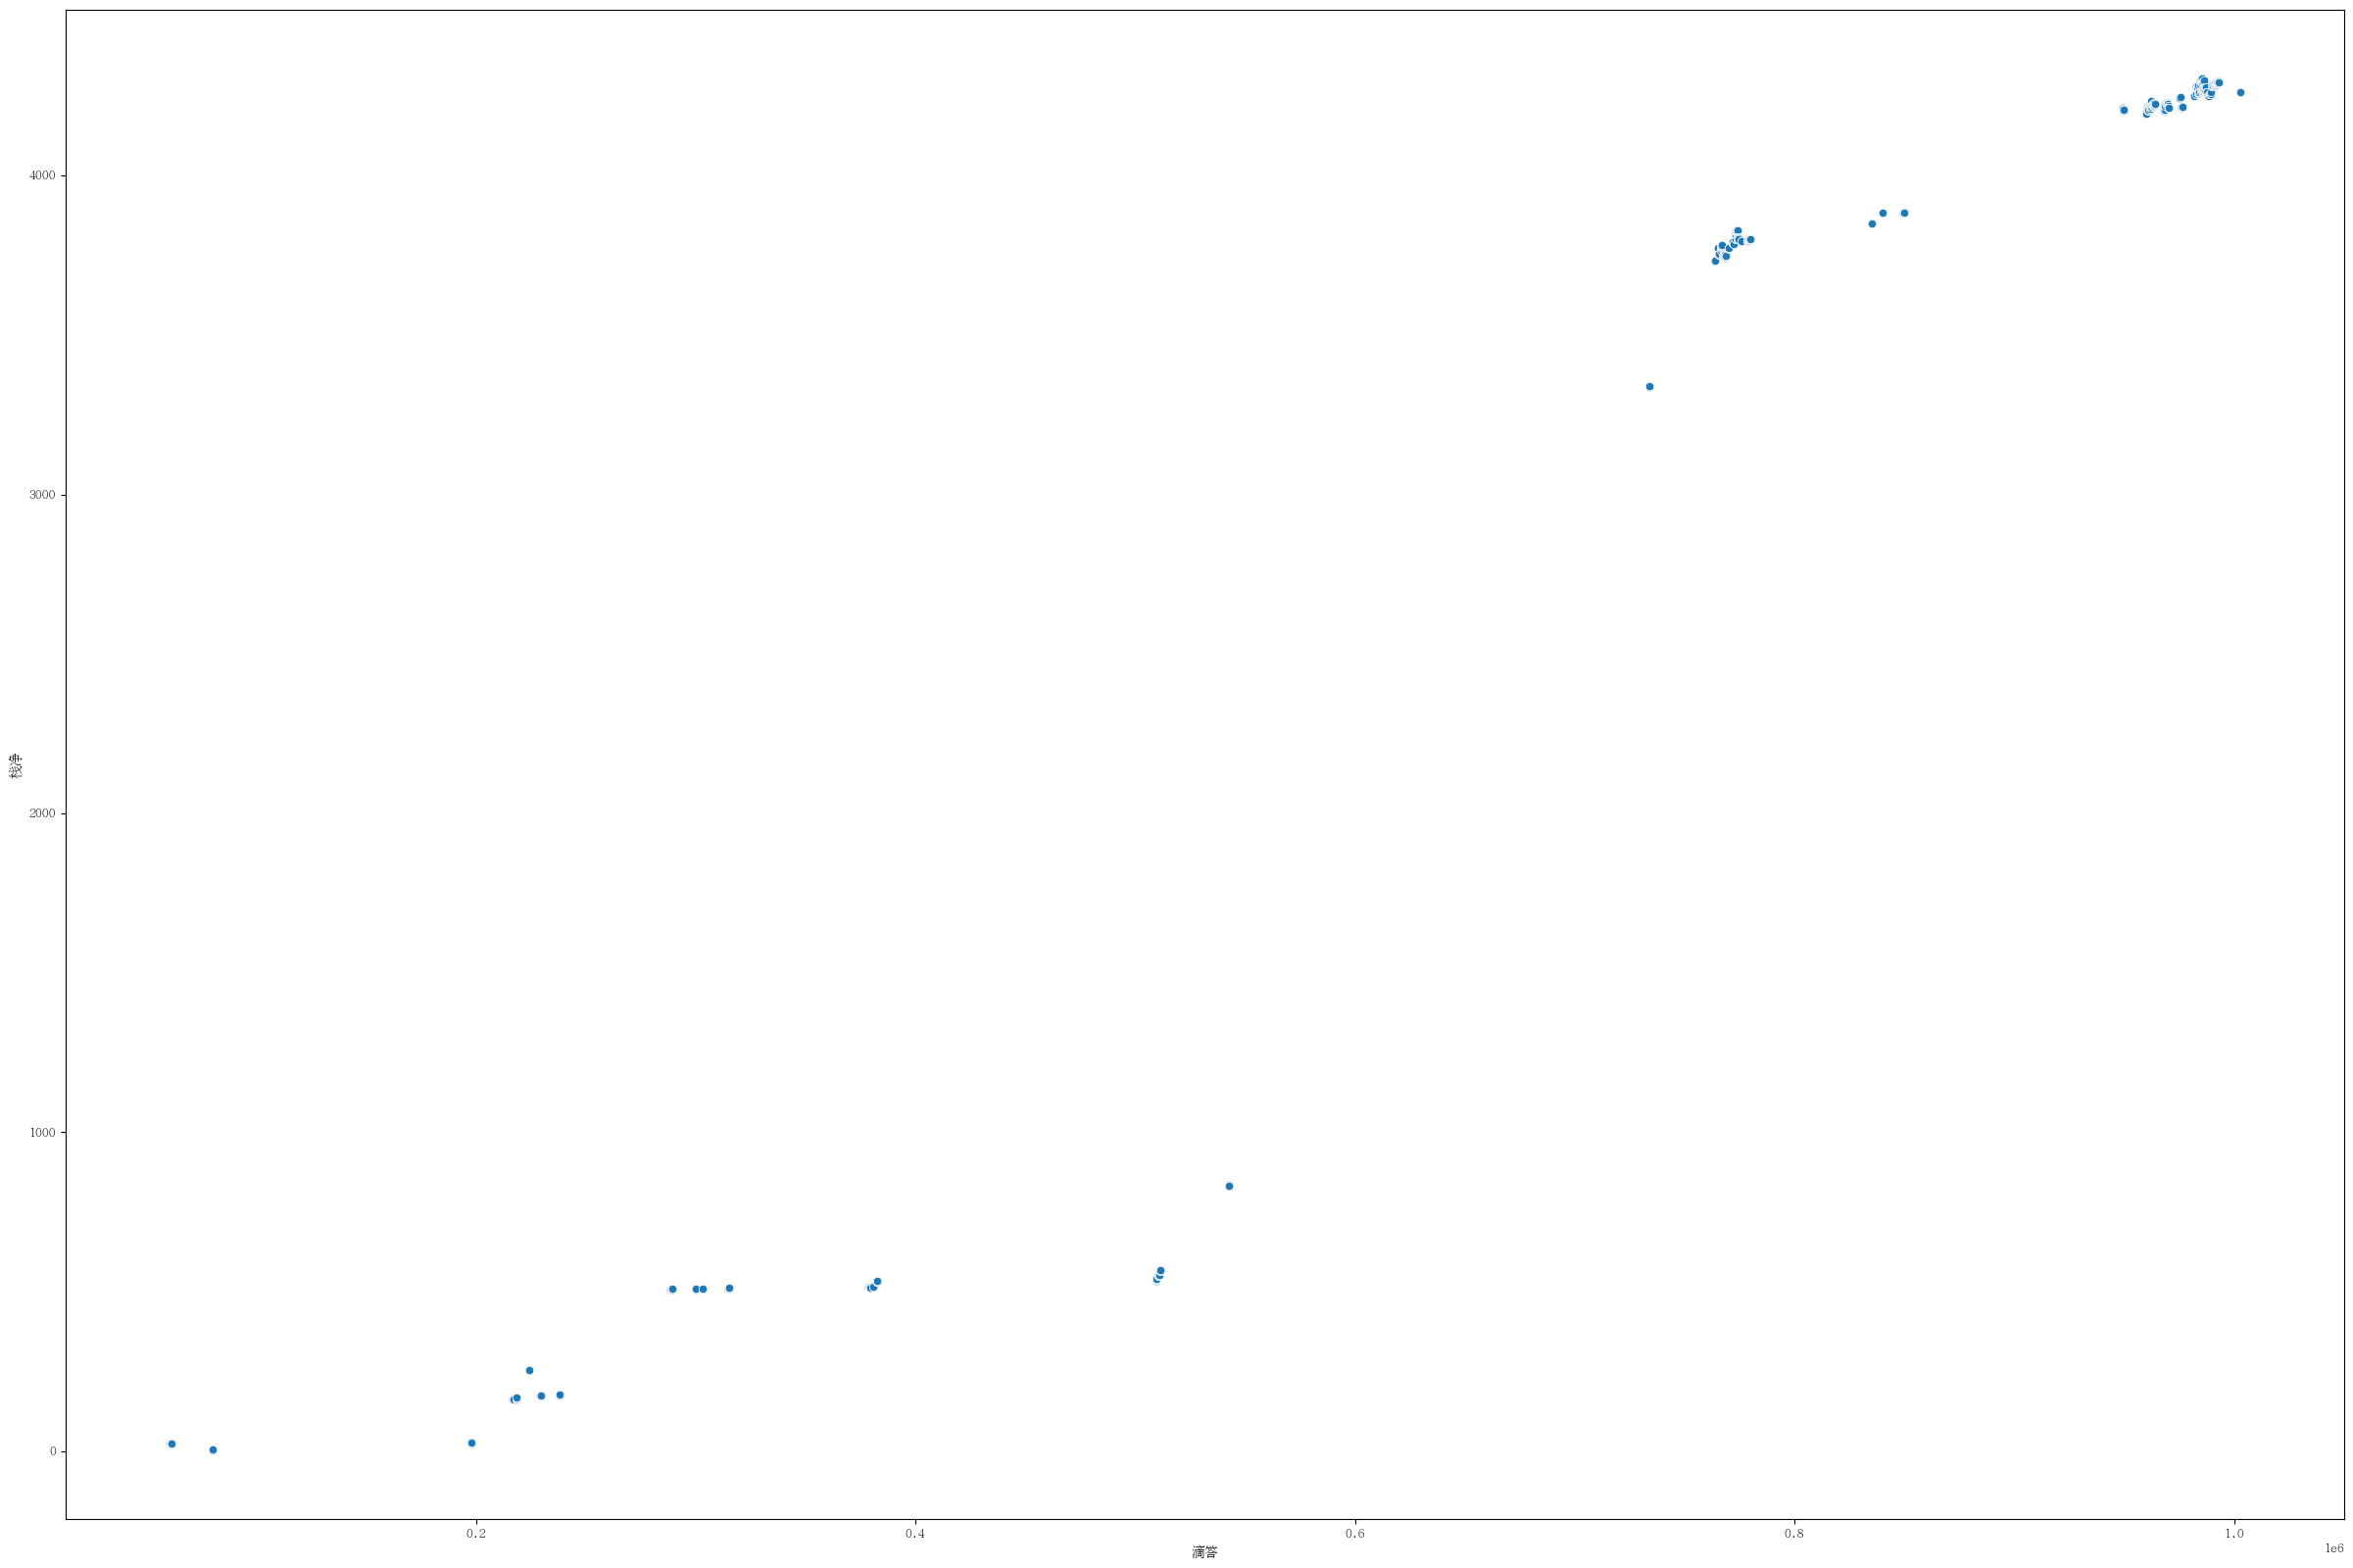

In [28]:
#调用次数前1/3处附近50的函数们
boundary=funcIdCnt//3
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 696 50 (1935, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

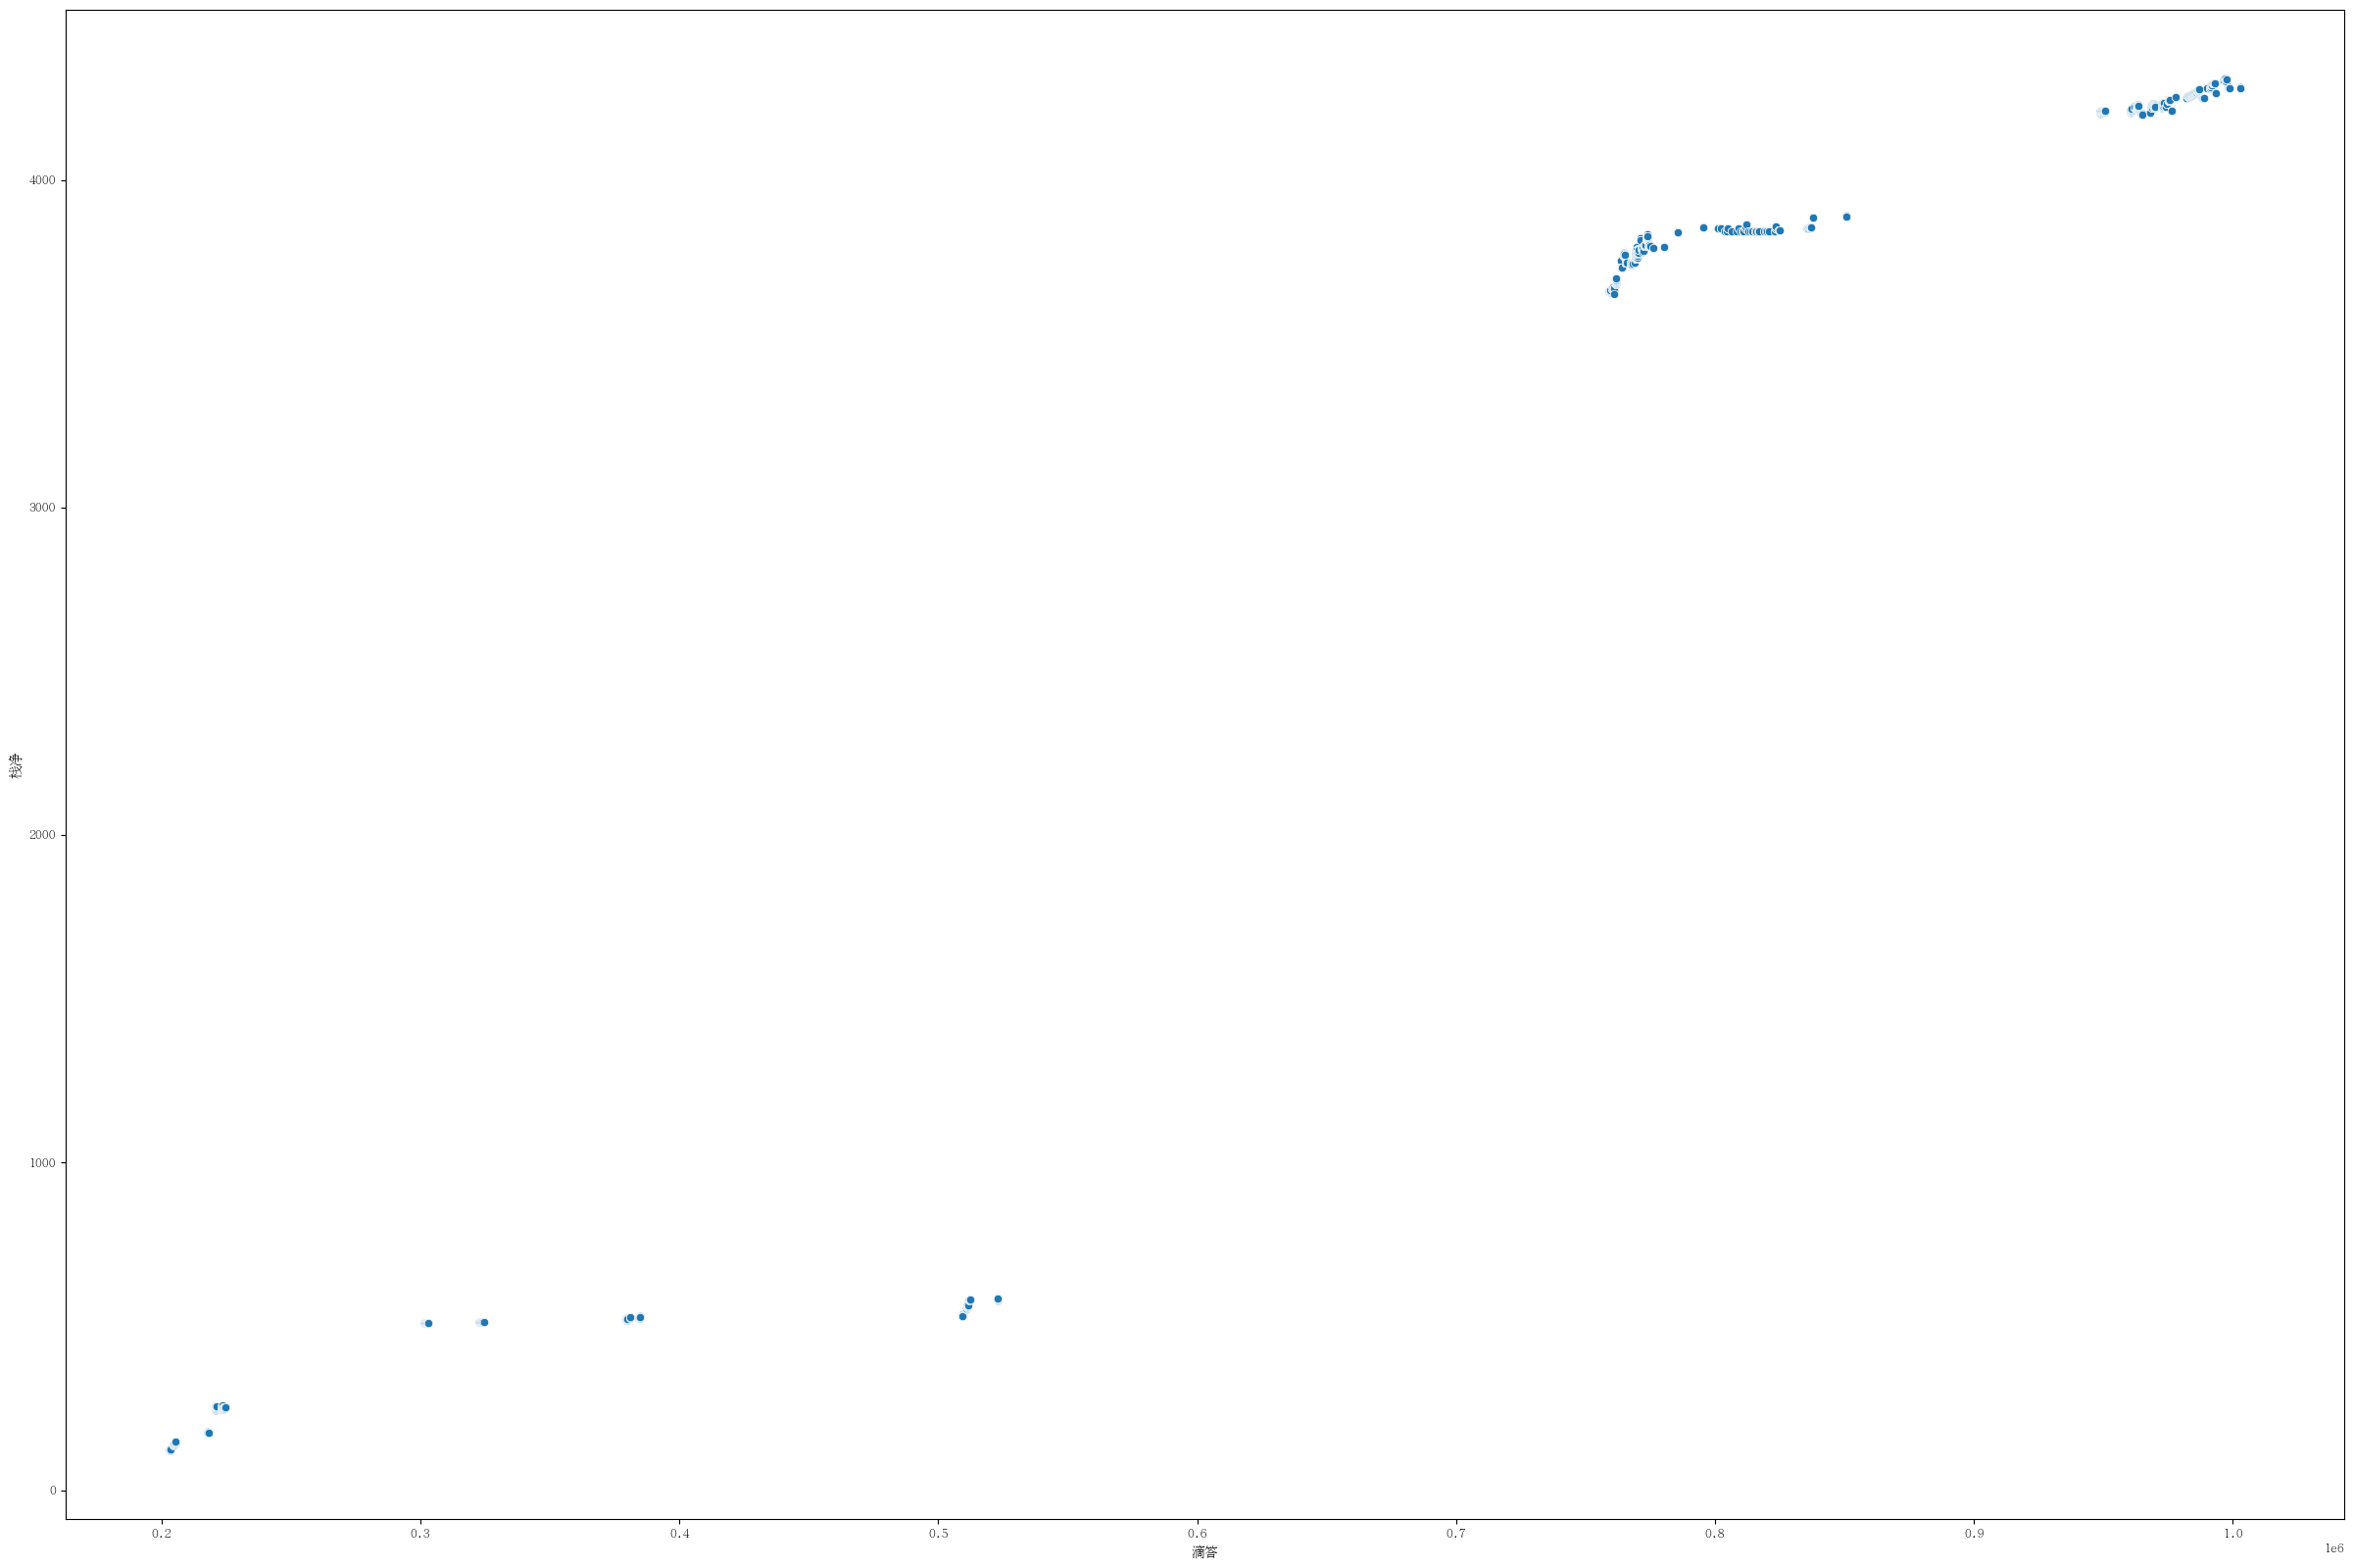

In [29]:
#调用次数前1/4处附近50的函数们
boundary=funcIdCnt//4
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 556 50 (2911, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

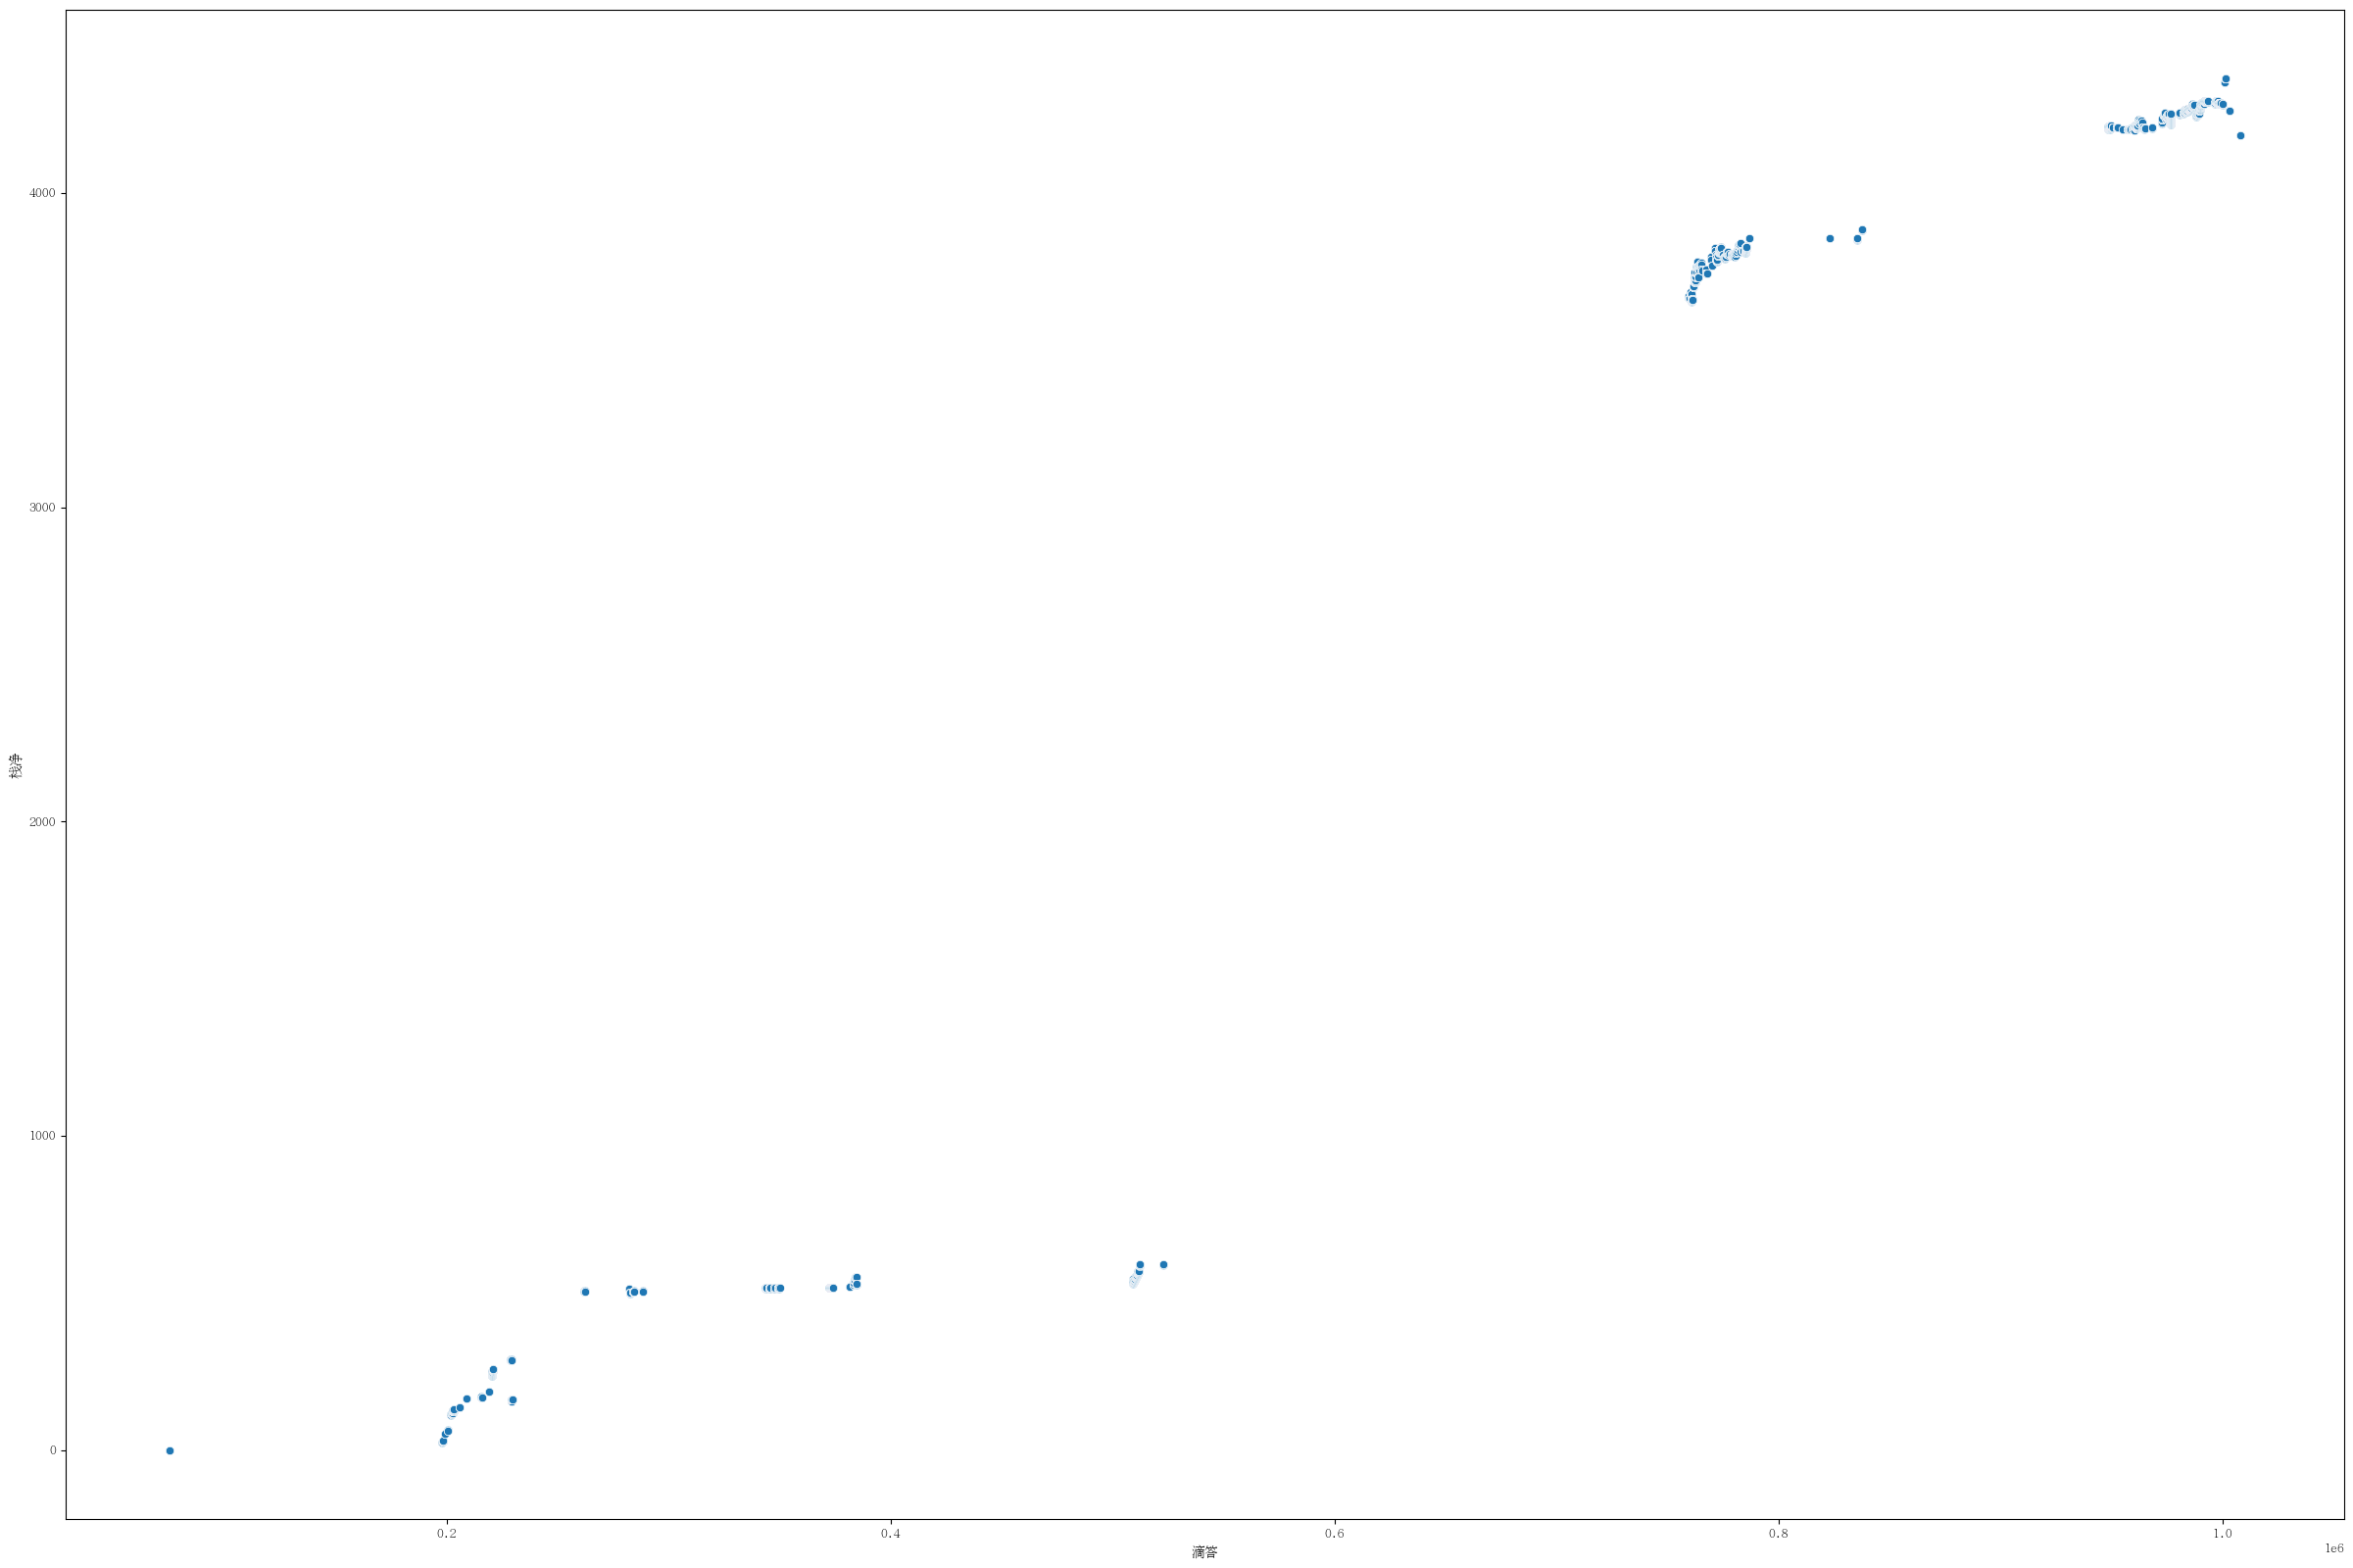

In [30]:
#调用次数前1/5处附近50的函数们
boundary=funcIdCnt//5
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 464 50 (3763, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

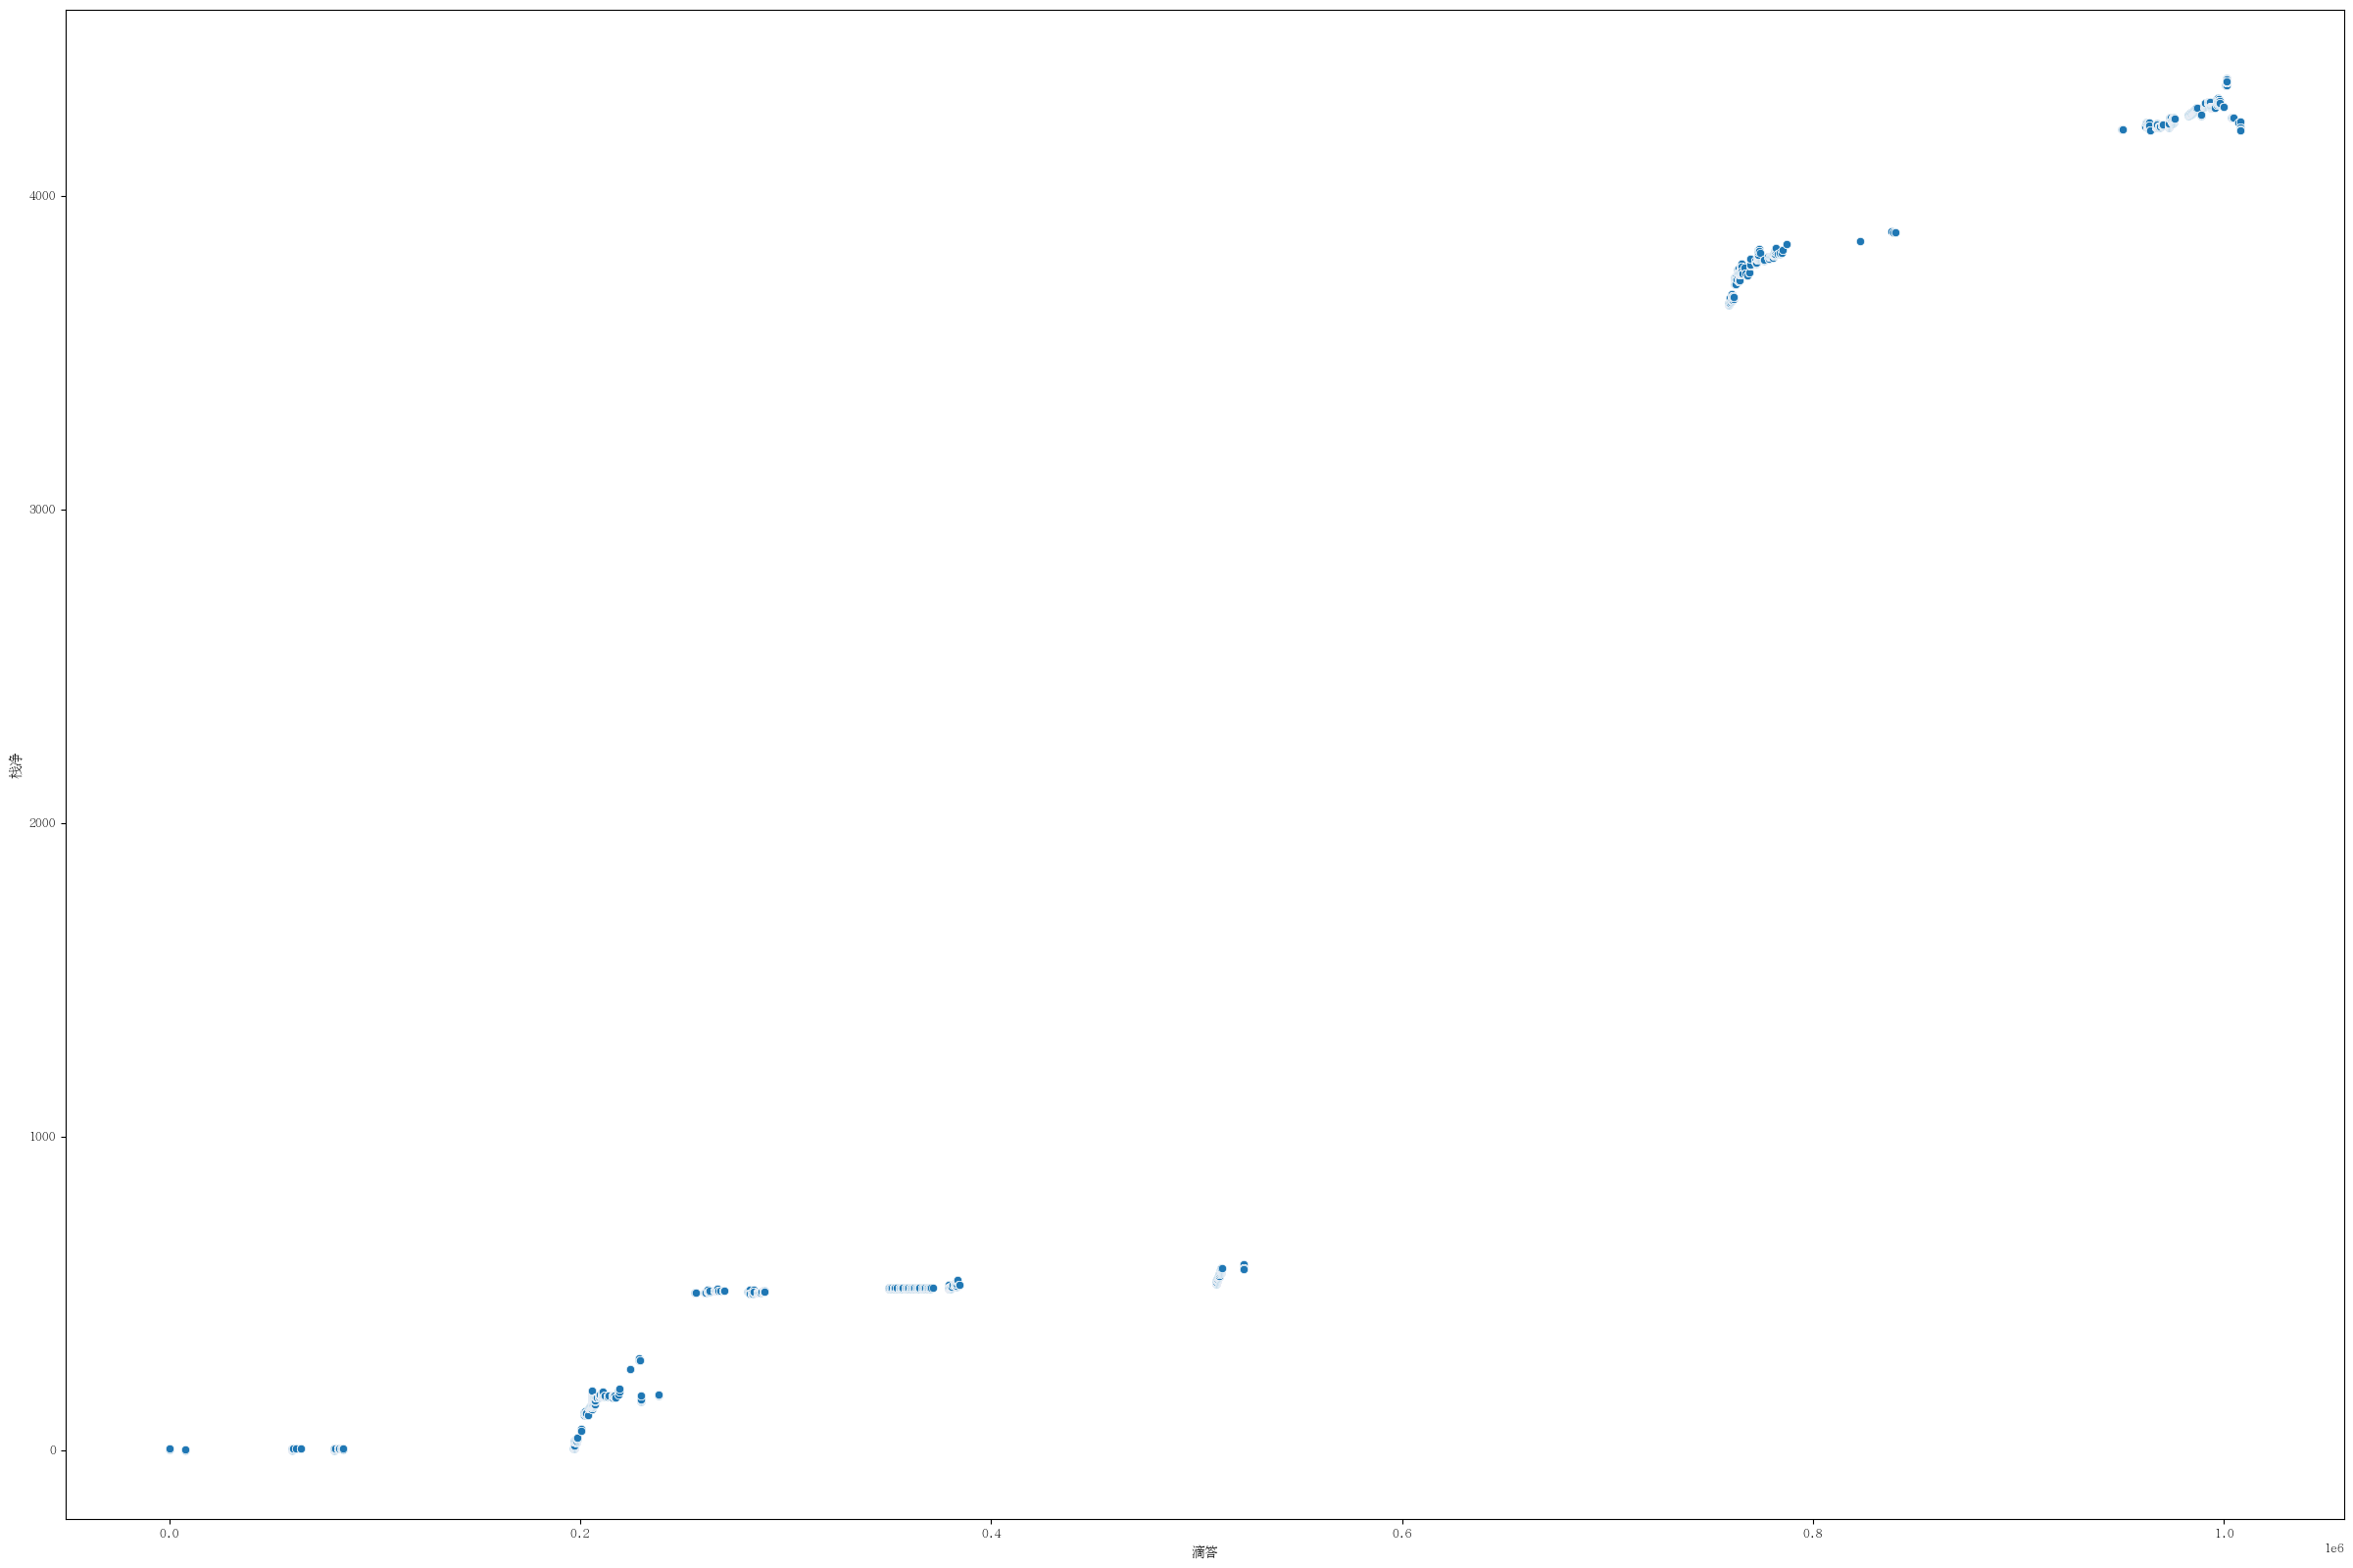

In [31]:
#调用次数前1/6处附近50的函数们
boundary=funcIdCnt//6
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 397 50 (4870, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

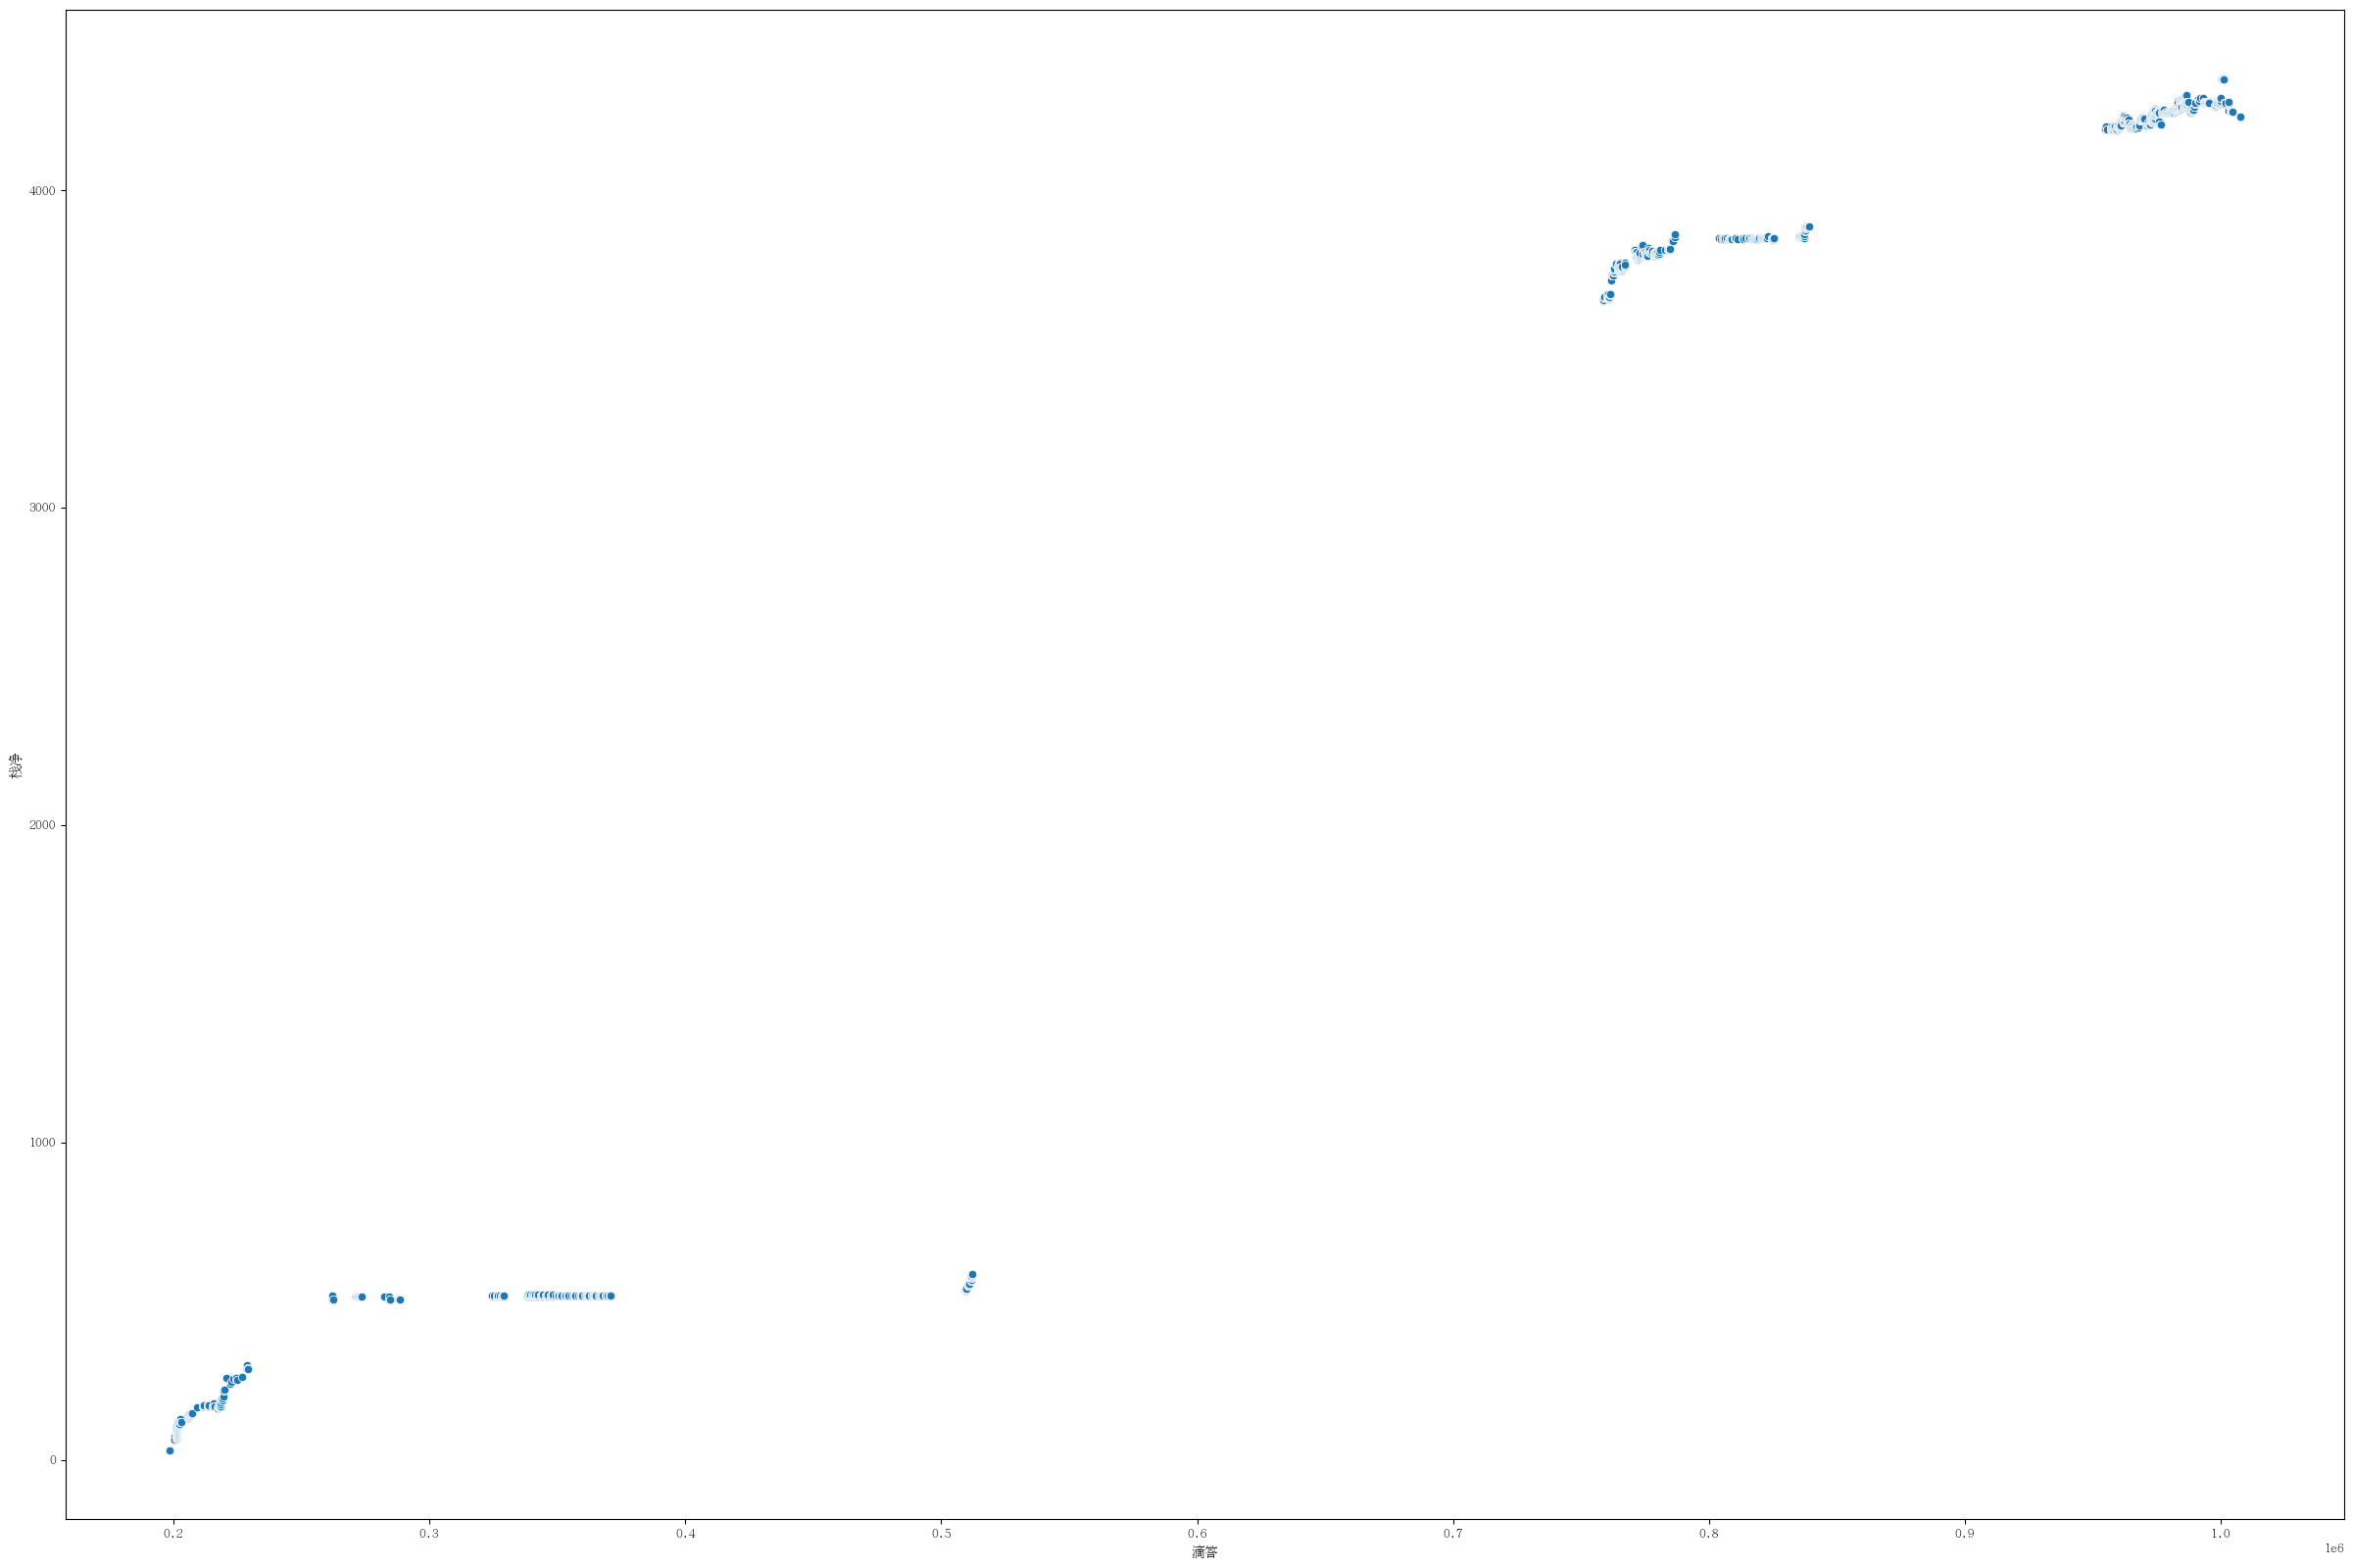

In [32]:
#调用次数前1/7处附近50的函数们
boundary=funcIdCnt//7
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 348 50 (5975, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

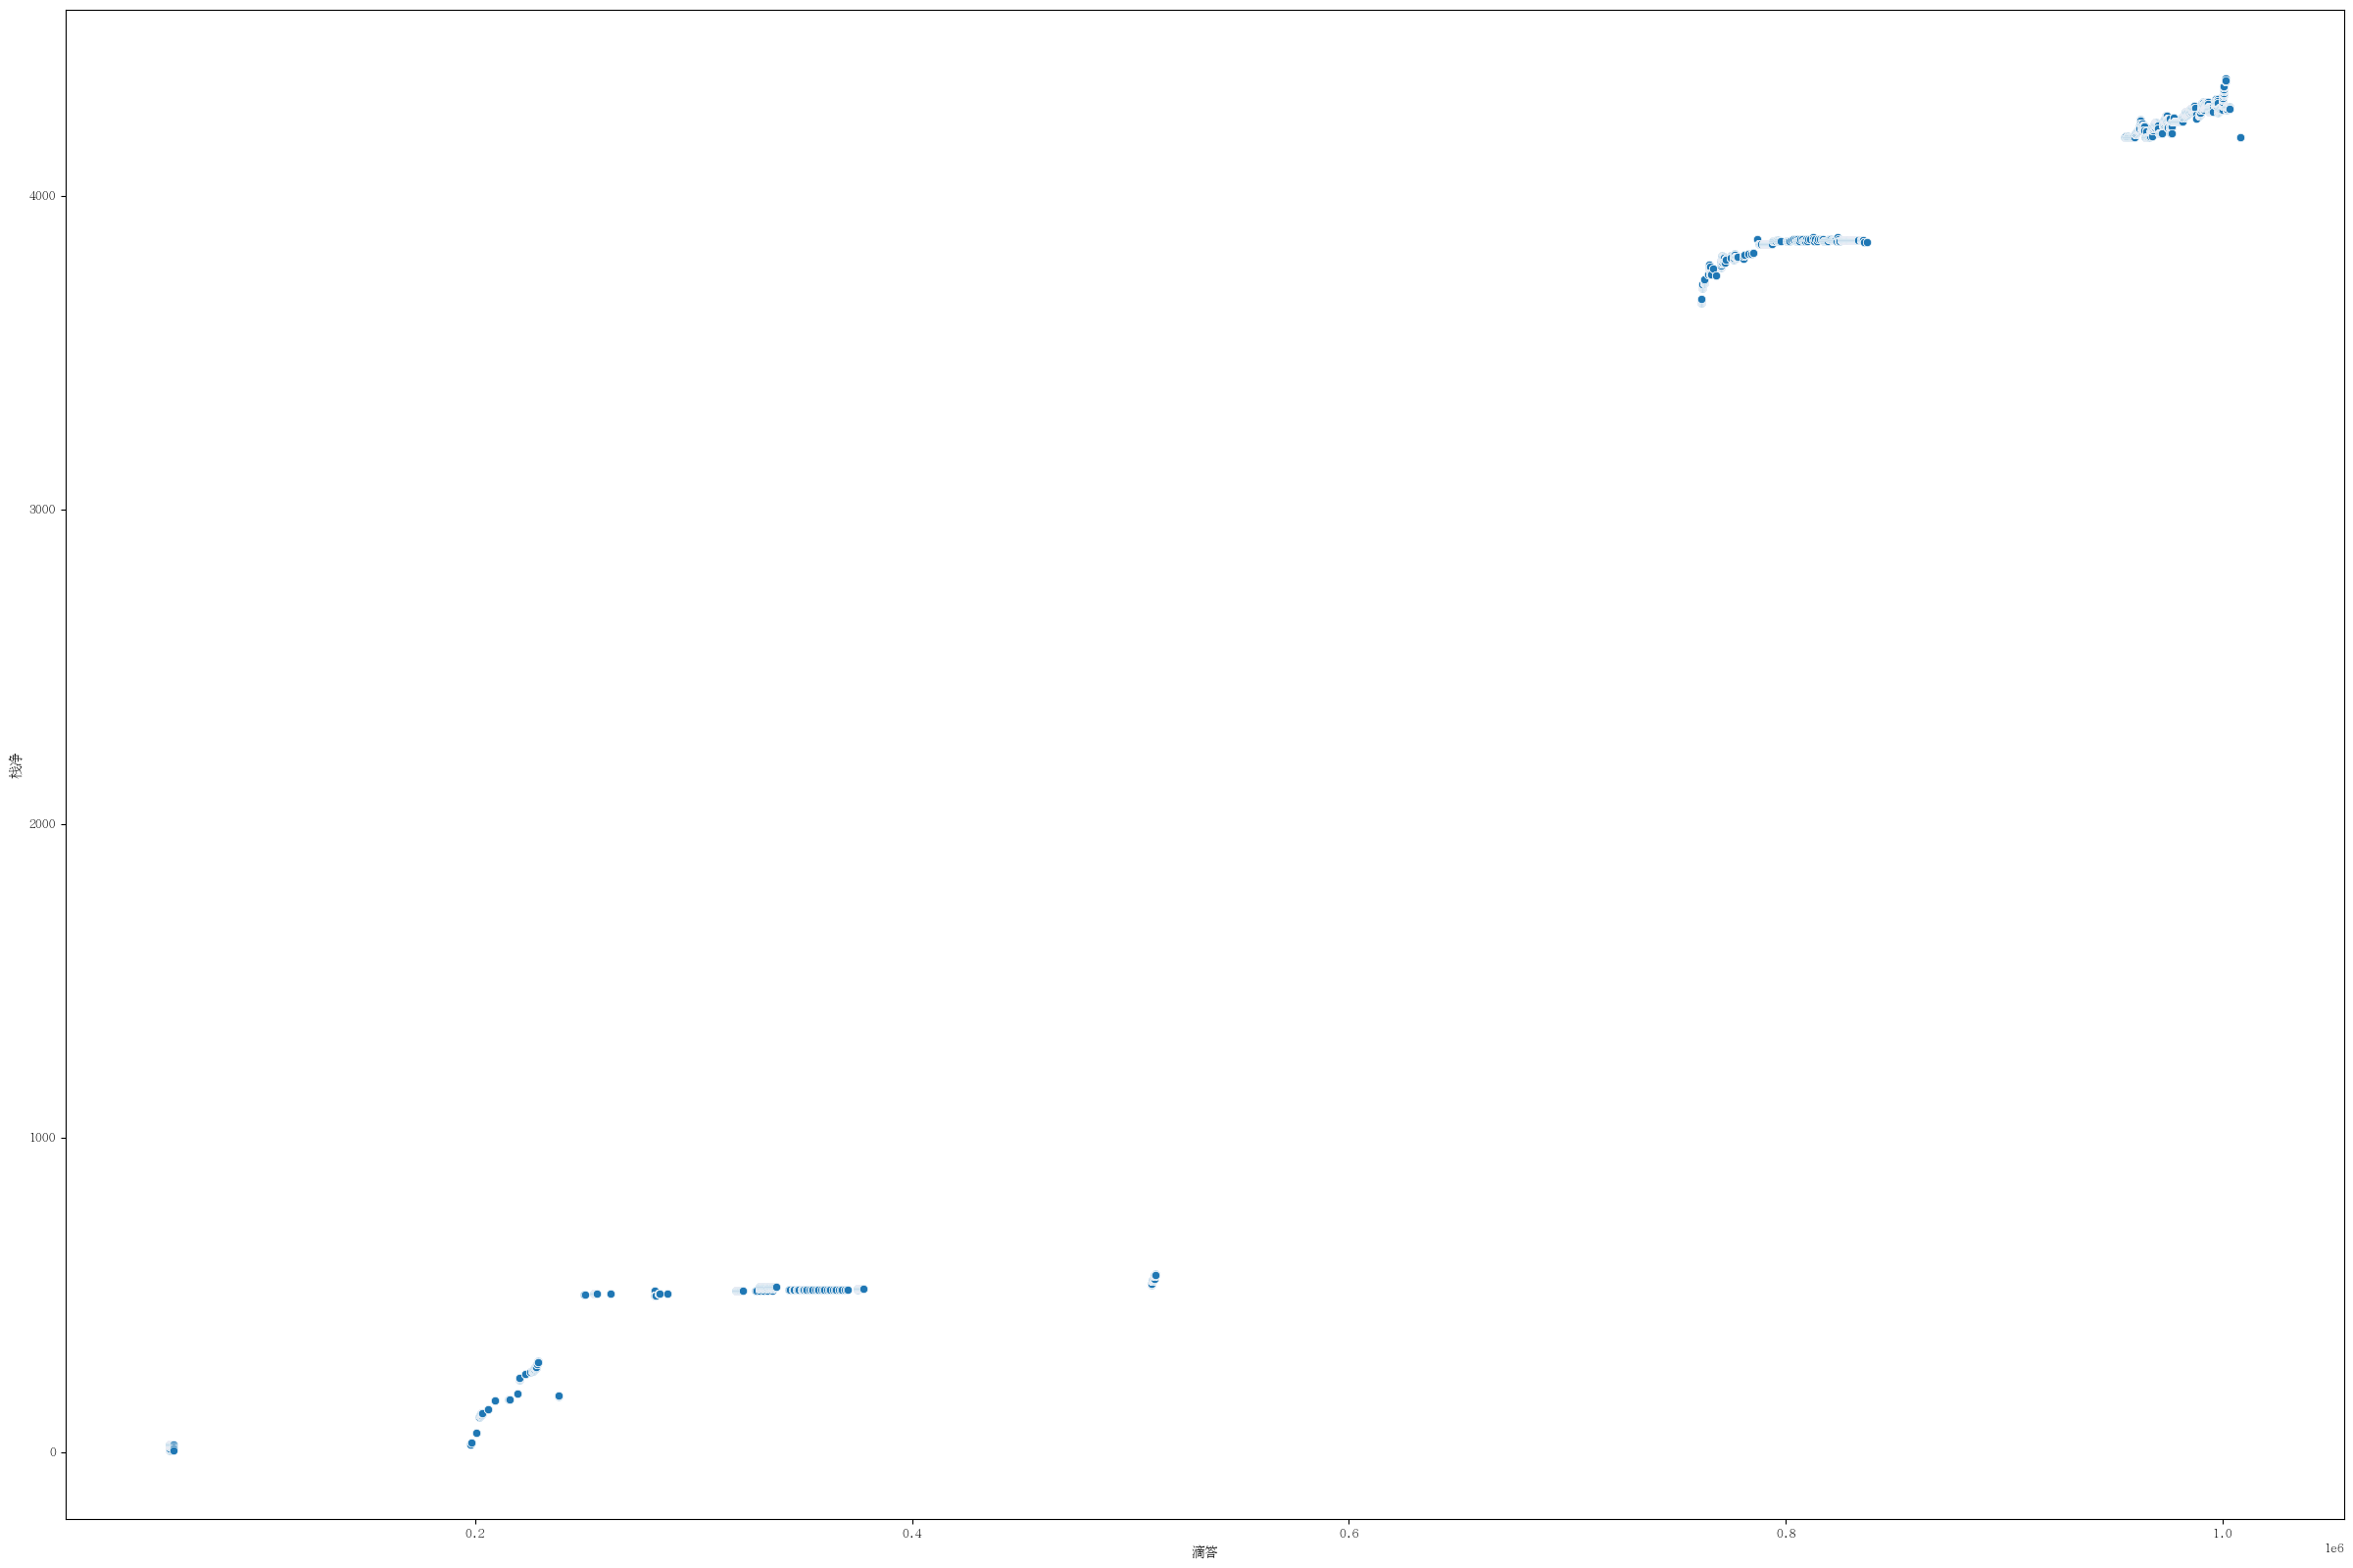

In [33]:
#调用次数前1/8处附近50的函数们
boundary=funcIdCnt//8
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 309 50 (7160, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

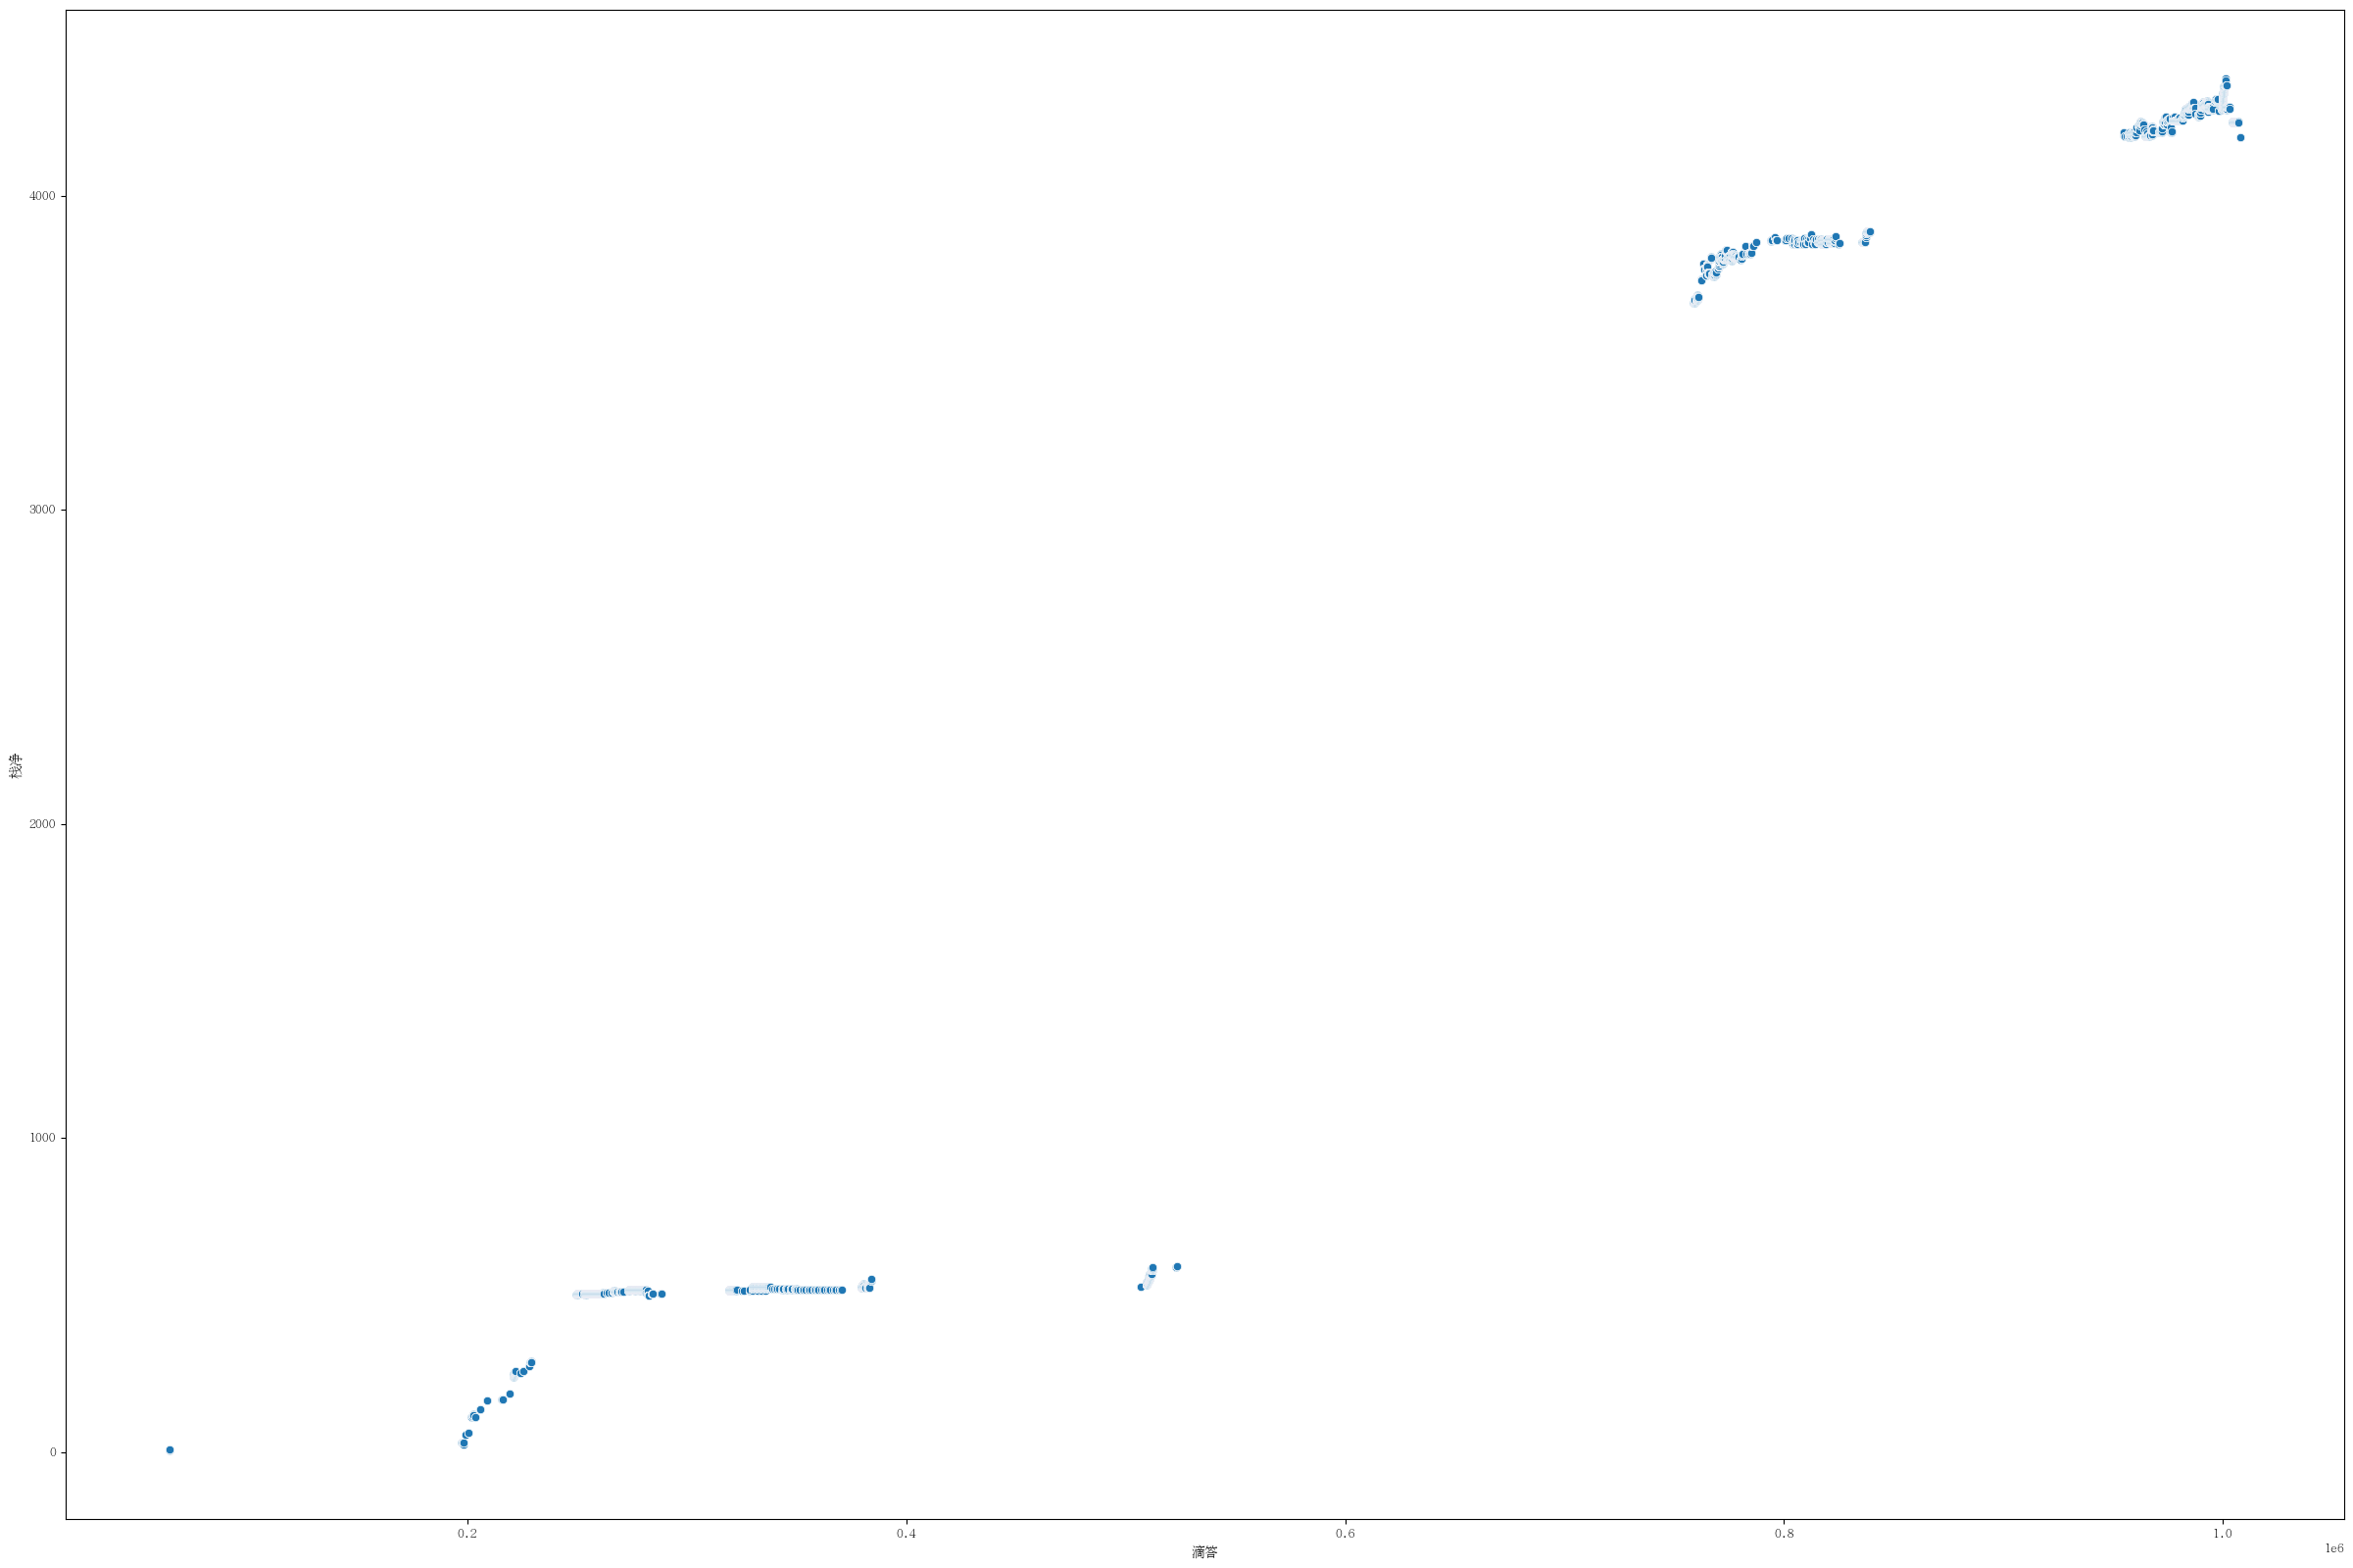

In [34]:
#调用次数前1/9处附近50的函数们
boundary=funcIdCnt//9
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 278 50 (8487, 20)


486                     llvm::MCAssembler::registerSymbol
1671                  clang::PragmaNamespace::FindHandler
2173                    llvm::MCAsmLayout::layoutFragment
1826                                           initialize
1898                     llvm::ManagedStaticBase::destroy
1180                  llvm::opt::ArgList::getAllArgValues
1697                 llvm::PMDataManager::dumpRequiredSet
1165                llvm::PMDataManager::dumpPreservedSet
148                      llvm::PMDataManager::dumpUsedSet
837                     clang::PragmaNamespace::AddPragma
2307                                     ApplyFeatureFlag
1135                 llvm::SmallVectorBase::mallocForGrow
2244                                               getInt
83                        llvm::TargetPassConfig::addPass
662                                               isInput
1105                                    GetAutoSenseRadix
2290               llvm::MCAssembler::computeFragmentSize
1083          

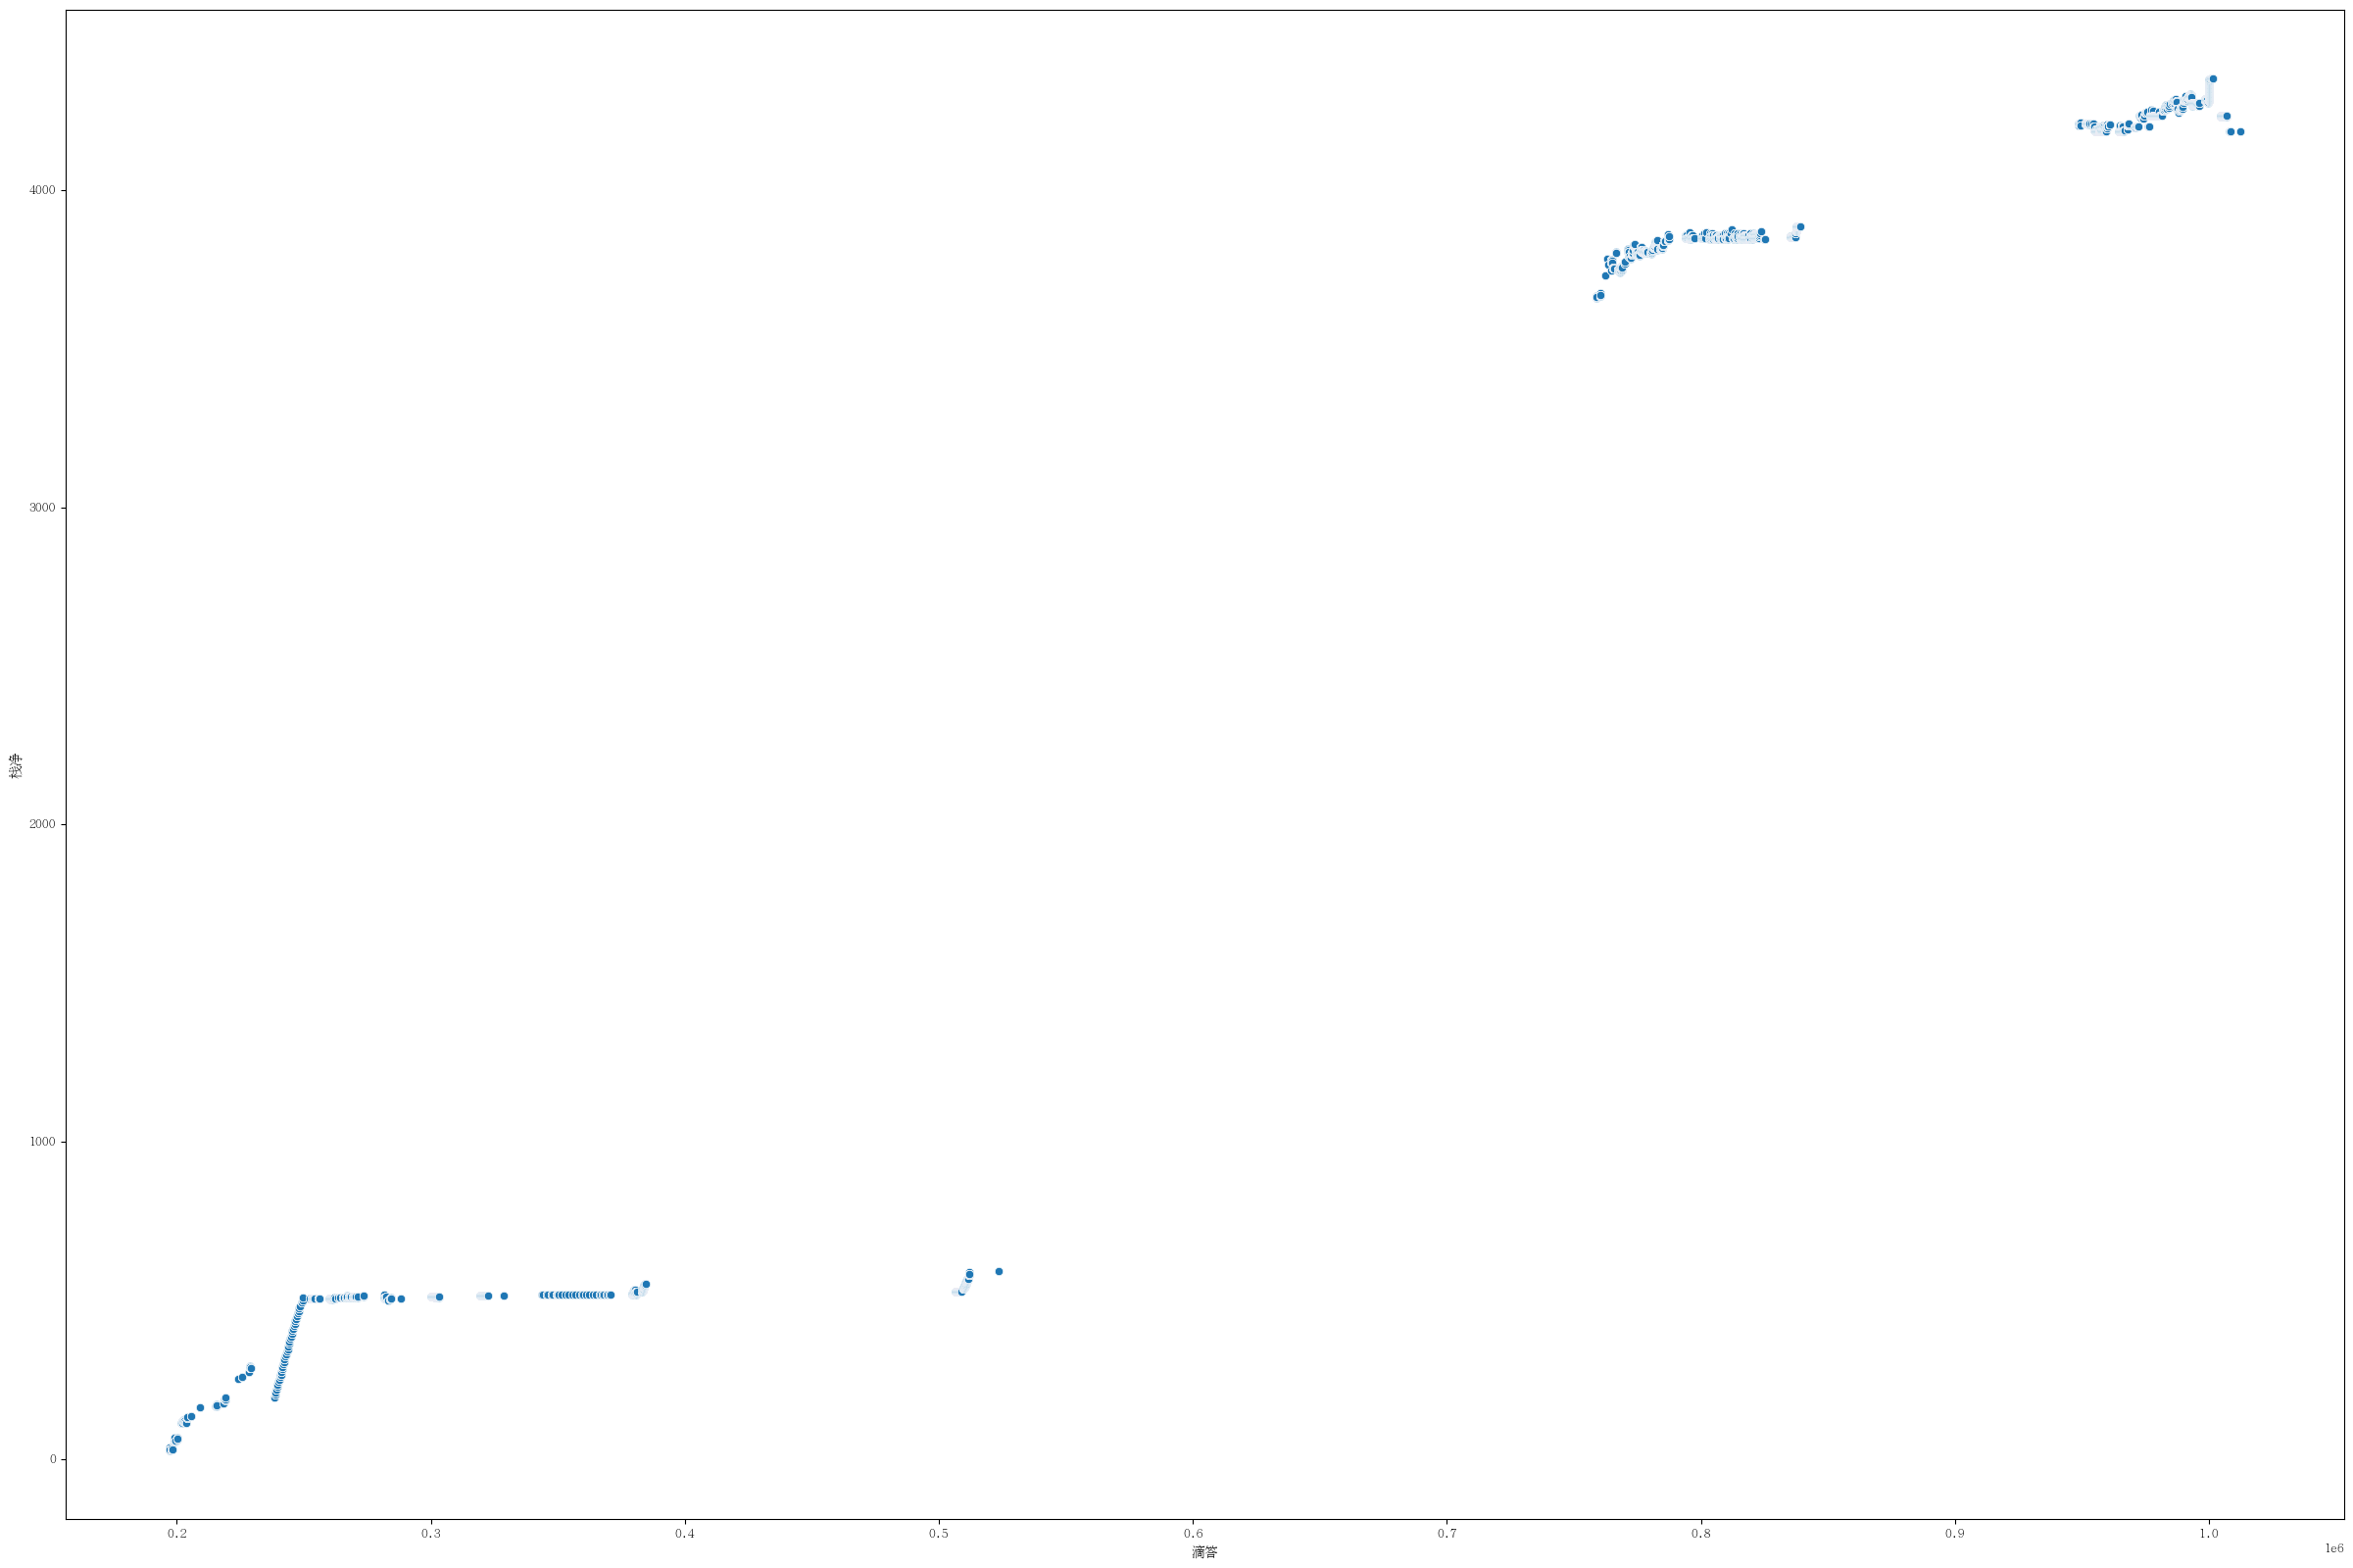

In [35]:
#调用次数前1/10处附近50的函数们
boundary=funcIdCnt//10
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)


srt_g_fiFn_dfmm[  srt_g_fiFn_dfmm['funcId'].isin(funcId_ls)  ]  ['funcName']

(1014494, 20) 2784 253 50 (9919, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

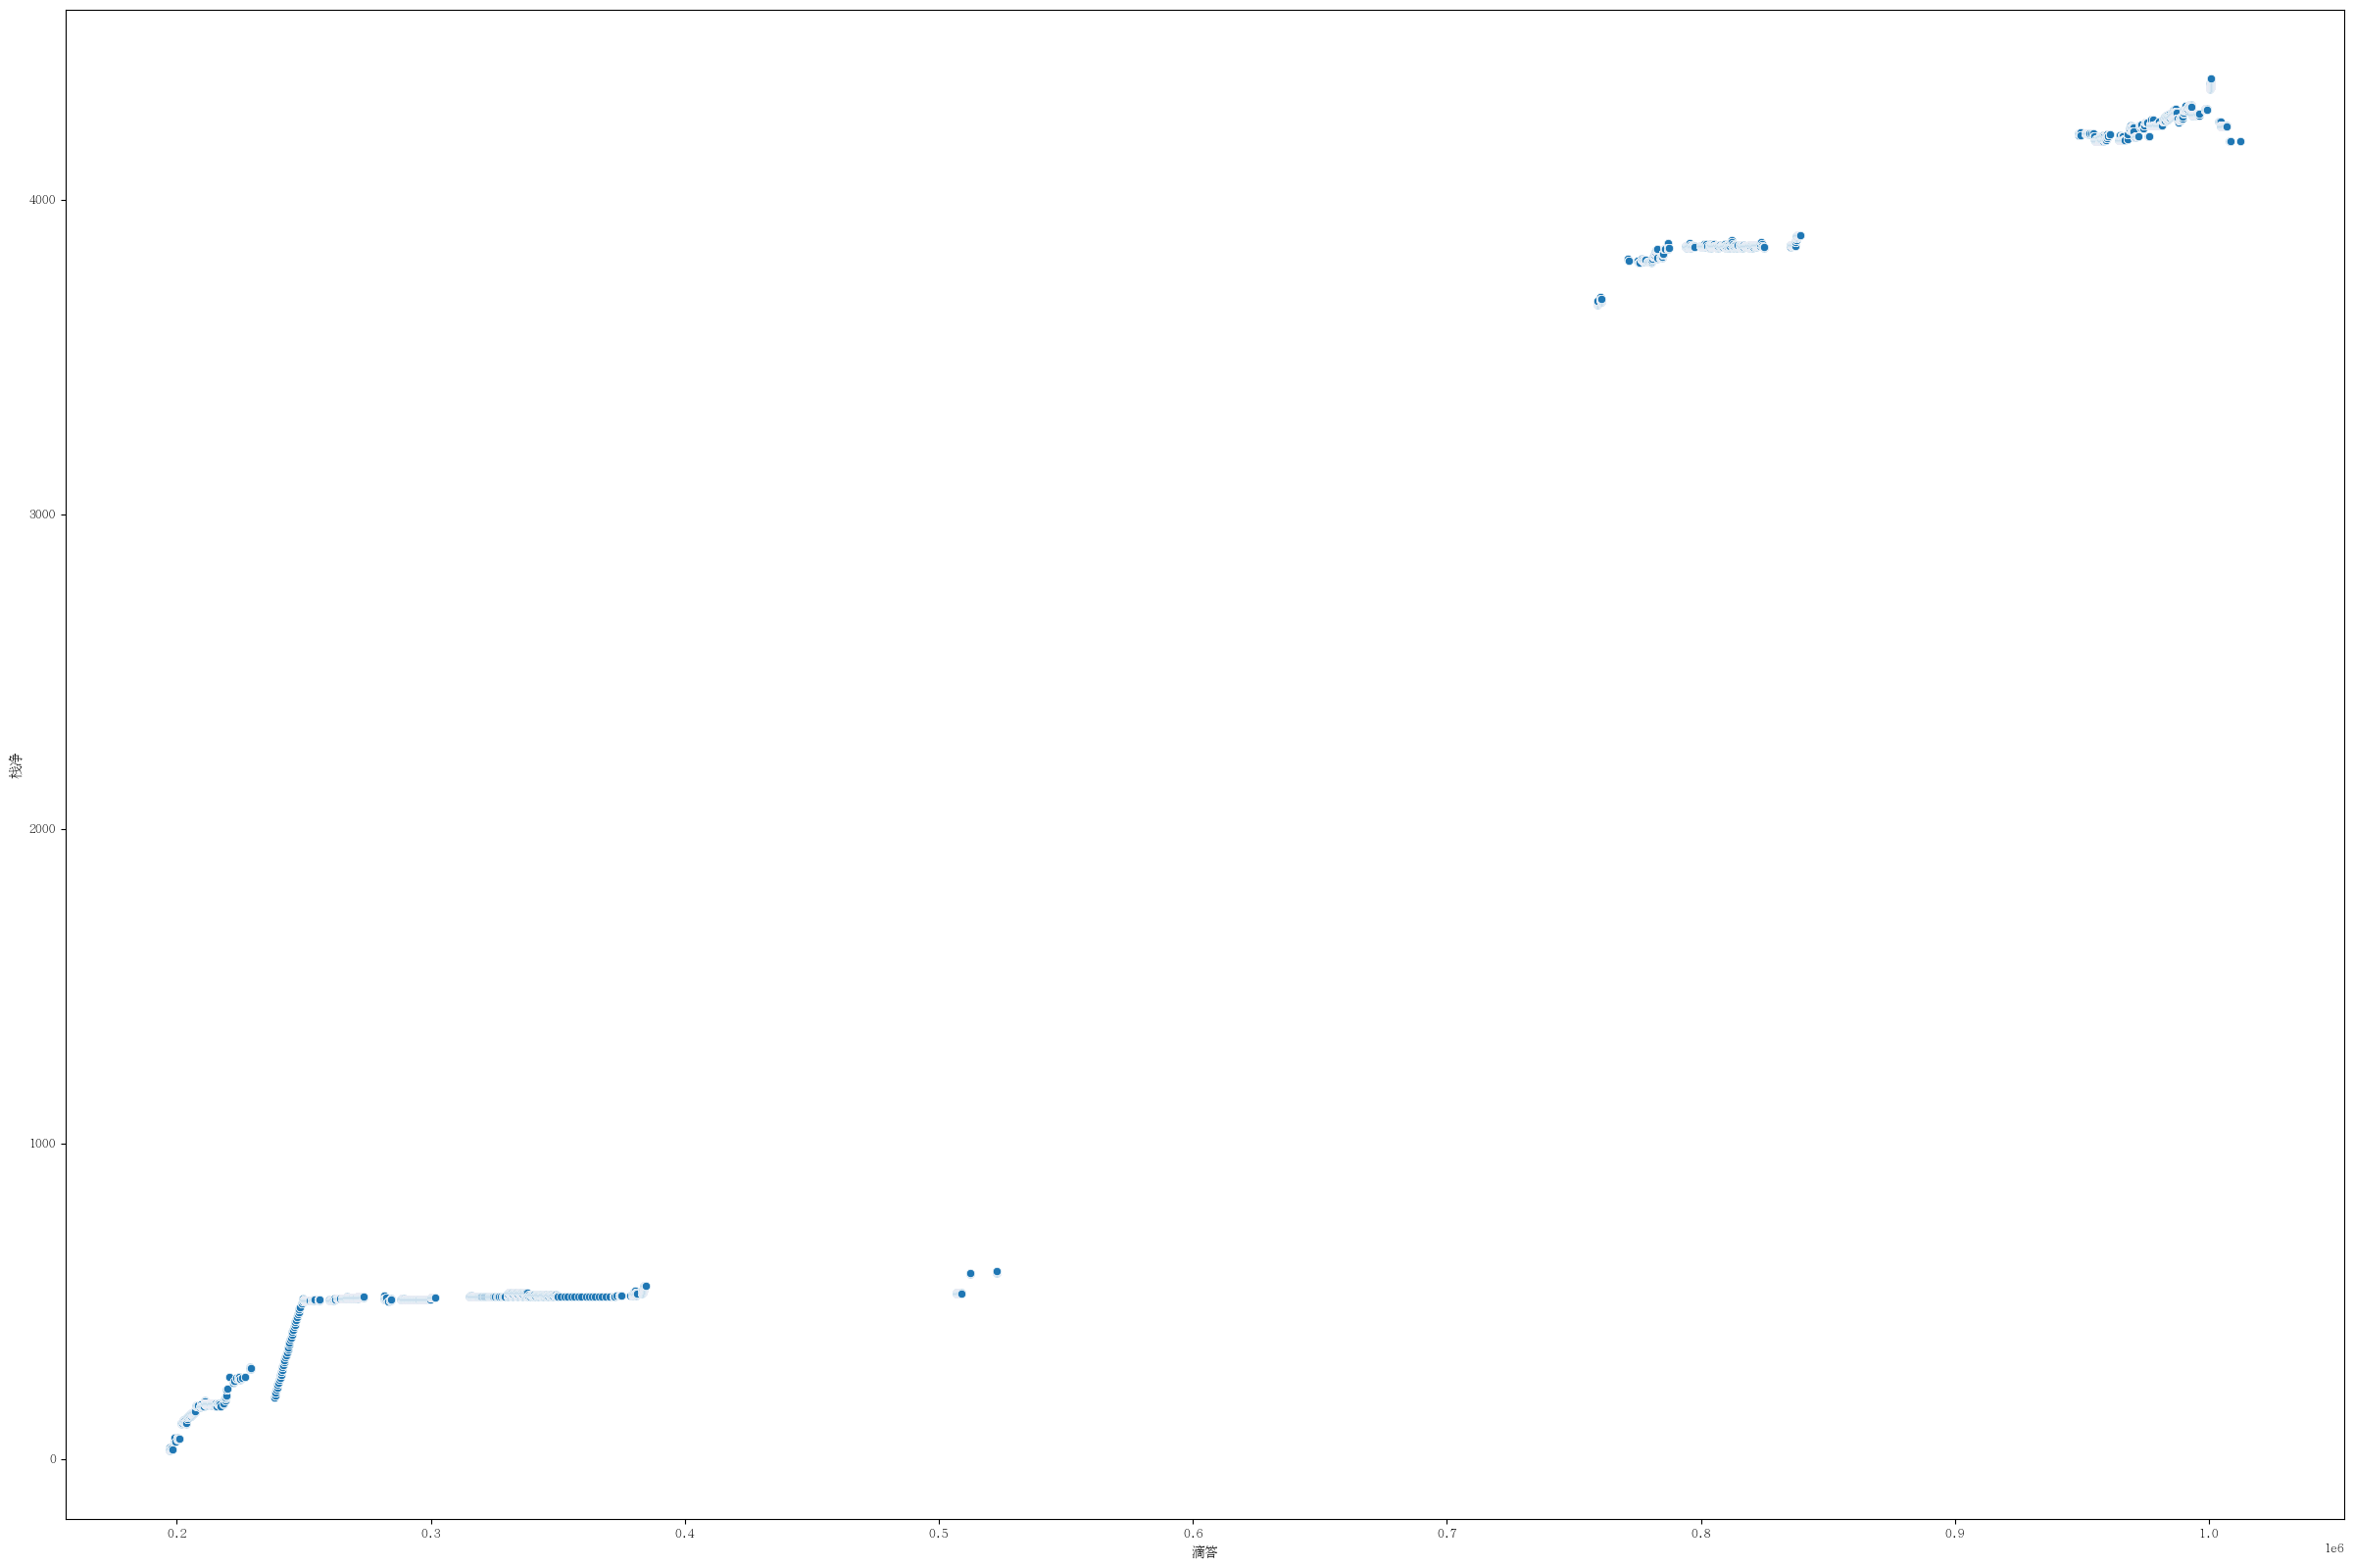

In [36]:
#调用次数前1/11处附近50的函数们
boundary=funcIdCnt//11
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 185 50 (16902, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

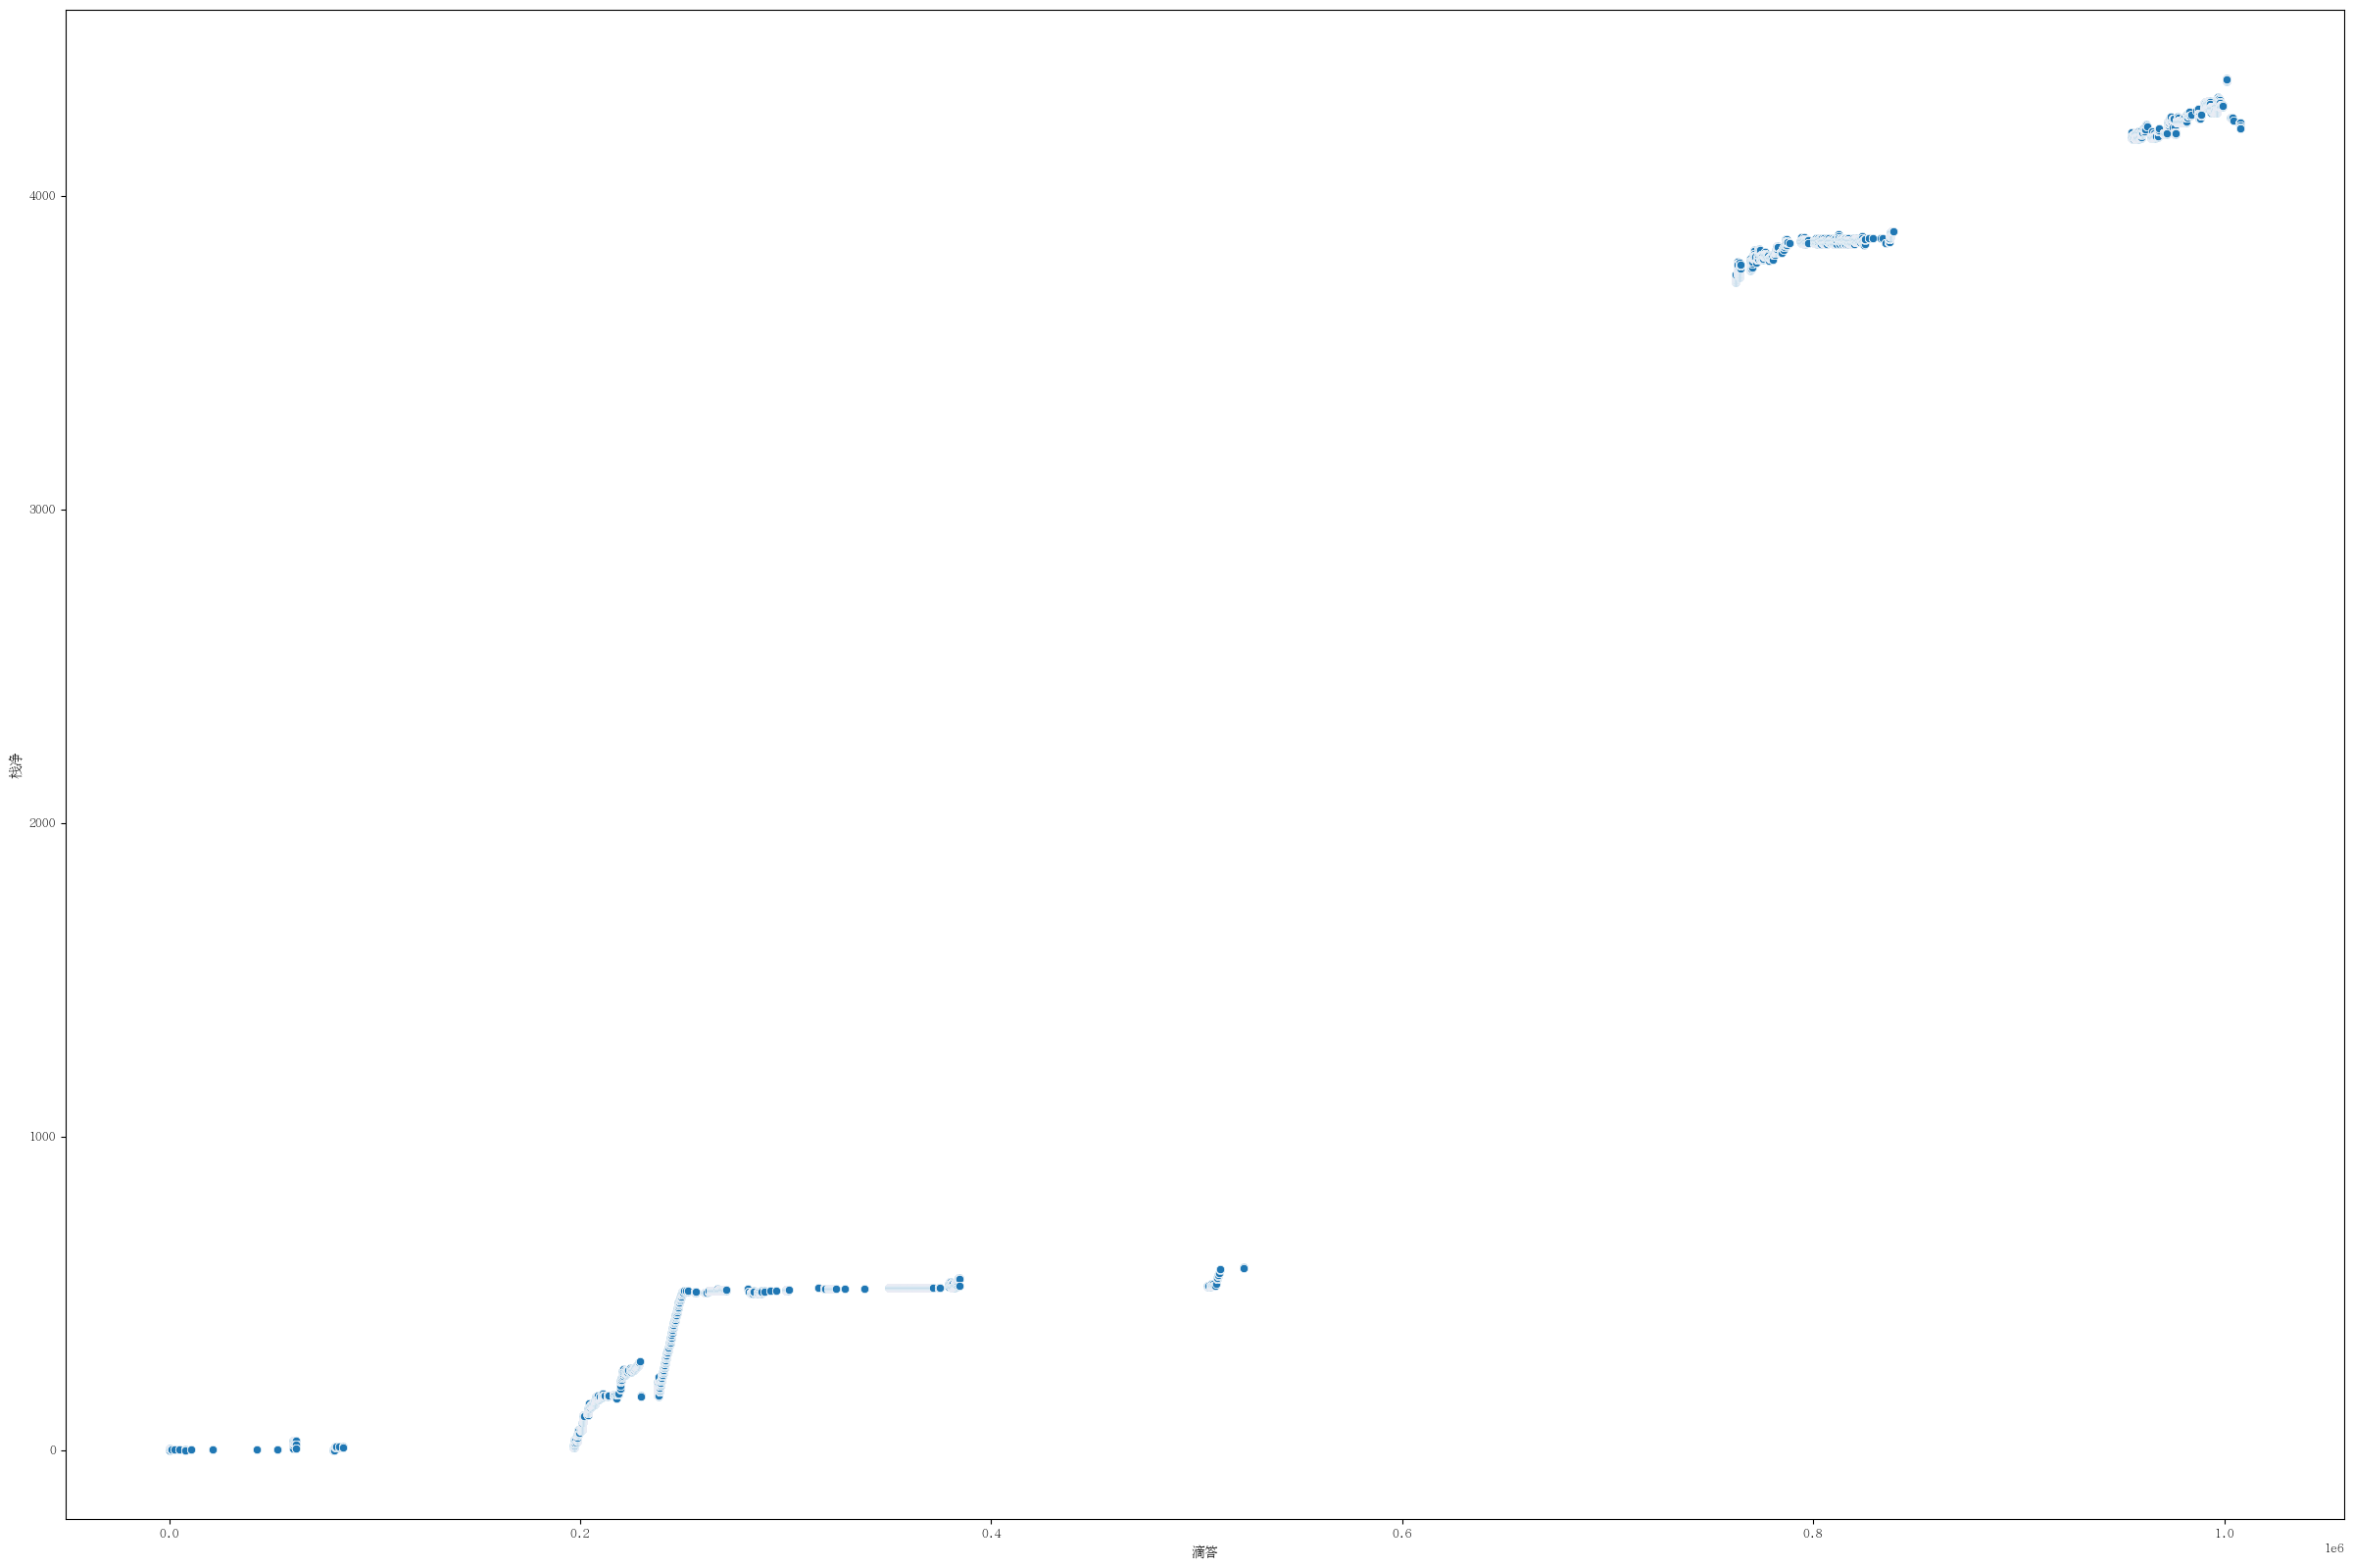

In [37]:
#调用次数前1/15处附近50的函数们
boundary=funcIdCnt//15
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 2088 50 (200, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

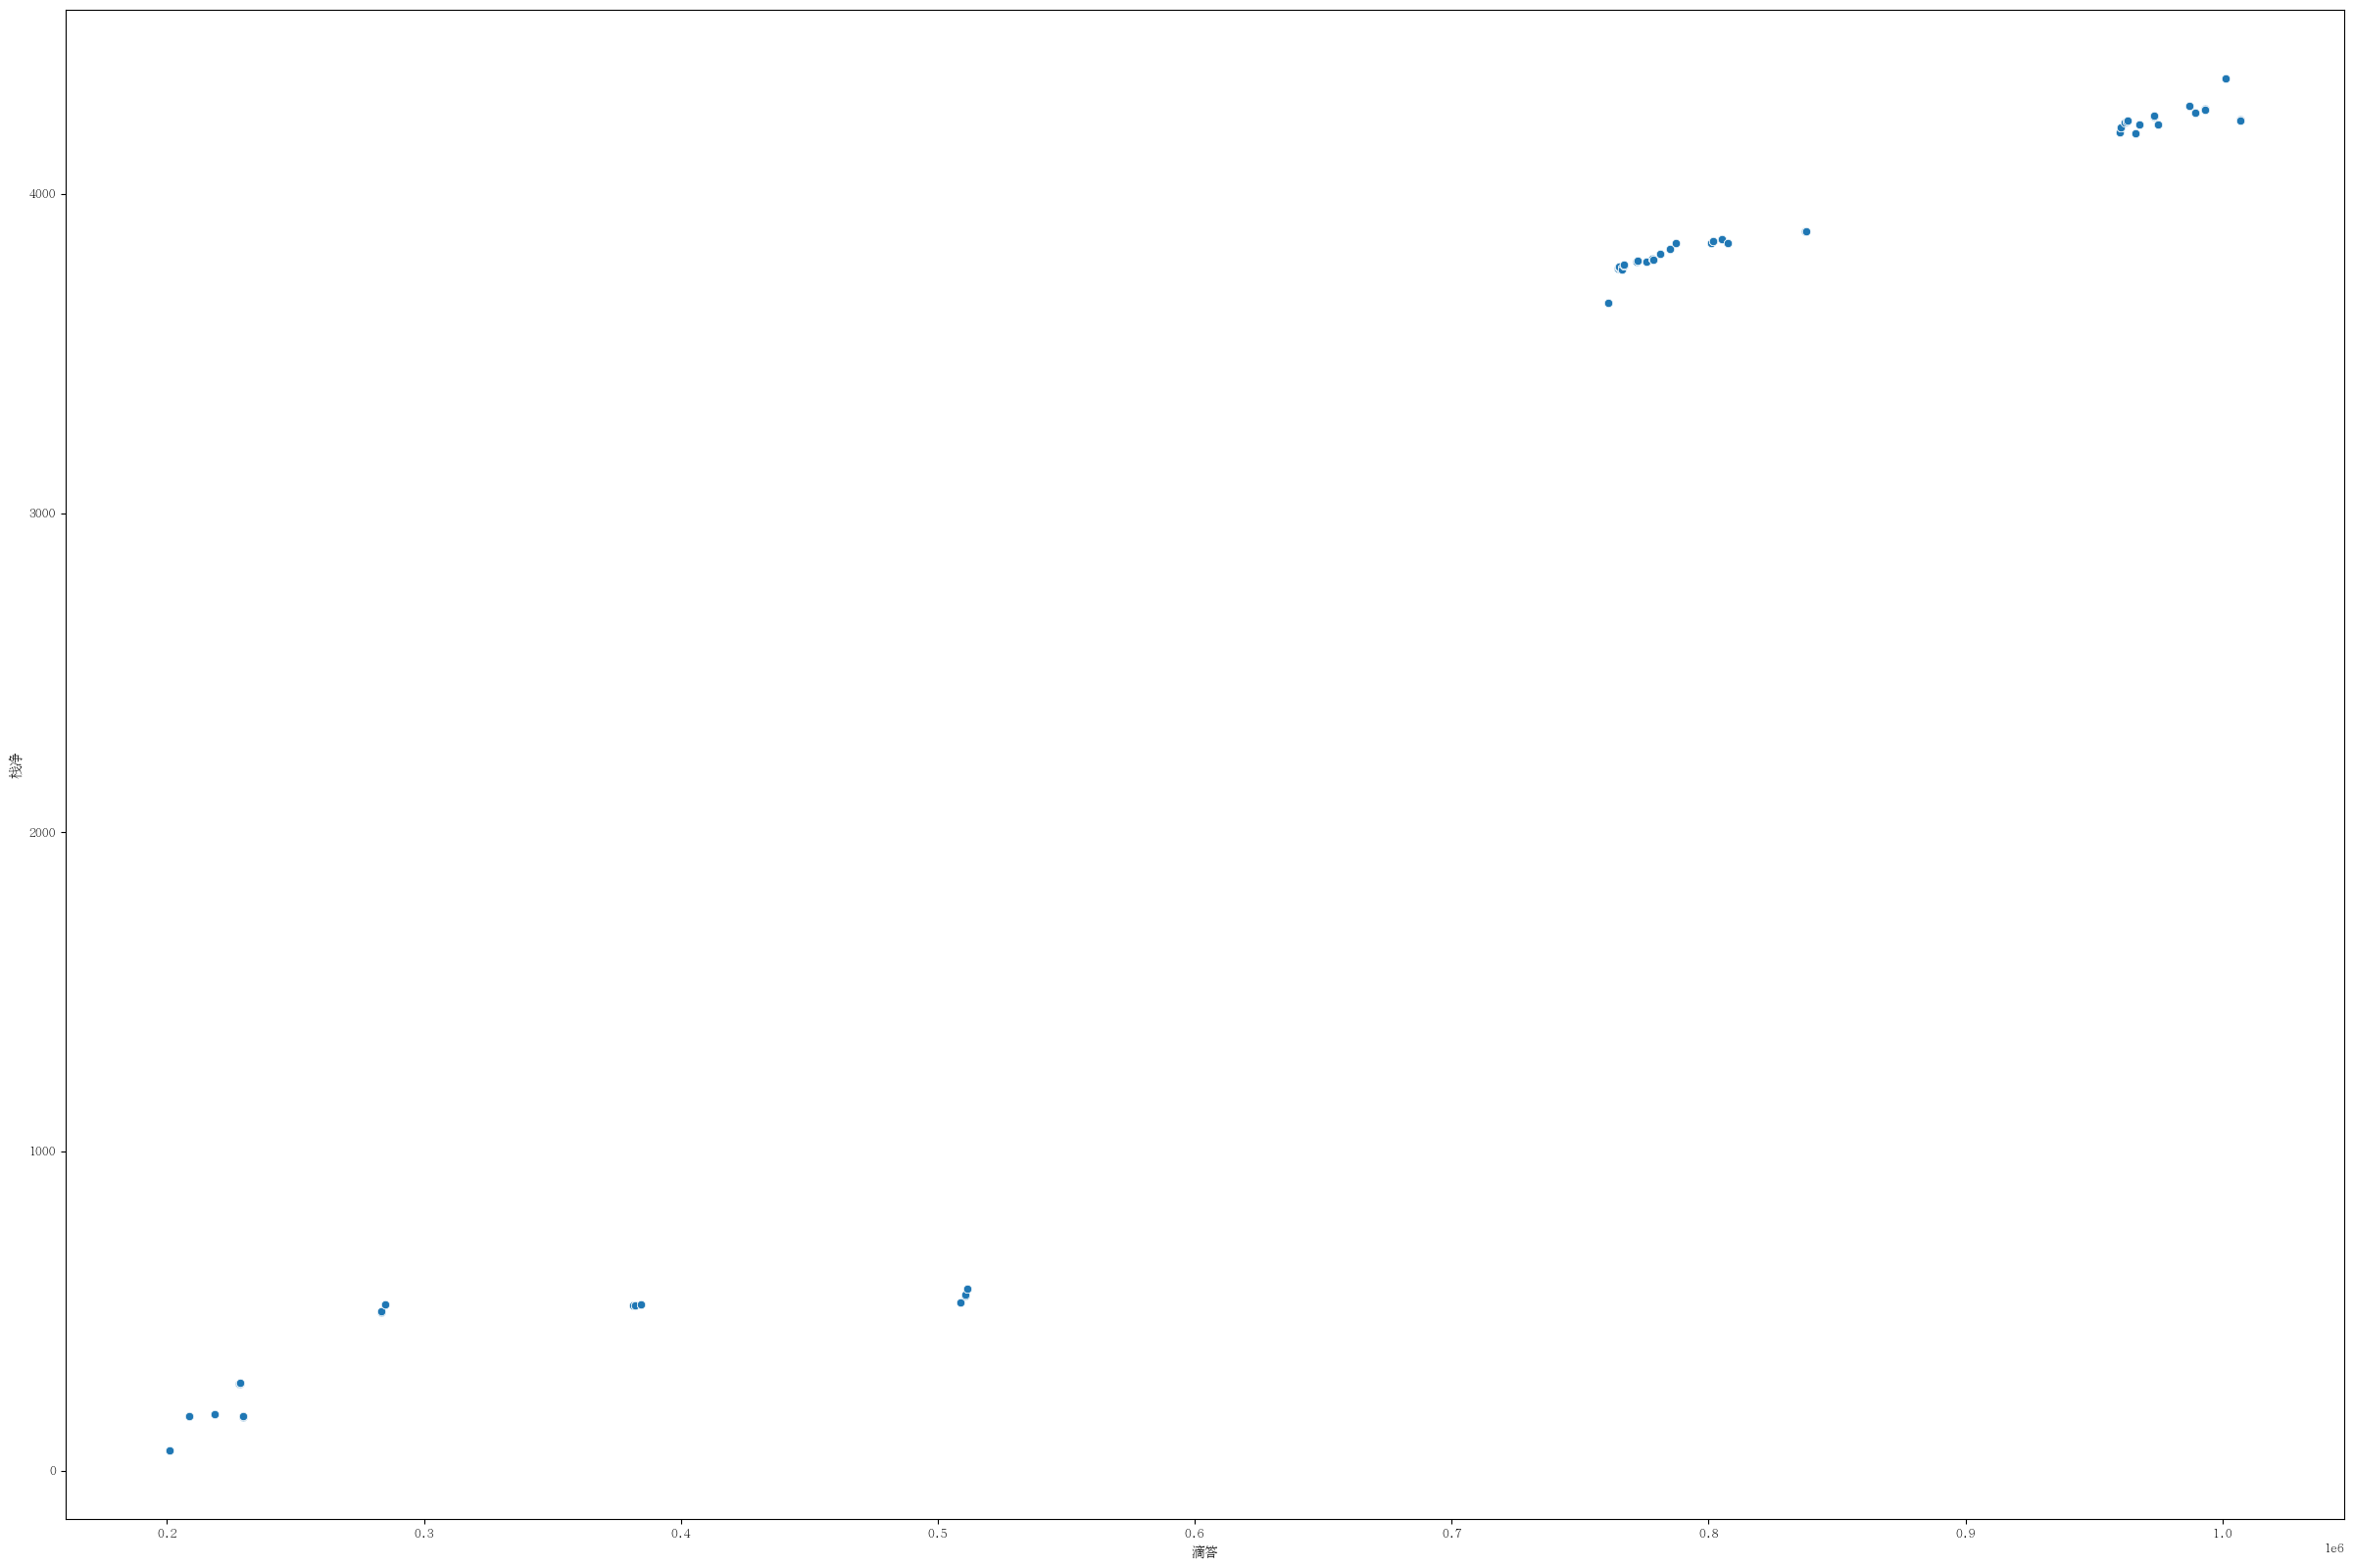

In [38]:
#调用次数后1/4处附近50的函数们
boundary=int(funcIdCnt*(1-1/4))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 2227 50 (200, 20)


212              llvm::AttributeList::addAttributeAtIndex
1930                  clang::Sema::ActOnDocumentableDecls
261           clang::CodeGen::CodeGenTypes::~CodeGenTypes
1076    llvm::ilist_callback_traits<llvm::MachineBasic...
260     (anonymous namespace)::X86FlagsCopyLoweringPas...
2637                              getFunctionStorageClass
1080    clang::CodeGen::CodeGenFunction::requiresRetur...
1840               clang::Sema::DiagnoseMisalignedMembers
255          clang::driver::tools::ParseFunctionAlignment
1631                       clang::Sema::ProcessPragmaWeak
1844                                            isInvalid
2610            clang::ASTContext::ReleaseDeclContextMaps
1108    (anonymous namespace)::X86SpeculativeLoadHarde...
1904                                   markEscapingByrefs
2022              llvm::TargetMachine::resetTargetOptions
1992                     llvm::SelectionDAG::SelectionDAG
2371                          llvm::Module::global_values
336           

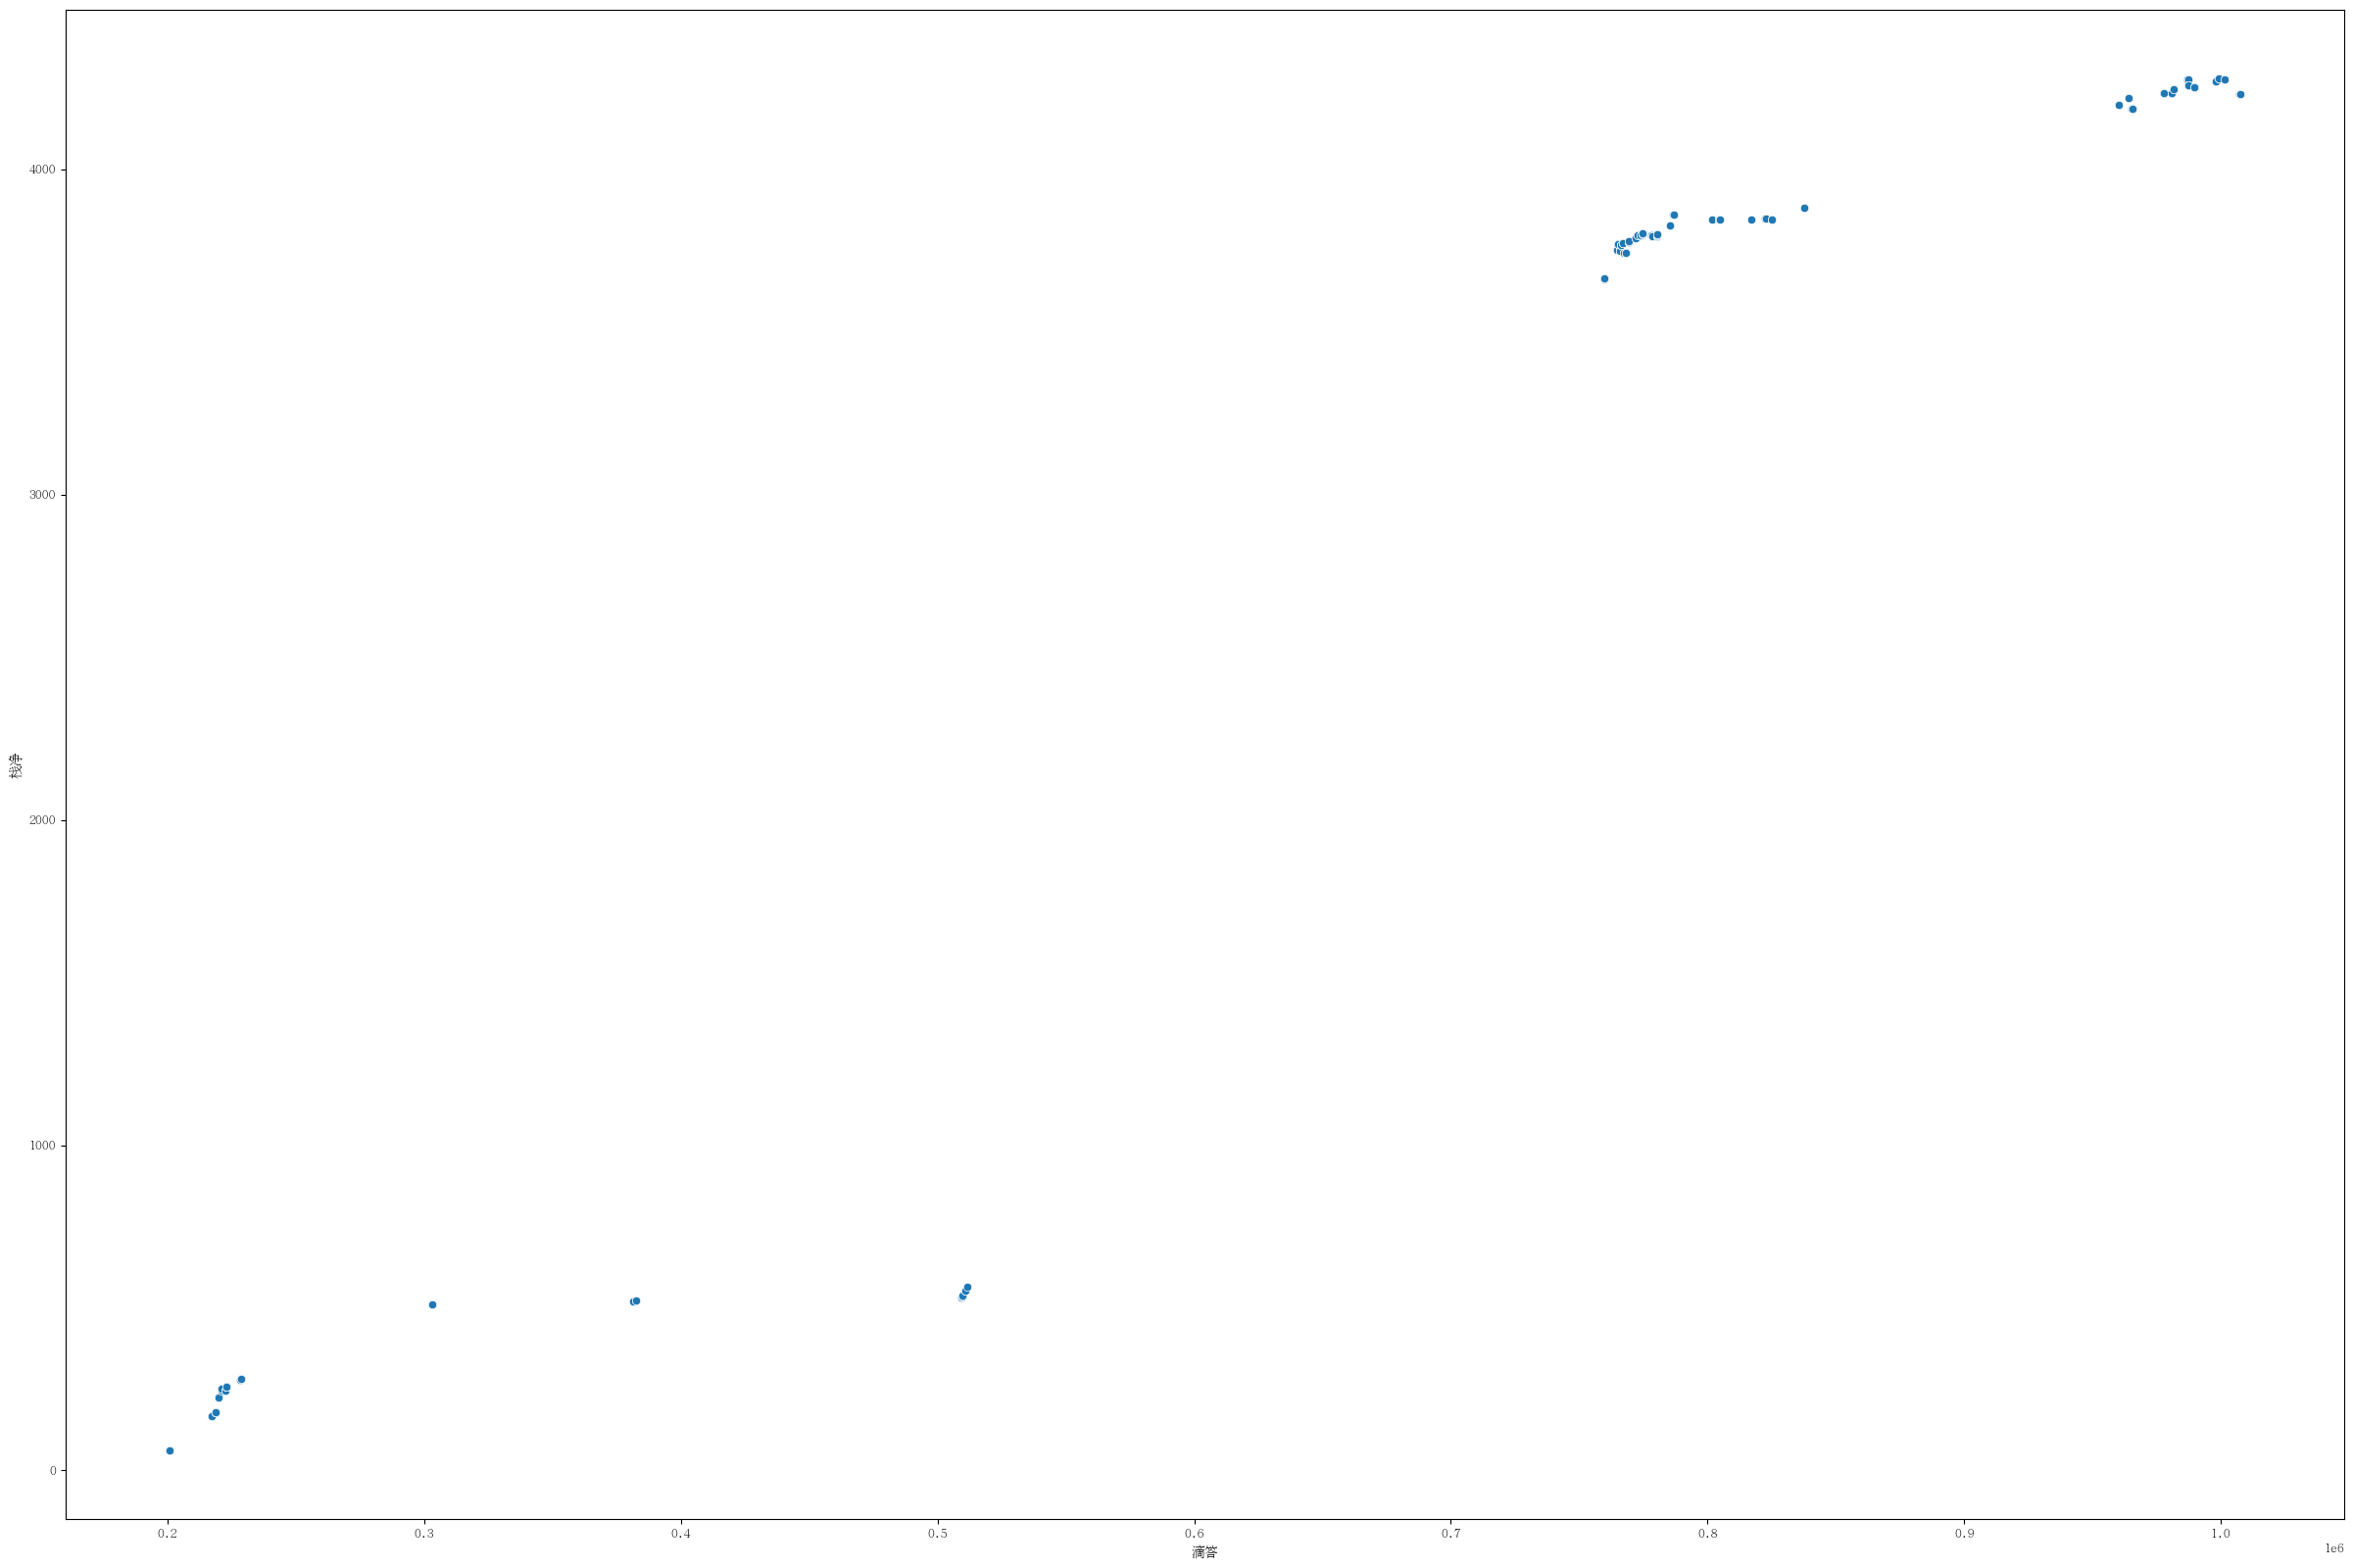

In [39]:
#调用次数后1/5处附近50的函数们
boundary=int(funcIdCnt*(1-1/5))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)


srt_g_fiFn_dfmm[  srt_g_fiFn_dfmm['funcId'].isin(funcId_ls)  ]  ['funcName']

(1014494, 20) 2784 2320 50 (150, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

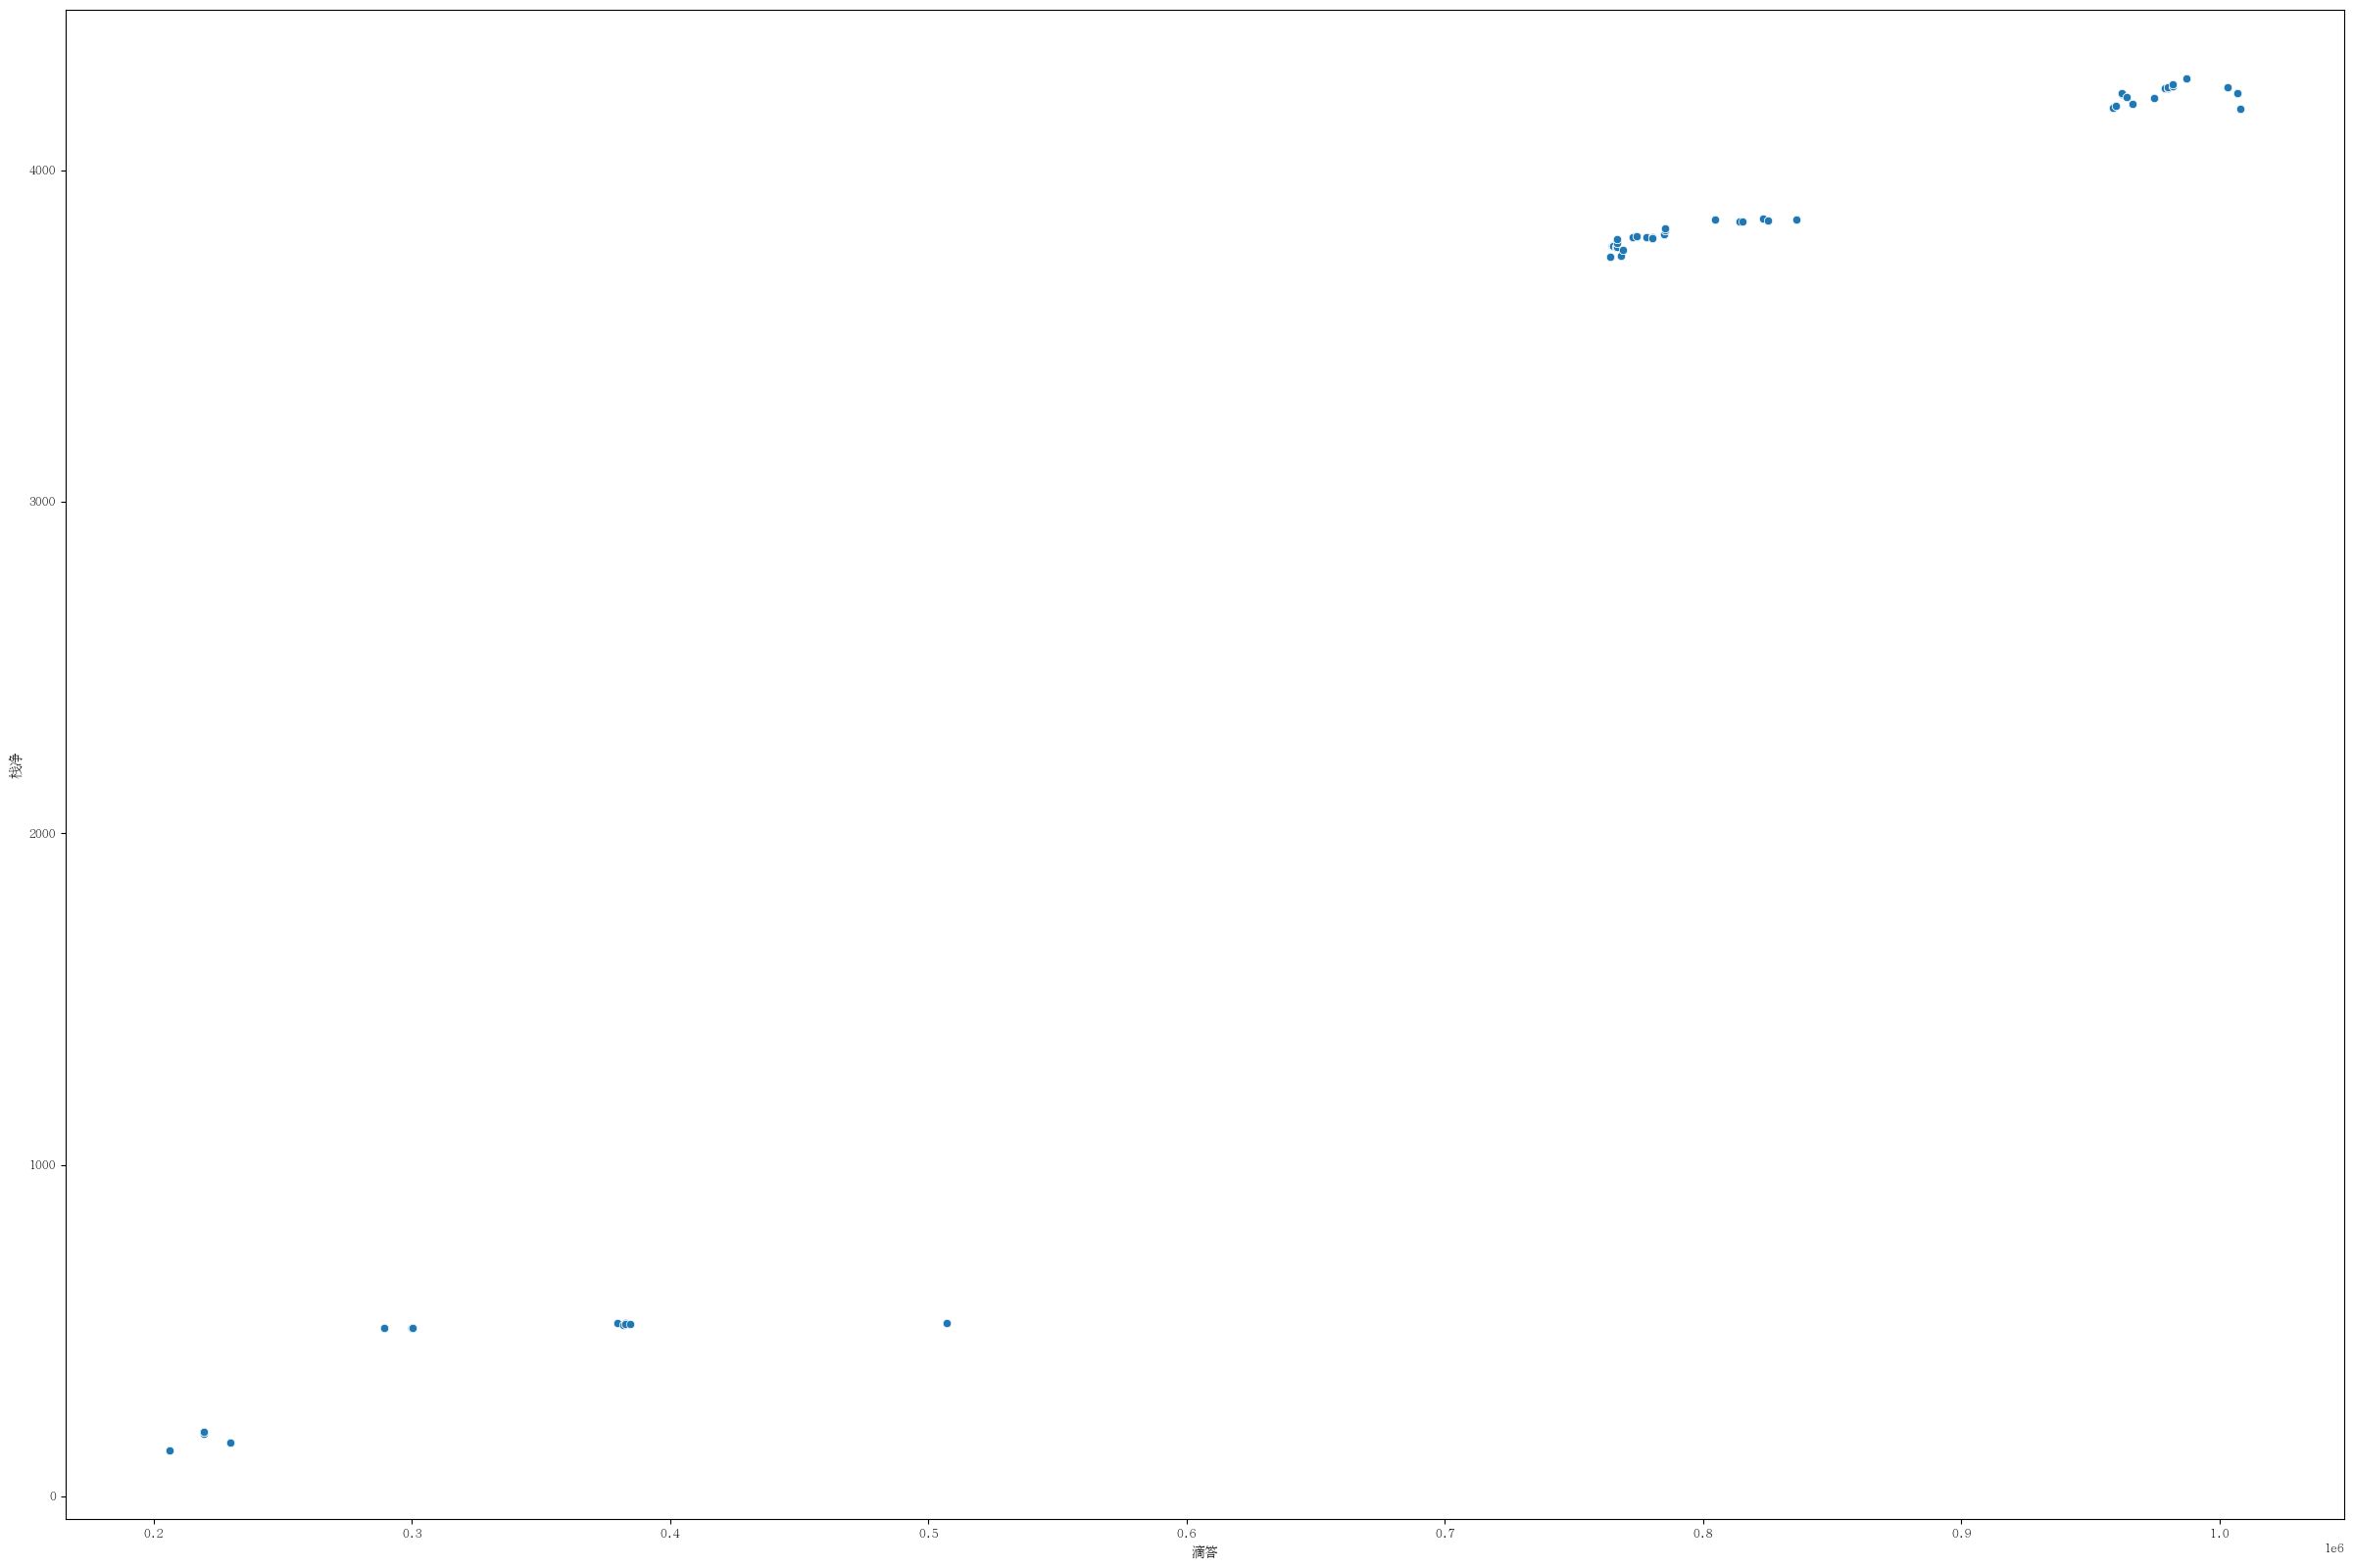

In [40]:
#调用次数后1/6处附近50的函数们
boundary=int(funcIdCnt*(1-1/6))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 2386 50 (150, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

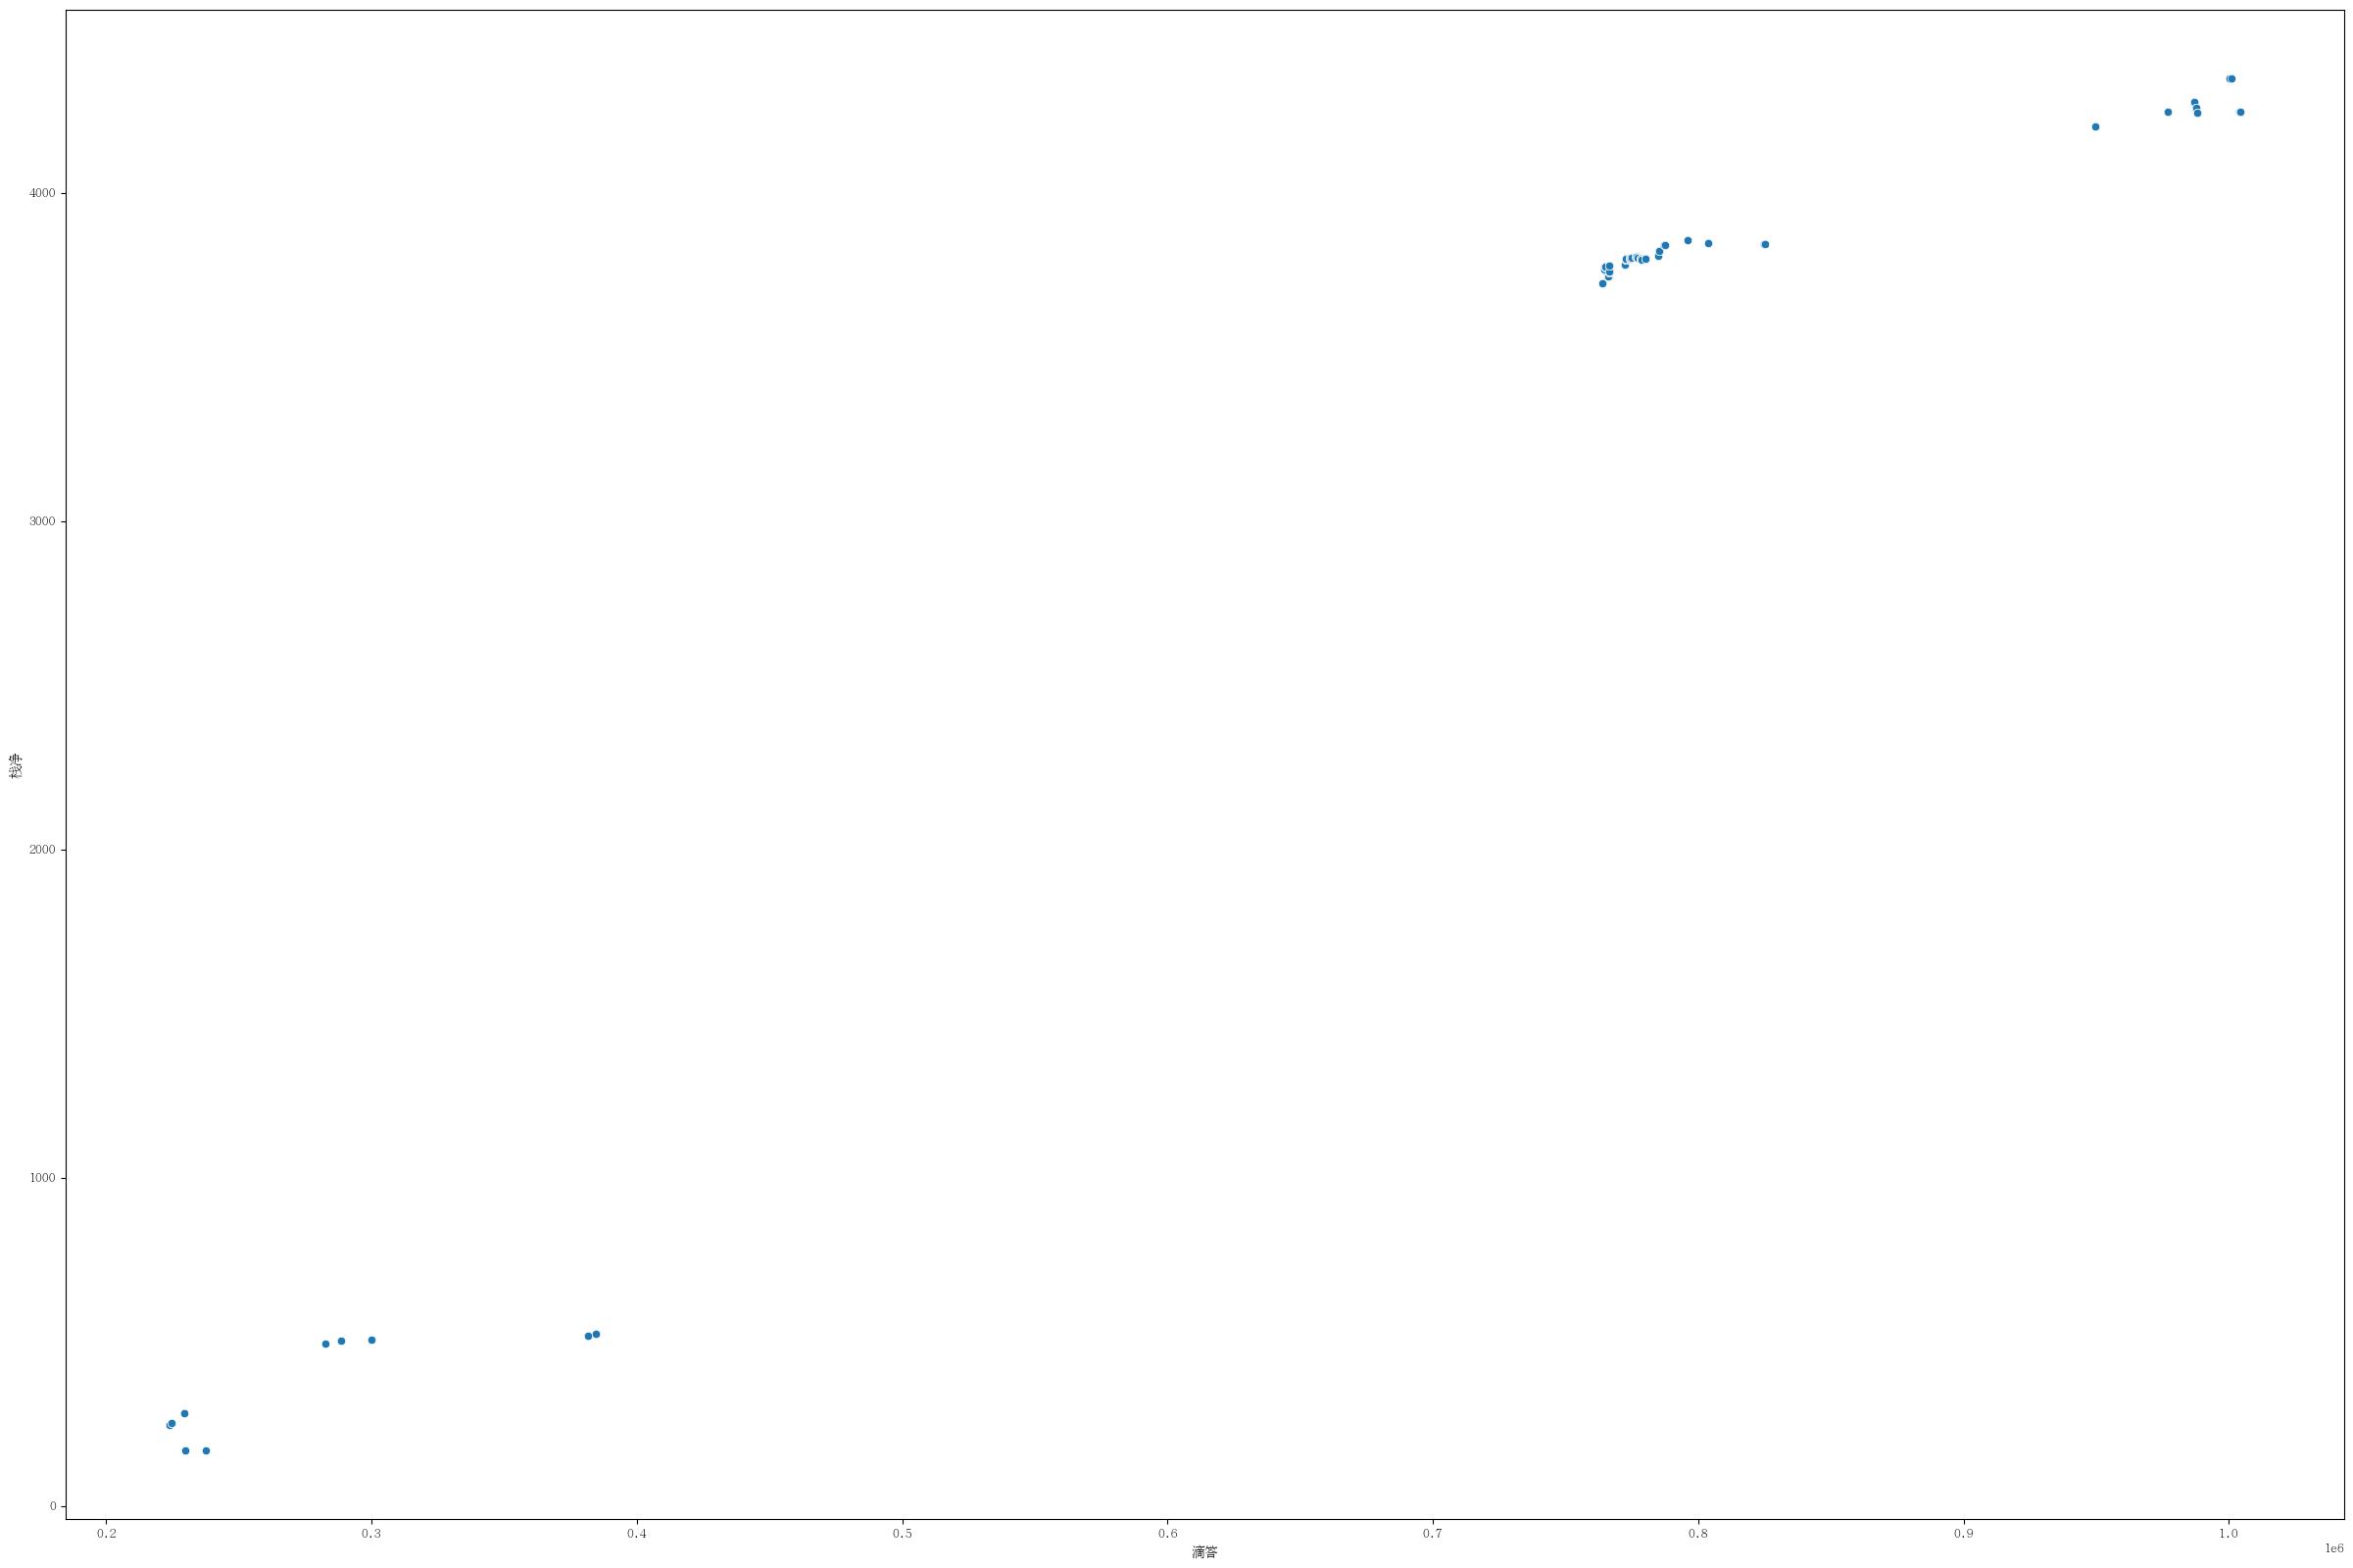

In [41]:
#调用次数后1/7处附近50的函数们
boundary=int(funcIdCnt*(1-1/7))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 2436 50 (150, 20)


842        clang::OverloadCandidateSet::destroyCandidates
87                    llvm::TargetMachine::useEmulatedTLS
851                clang::driver::Command::PrintFileNames
1786                               llvm::detachDeadBlocks
1288                    llvm::AttrBuilder::addUWTableAttr
855      llvm::TargetLoweringObjectFile::getKindForGlobal
1595    (anonymous namespace)::ItaniumMangleContextImp...
1790        clang::Sema::RegisterLocallyScopedExternCDecl
863      llvm::TargetFrameLowering::getStackAlignmentSkew
865                                   getFnStackAlignment
866                    clang::FunctionProtoType::canThrow
2088       clang::CodeGen::CodeGenFunction::EmitEndEHSpec
867                                      CreateVaListDecl
868                     llvm::CoroConditionalWrapper::run
870                       clang::DeclContext::decls_begin
871           clang::Parser::isDeclarationAfterDeclarator
882                   llvm::createX86ObjectTargetStreamer
888           

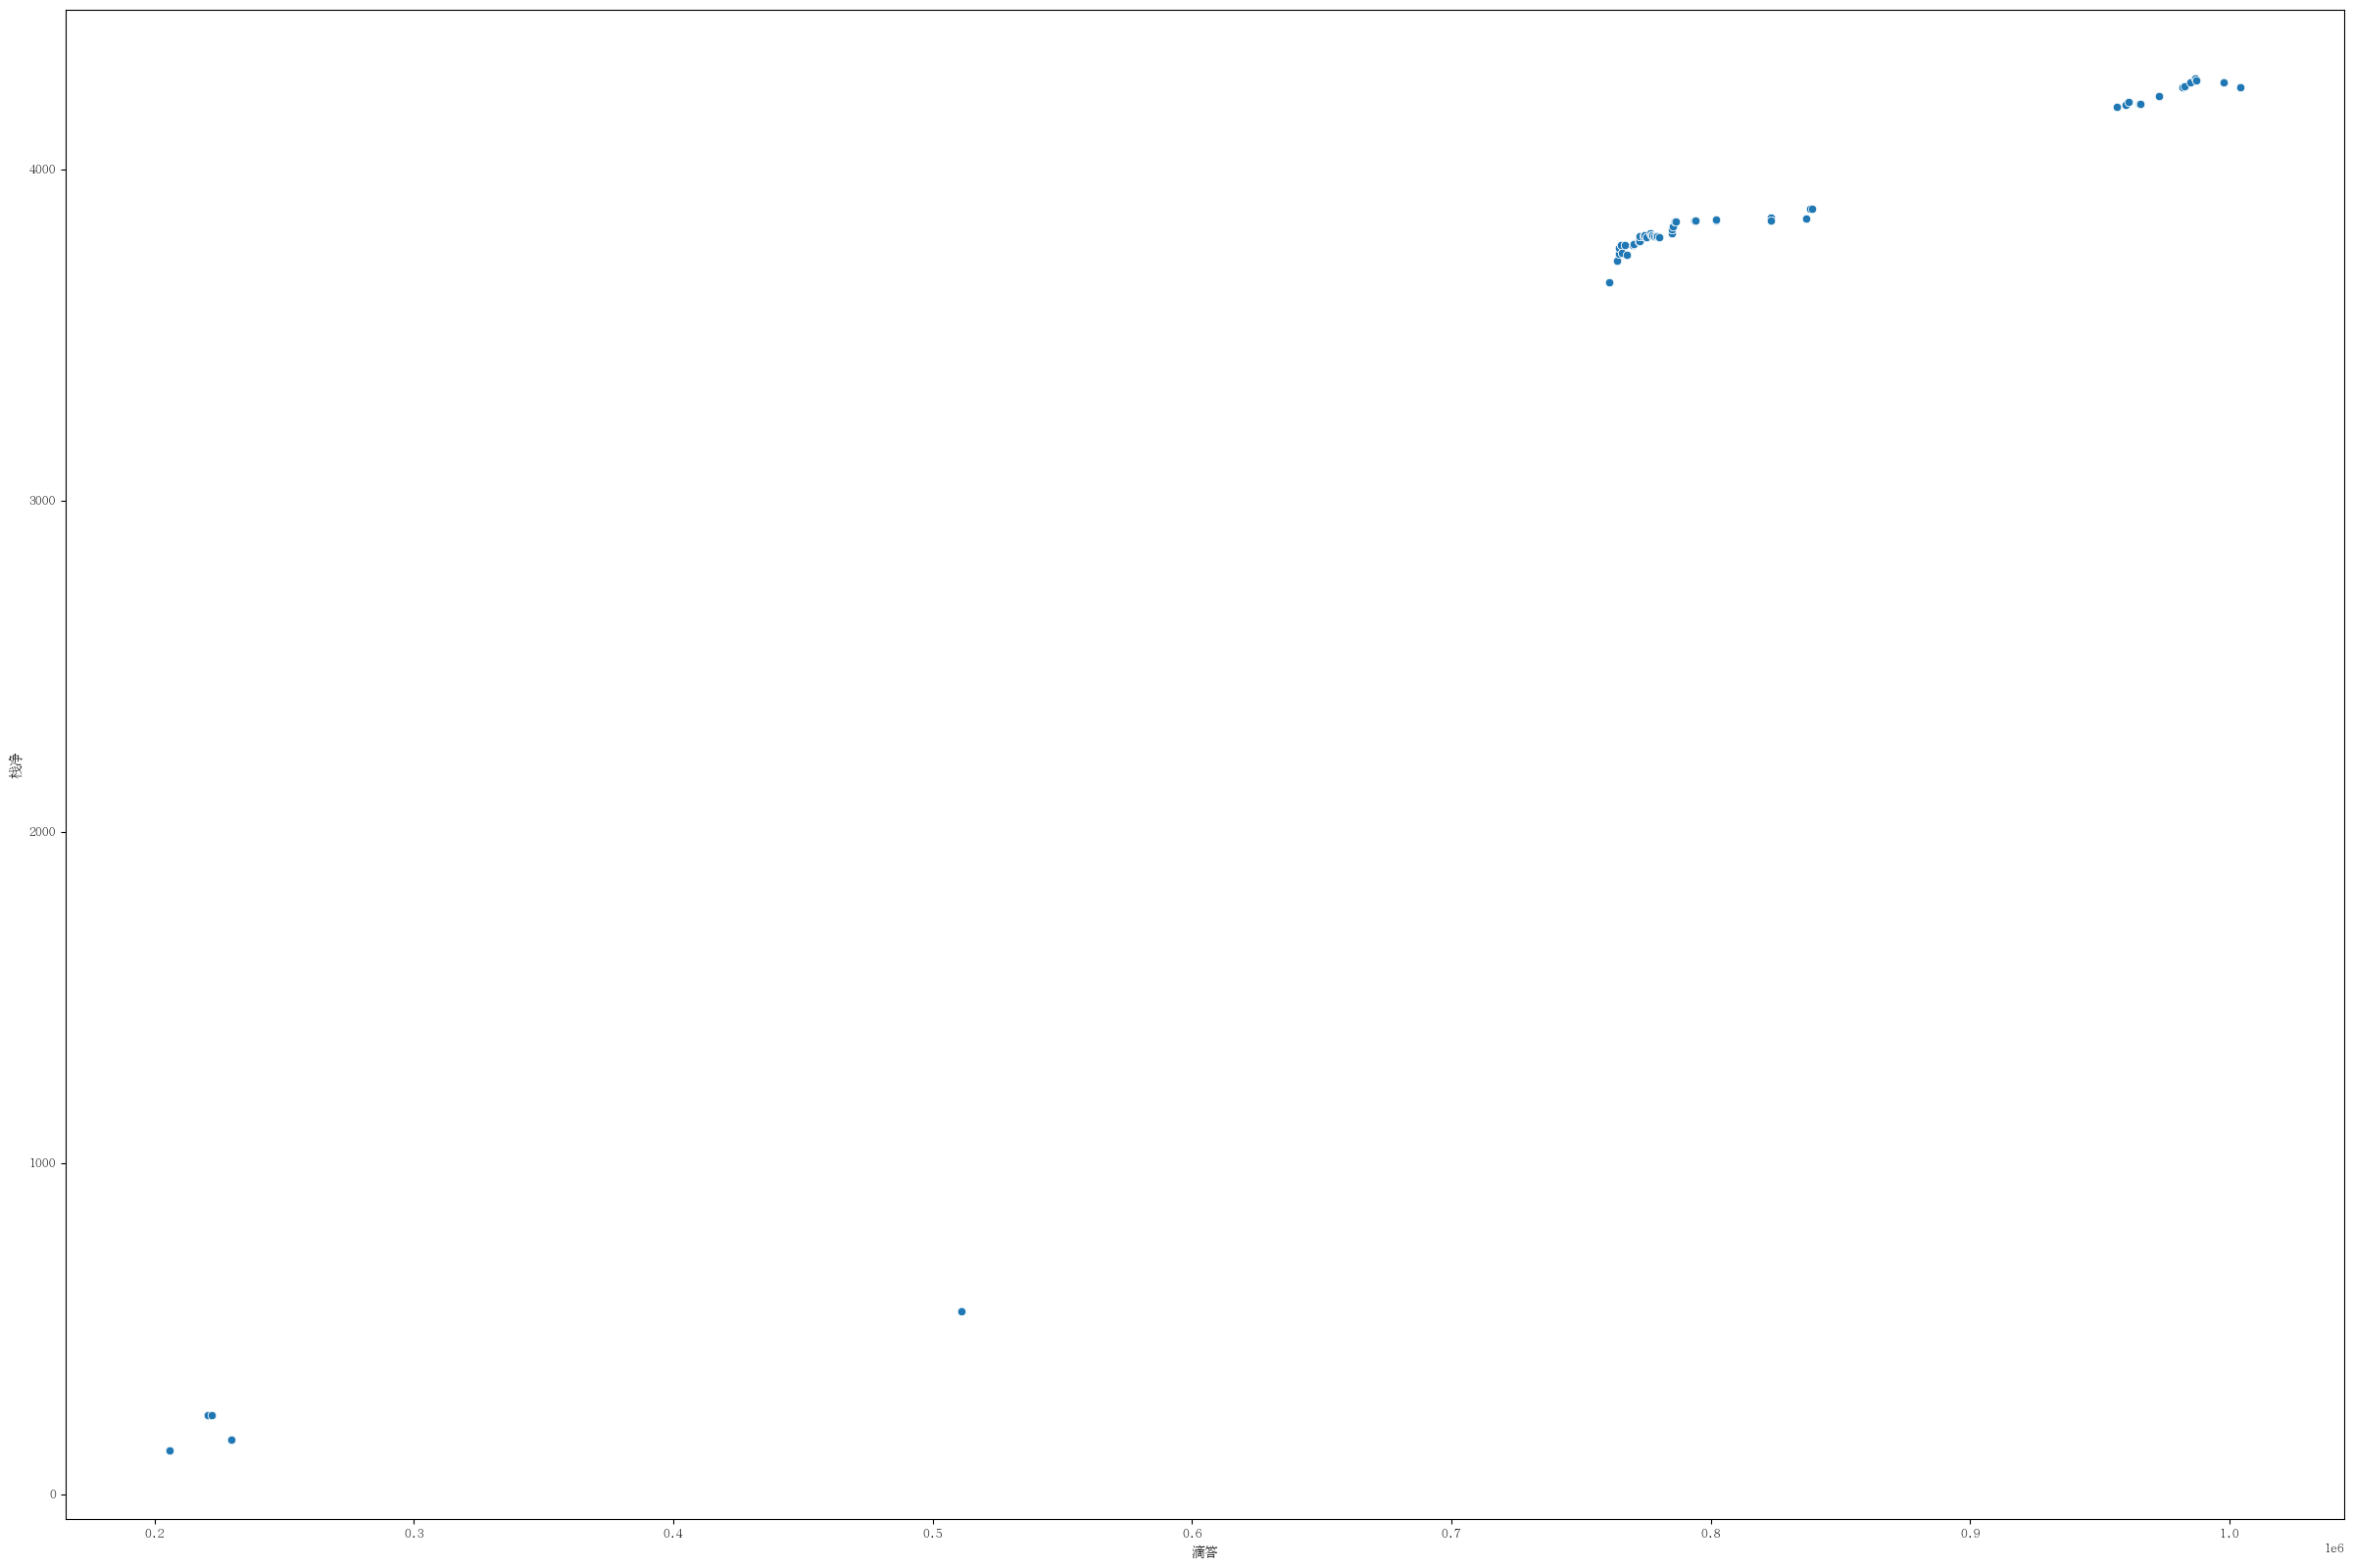

In [42]:
#调用次数后1/8处附近50的函数们
boundary=int(funcIdCnt*(1-1/8))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)


srt_g_fiFn_dfmm[  srt_g_fiFn_dfmm['funcId'].isin(funcId_ls)  ]  ['funcName']

(1014494, 20) 2784 2474 50 (150, 20)


<AxesSubplot:xlabel='滴答', ylabel='栈净'>

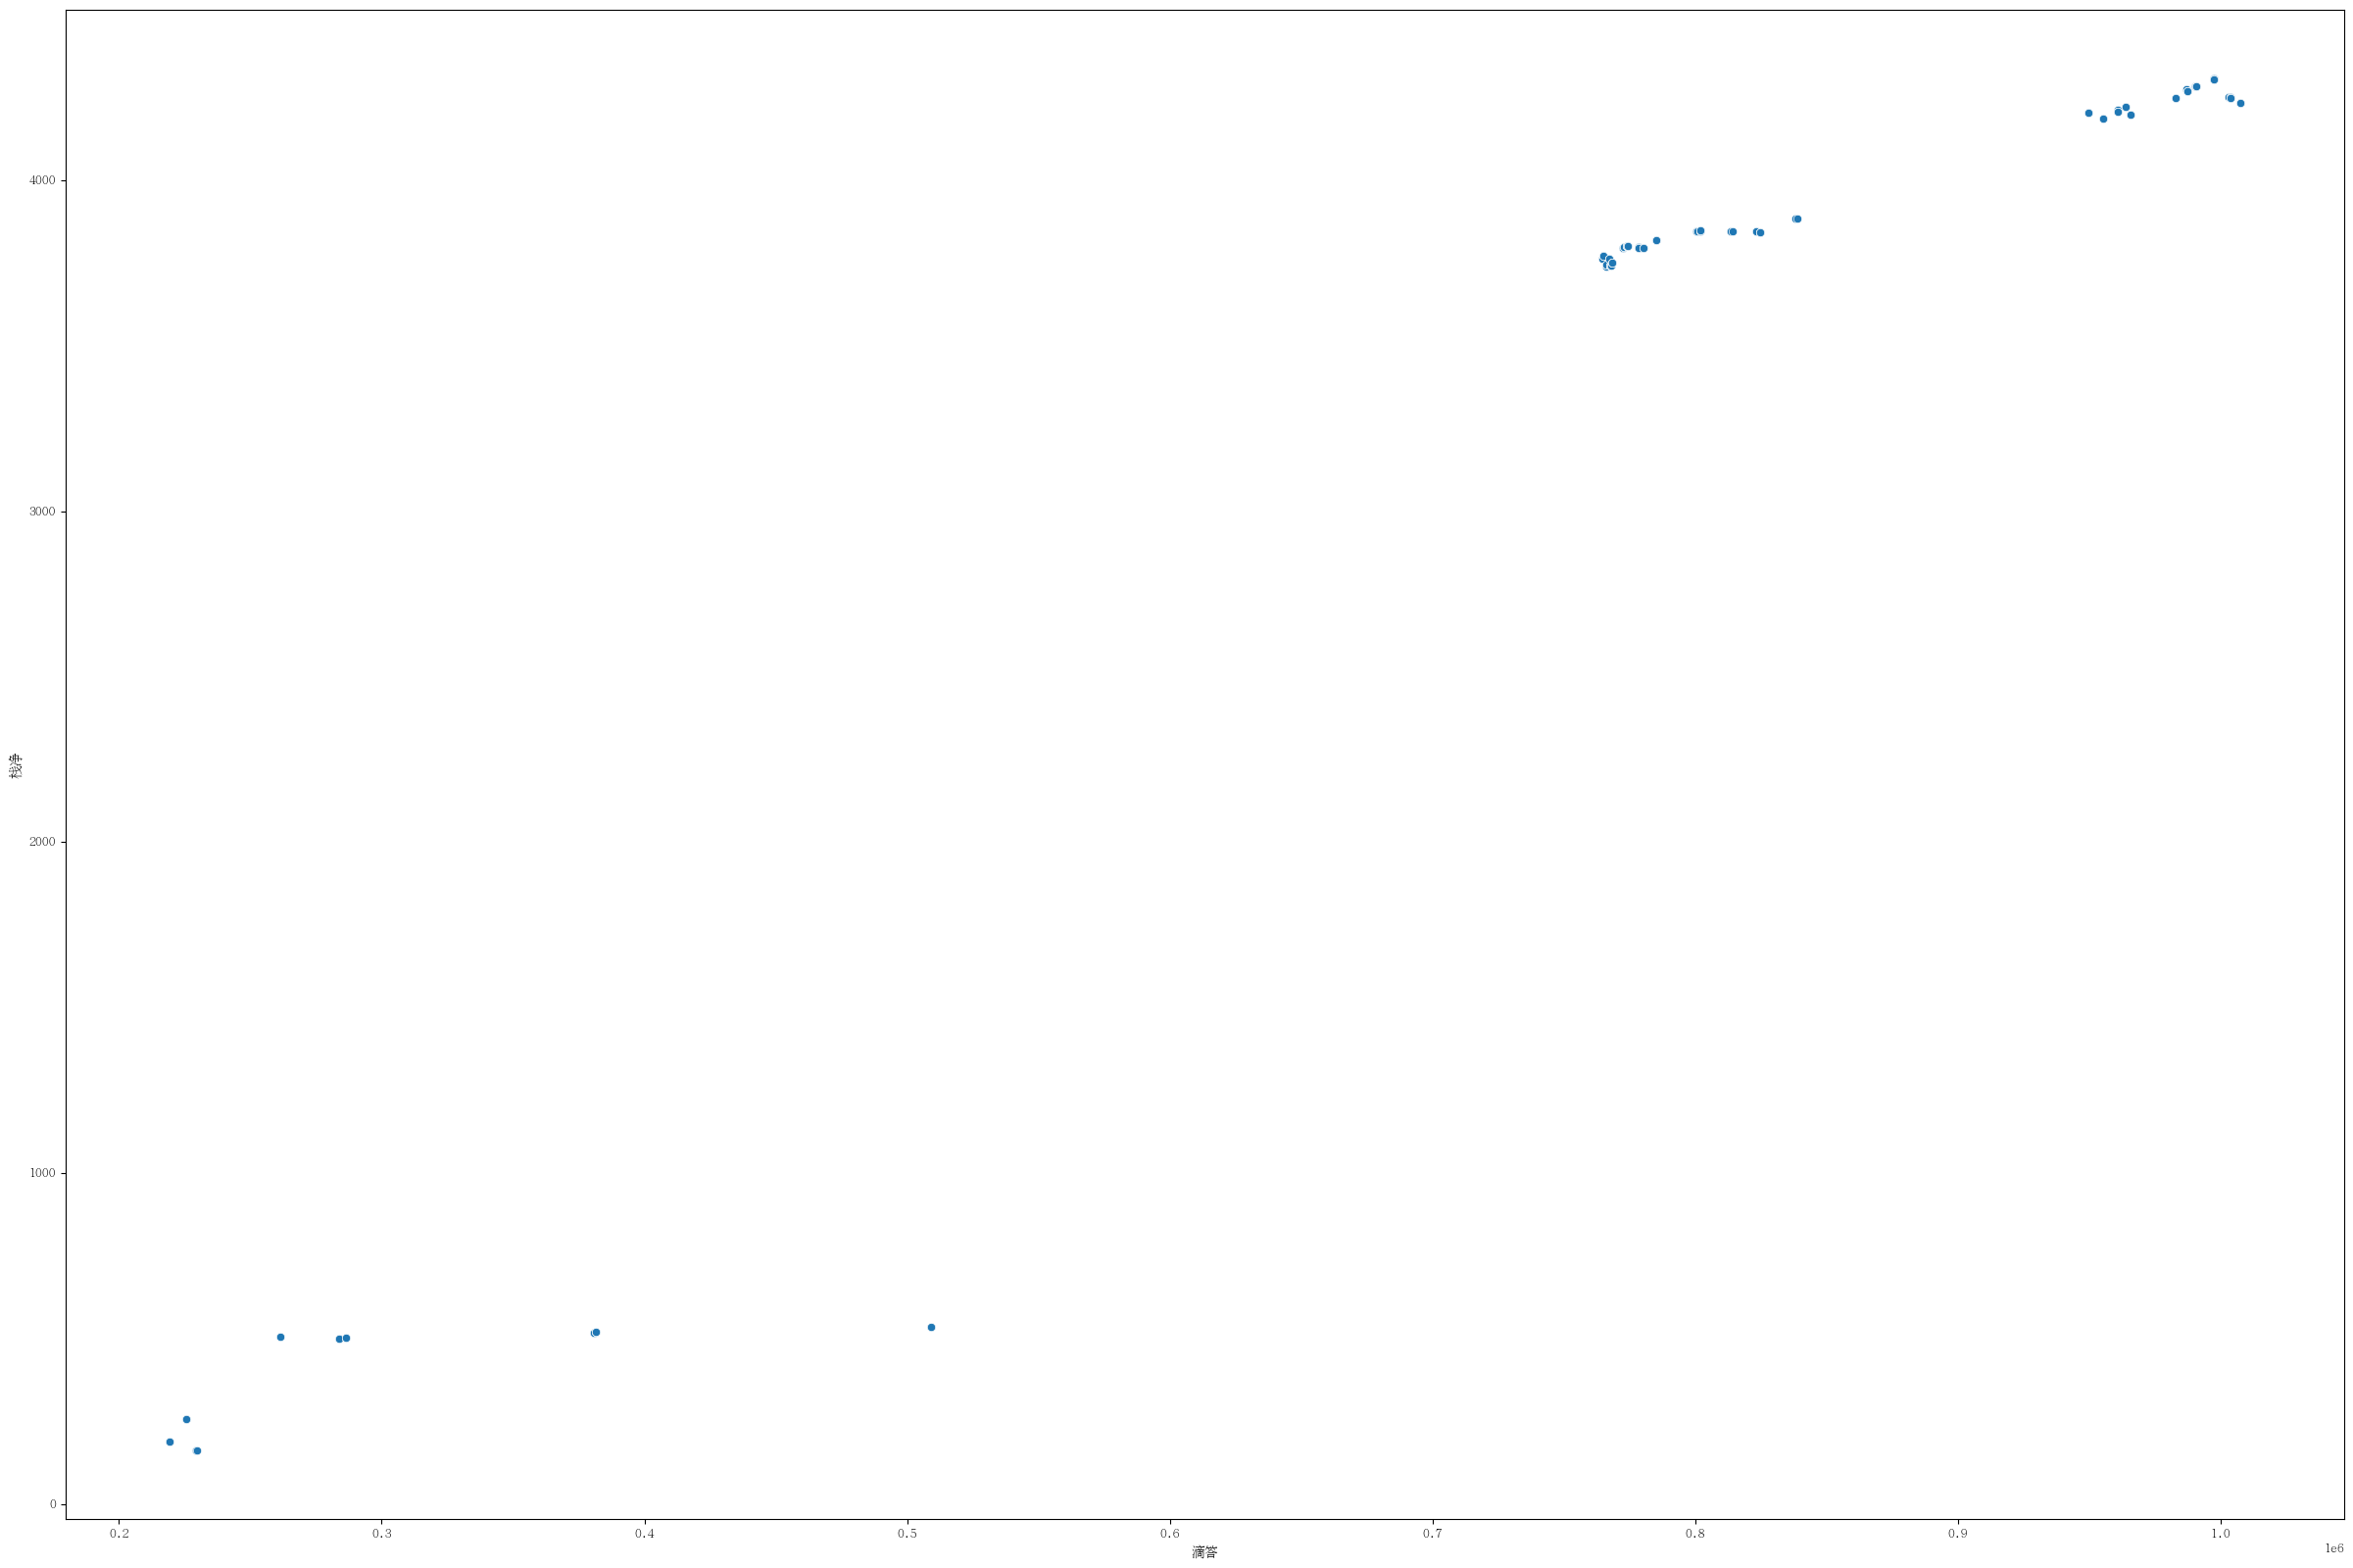

In [43]:
#调用次数后1/9处附近50的函数们
boundary=int(funcIdCnt*(1-1/9))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

(1014494, 20) 2784 2505 50 (150, 20)


1032           llvm::X86AsmPrinter::emitFunctionBodyStart
1968                              isIncompleteDeclExternC
1967                         clang::ToConstrainedExceptMD
1828    llvm::MachineModuleInfoWrapperPass::doFinaliza...
1045                     clang::driver::XRayArgs::addArgs
1227                      clang::ASTContext::createCXXABI
30      (anonymous namespace)::InitHeaderSearch::AddDe...
2766         llvm::InLineChangePrinter::registerCallbacks
1948     clang::Sema::DiagnoseUnterminatedPragmaAttribute
1059    (anonymous namespace)::X86PassConfig::addPreSc...
1836    clang::CodeGen::ApplyDebugLocation::ApplyDebug...
1061                               getFrontendActionTable
1066                             CheckJumpOutOfSEHFinally
1837                                     emitEncodingByte
1070    clang::driver::toolchains::Generic_GCC::Transl...
1779            clang::driver::Driver::setUpResponseFiles
833                             llvm::initTypeSizeOptions
2216    (anony

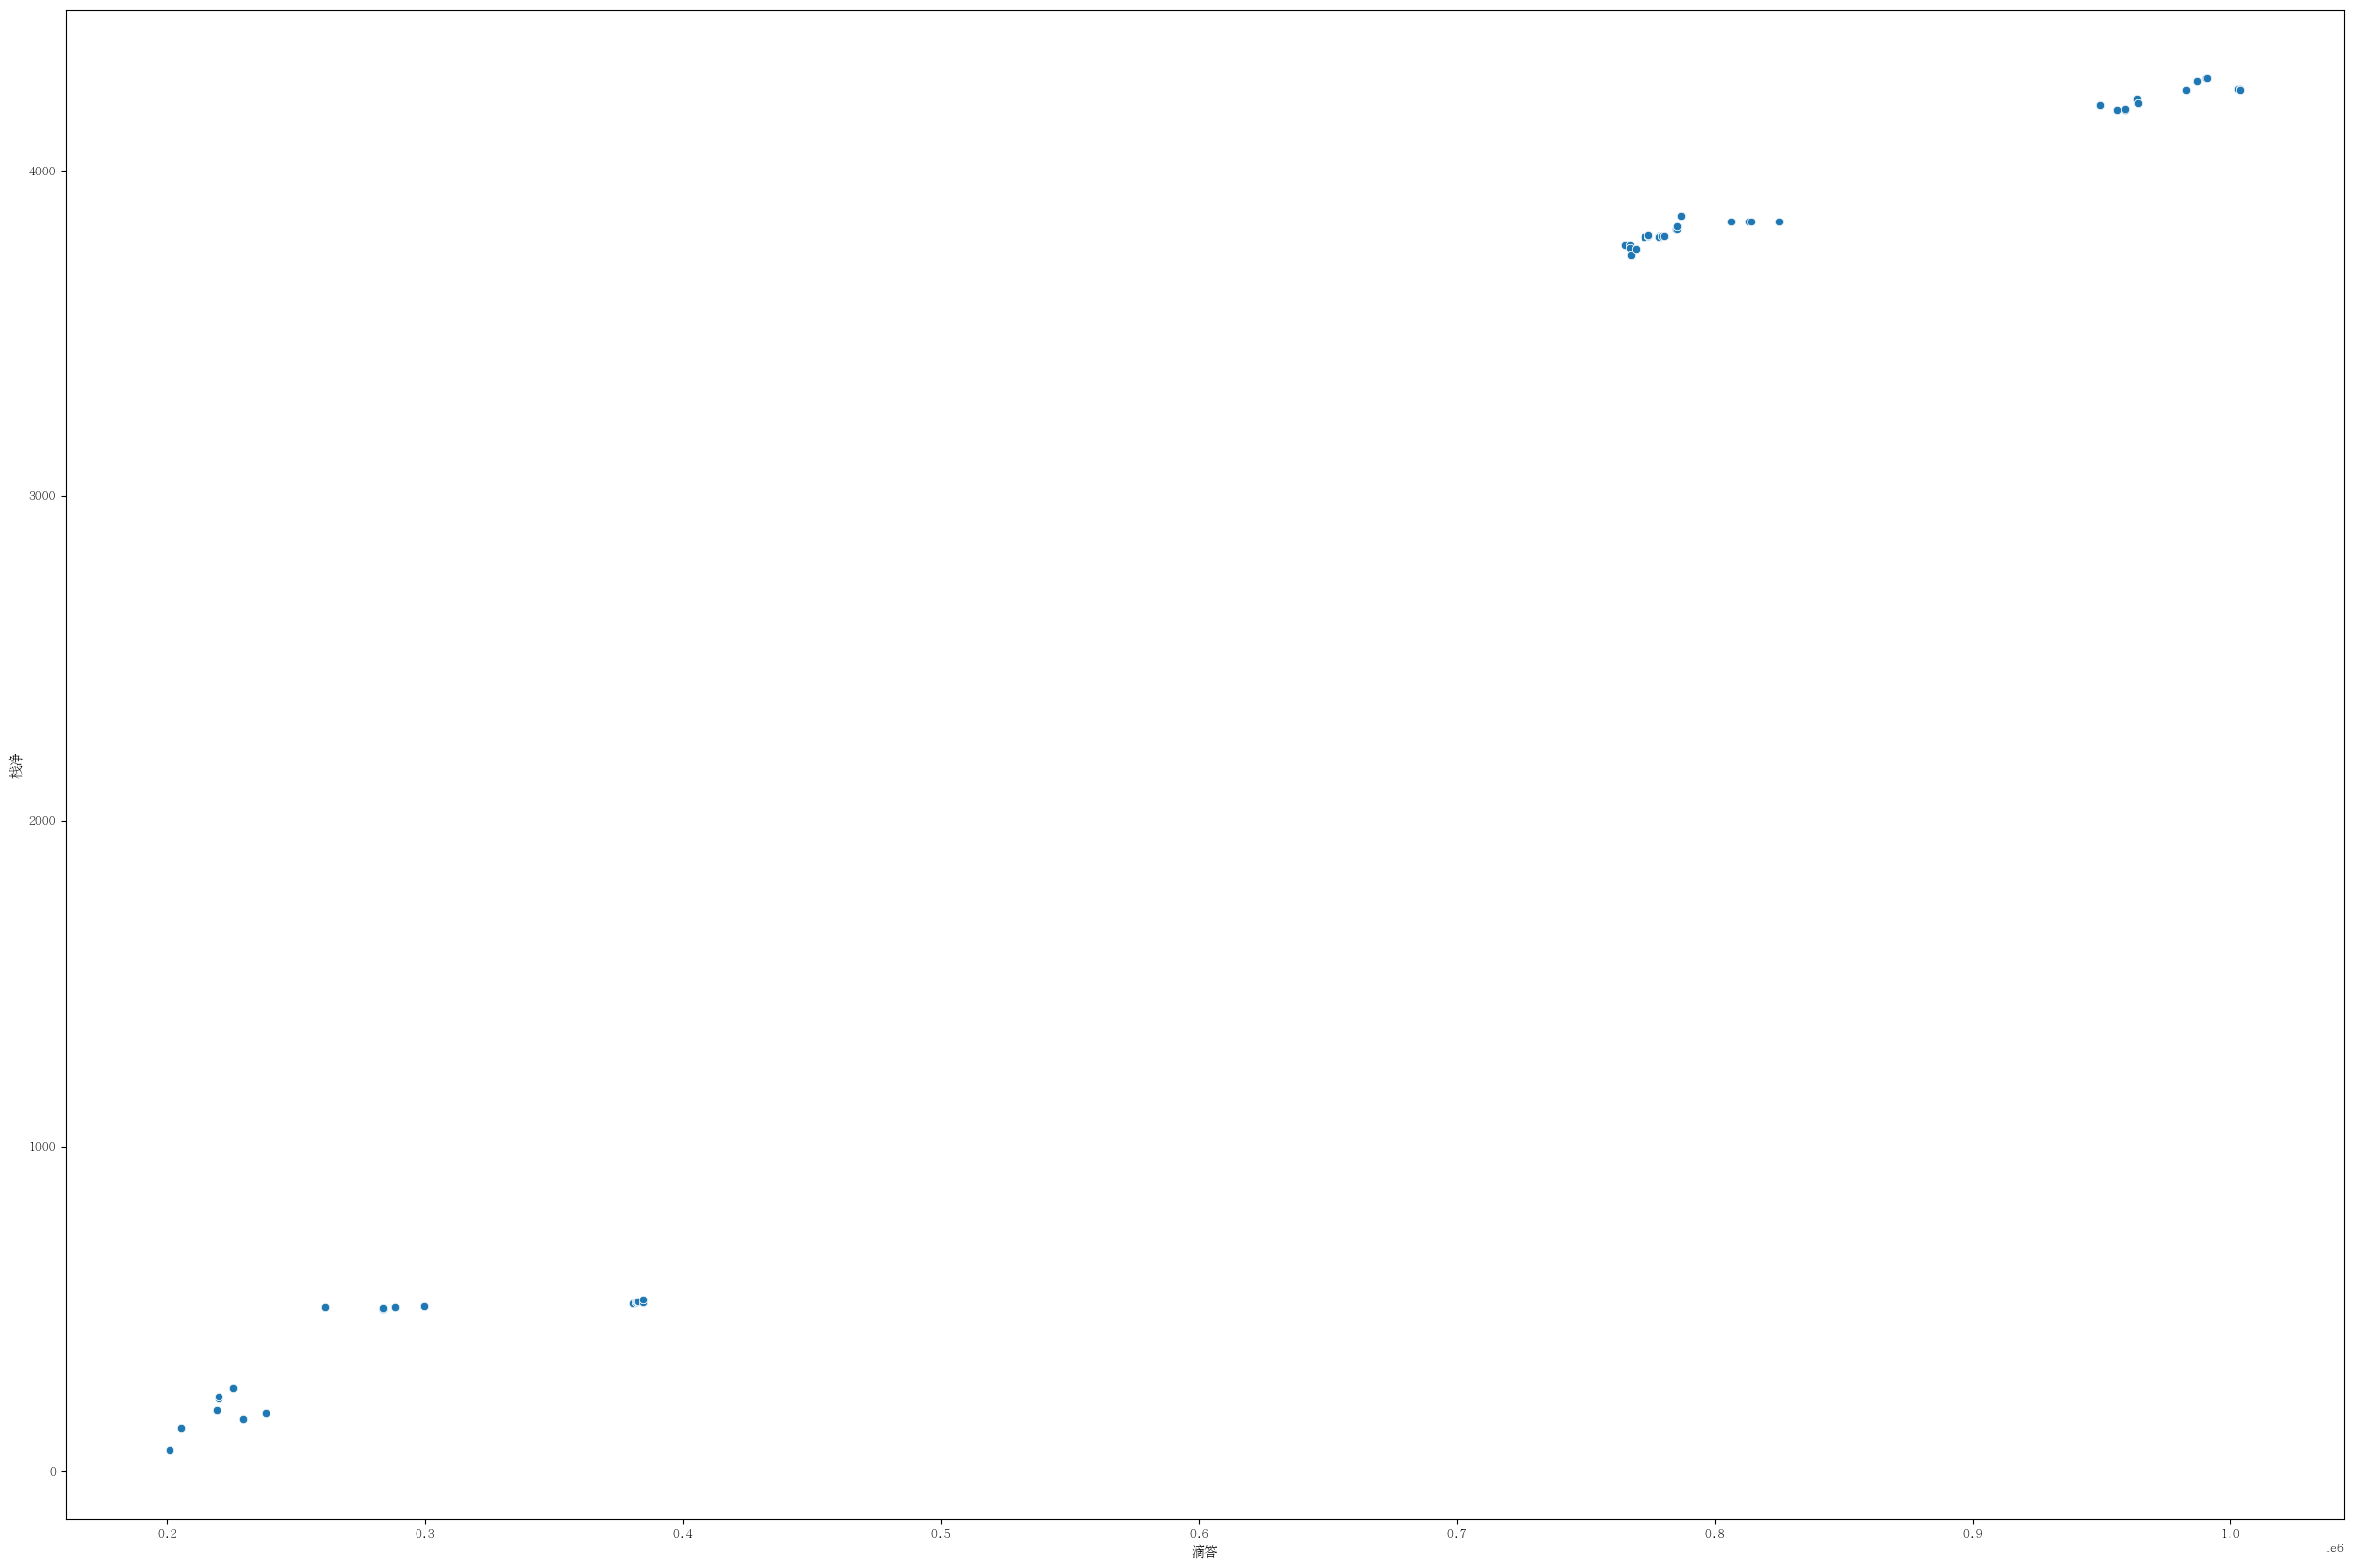

In [44]:
#调用次数后1/10处附近50的函数们
boundary=int(funcIdCnt*(1-1/10))
funcId_ls=srt_g_fiFn_dfmm.funcId.values[boundary-25:boundary+25]


dfmm_sparseFI = dfmm[  dfmm['funcId'].isin( funcId_ls )  ]
print(dfmm.shape, funcIdCnt,boundary, len(funcId_ls), dfmm_sparseFI.shape)
seaborn.scatterplot(x='滴答', y='栈净',  data=dfmm_sparseFI)

srt_g_fiFn_dfmm[  srt_g_fiFn_dfmm['funcId'].isin(funcId_ls)  ]  ['funcName']

### 4.3 plotly作图

In [45]:
mini_main_sparseFI_栈净_trace = graph_objs.Scatter(
 x = dfmm_sparseFI.滴答,
 y = dfmm_sparseFI.栈净,
 showlegend=True,
mode = 'markers',
marker={'color': dfmm_sparseFI['funcId'],'size':2, 'opacity': 0.9},
name="mini_main_稀疏函数_栈净"
)

# plotly_offline.iplot([ mini_main_sparseFI_栈净_trace])

### 4.4 plotly交互作图: 给定funcId列表

In [46]:

srt_g_fiFn_dfmm_FromN=srt_g_fiFn_dfmm[4:7]
funcId_FromN = srt_g_fiFn_dfmm_FromN.funcId.values


# 创建 Plotly 数据对象
data = []

# 创建每个 'funcId' 分组的散点图对象
for funcId in srt_g_fiFn_dfmm_FromN['funcId']:
    # 获取该分组的数据
    group_data = dfmm[dfmm['funcId'] == funcId]
    # 创建散点图对象
    scatter = graph_objs.Scatter(x=group_data['滴答'], y=group_data['栈净'],
                         mode='markers', name=funcId,  
                         marker=dict(color=funcId,size=1, opacity=0.7))
    # 将散点图对象添加到数据列表中
    data.append(scatter)

# 创建布局对象
layout = graph_objs.Layout(title='散点图 滴答_栈净',
                   xaxis={'title': '滴答','fixedrange': True}, yaxis={'title': '栈净'},
                   hovermode='closest')

# 创建 Figure 对象
fig = graph_objs.Figure(data=data, layout=layout)

# 创建交互式按钮
buttons = []
# 创建每个 'funcId' 分组的按钮
for funcId in srt_g_fiFn_dfmm_FromN['funcId']:
    visible = [True if x == funcId else False for x in funcId_FromN ]
    button = dict(label=funcId,
                  method='update',
                  args=[{'visible': visible},
                        {'title': f'散点图 滴答_栈净 funcId:({funcId})'}])
    buttons.append(button)

# 更新布局对象，添加交互式按钮
layout.update(updatemenus=[dict(active=0, buttons=buttons)])

# 创建 Figure 对象
fig = graph_objs.Figure(data=data, layout=layout)

# 使用 plotly.offline.iplot 进行绘图
# plotly_offline.iplot(fig)